# Load and prepare the data

## Import librairies

In [1]:
import requests
from pandas.api.types import CategoricalDtype
import itertools
import tweepy
import webbrowser
import os
from datetime import date, datetime

import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords 
import string
import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from matplotlib import rc
import plotly.express as px
from IPython.display import display, Image

## Keys and connection

In [2]:
# Import keys
from raw_data import keys
twitter_api_key = keys.twitter_api_key()
twitter_api_secret_key = keys.twitter_api_key_secret()
twitter_bearer_token = keys.twitter_bearer_token
# Connect my developer project to my twitter profile
callback_uri = "oob" # url
auth = tweepy.OAuthHandler(twitter_api_key, twitter_api_secret_key, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=eOWhvgAAAAABUe3MAAABfbjhYpc


In [5]:
m=

SyntaxError: invalid syntax (1928120398.py, line 1)

In [3]:
user_pin_value = '2174654'
auth.get_access_token(user_pin_value)
api = tweepy.API(auth)

## Load new content

### Function to extract the tweets of politicals that I follow

In [4]:
candidates_pseudo = """yjadot xavierbertrand vpecresse regis_ollivier philippejuvin n_arthaud montebourg luclaf larrouturou jfpoisson78 jeanlassalle gilleslazzarini gerardfiloche f_philippot dupontaignan antoine27955080 ZemmourEric Waechter2022 Vukuzman UPR_Asselineau PhilippePoutou MichelBarnier MartinRocca2022 MarCharlott MLP_officiel MAZUEL_Pace JaclineMouraud JLMelenchon HeleneThouy GildasVieira FabriceGrimal Fabien_Roussel EmmanuelMacron EPhilippe_LH ECiotti DenisPayre ClaraEgger1 Cau_Marie_ Anne_Hidalgo AnasseKazib AlexLanglois_ AguebPorterie"""
# We do not "clean" candidates pseudo to keep their original format which is important here
candidates_pseudo_list = word_tokenize(candidates_pseudo)

In [5]:
def extract_tweets_from_politics(number_of_tweet_per_politic, candidates_pseudo_list):
    """This function return a DataFrame of the last tweets of politics that I follow on Twitter"""
    
    # Start by working on my own account
    me = api.get_user(screen_name="alecoursonnois")
    # Generate a list of my all of my friends (considering that I have under 50 friends on twitter)
    my_friends = me.friends(count=50)
    
    # Retrieve my personal friends which I don't want to analyze their tweets
    politics = candidates_pseudo_list
    
    # Create a set to stock the DataFrame columns names
    columns = set()
    # Create a list to save each tweet and its datas
    tweets_data = []
    # Create to save politics screen_names
    politics_screen_name = []
    
    # Iterate on my_friends
    for friend in my_friends:
        friend_name = friend.screen_name
        
        # Don't act if this friend is out of the project
        if friend_name in politics:
            # Generate politics timeline list of the last tweets (the number must be indicated as a function's argument)
            timeline_list = api.get_user(screen_name=friend_name).timeline(count=number_of_tweet_per_politic, tweet_mode="extended")
            
            # Iterate on each tweet
            for status in timeline_list:
                # Generate a dictionary of status attributes
                status_dict = dict(vars(status))
                
                # From this dictionary, get the keys and stock it in a variable
                keys = vars(status).keys()
                
                # Create a dictionary stocking each status of the politic we are working on
                # This dictionary will be added to the "tweets_data" list and finaly convert into a DataFrame
                single_tweet_data = {}
    
                # Iterate on each status key (future column name)
                for k in keys:
                    # Add the status data to its right key into the dictionary of each status
                    single_tweet_data[k] = status_dict[k]
                    # Add the key as a column name in the set
                    columns.add(k)
                
                # Append the full single_tweet_data dictionary with the right key to the tweets_data list
                tweets_data.append(single_tweet_data)

    # Give a name to the columns respecting the order
    headers_cols = list(columns)

    # Allow the DataFrame to display full tweets when printed
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    # Convert the tweets_data list into a DataFrame
    df = pd.DataFrame(tweets_data)
    
    # Only keep columns that provides information
    columns_to_keep = ['id', '_json', 'source', 'source_url', 'retweet_count']
    df = df[columns_to_keep]
    
    # Generate new features from extracted data
    df["user"] = df["_json"].apply(lambda x : x["user"]["screen_name"])
    df["created_date"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%Y-%m-%d")
    df["created_hour"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%H:%M:%S")
    df["text"] = df["_json"].apply(lambda x : x["full_text"])
    df["hashtags"] = df["_json"].apply(lambda x : [hasthstags["text"] for hasthstags in x["entities"]["hashtags"]])
    
    # All url needed to display tweets with streamlit
    all_url = []
    # Iterate over "_json" to concatenate urls
    for content in df["_json"]:
        start = "https://twitter.com/"
        user = content["user"]["screen_name"]
        complement = "/status/"
        id_str = content["id_str"]
        # Concatenate
        full_url = start + user + complement + id_str
        # Append to the full list
        all_url.append(full_url)
    # Create the column
    df["url"] = all_url
    
    # Reorder columns
    right_order = ["user", "id", "source", "text", "created_date", "created_hour", "hashtags", "retweet_count", "url"]
    df = df[right_order]
    
    return df

### Apply the function

In [6]:
# Load new tweets
last_tweets_df = extract_tweets_from_politics(number_of_tweet_per_politic=250, candidates_pseudo_list=candidates_pseudo_list)
last_tweets_df.shape

(8139, 9)

### Add features

#### Generate new_features

In [7]:
new_features = [{"user":'EPhilippe_LH', "name": "Edouard Philippe","political_party":"Horizons", "political_orientation":"Droite"},
                 {"user":'ZemmourEric', "name": "Eric Zemmour", "political_party":"Aucun", "political_orientation":"Extrême Droite"},
                 {"user":'EmmanuelMacron', "name": "Emmanuel Macron", "political_party":"La République En Marche", "political_orientation":"Droite"},
                 {"user":'Waechter2022', "name": "Antoine Waechter", "political_party":"Mouvement Ecologiste Independant", "political_orientation":"Ecologie"},
                 {"user":'Fabien_Roussel', "name": "Fabien Roussel", "political_party":"Parti Communiste Français", "political_orientation":"Extrême Gauche"},
                 {"user":'PhilippePoutou', "name": "Philippe Poutou", "political_party":"Nouveau Parti Anticapitaliste", "political_orientation":"Extrême Gauche"},
                 {"user":'jfpoisson78', "name": "Jean-Frédéric Poisson", "political_party":"La Voie du Peuple", "political_orientation":"Extrême Droite"},
                 {"user":'f_philippot', "name": "Florian Philippot", "political_party":"Les Patriotes", "political_orientation":"Extrême Droite"},
                 {"user":'vpecresse', "name": "Valérie Pécresse", "political_party":"Soyons Libres", "political_orientation":"Droite"},
                 {"user":'DenisPayre', "name": "Denis Payre", "political_party":"Les Républicains", "political_orientation":"Droite"},
                 {"user":'montebourg', "name": "Arnaud Montebourg", "political_party":"L'Engagement", "political_orientation":"Gauche"},
                 {"user":'JLMelenchon', "name": "Jean-Luc Mélenchon", "political_party":"La France Insoumise", "political_orientation":"Extrême Gauche"},
                 {"user":'MLP_officiel', "name": "Marine Le Pen", "political_party":"Front National", "political_orientation":"Extrême Droite"},
                 {"user":'jeanlassalle', "name": "Jean Lassale", "political_party":"Résistons", "political_orientation":"Divers"},
                 {"user":'larrouturou', "name": "Pierre Larrouturou", "political_party":"Nouvelle Donne", "political_orientation":"Gauche"},
                 {"user":'philippejuvin', "name": "Philippe Juvin", "political_party":"Les Républicains", "political_orientation":"Droite"},
                 {"user":'yjadot', "name": "Yannick Jadot", "political_party":"Europe Ecologie-Les Verts", "political_orientation":"Ecologie"},
                 {"user":'Anne_Hidalgo', "name": "Anne Hidalgo", "political_party":"Parti Socialiste", "political_orientation":"Gauche"},
                 {"user":'gerardfiloche', "name": "Gerard Filoche", "political_party":"La Gauche Démocratique et Sociale", "political_orientation":"Extrême Gauche"},
                 {"user":'dupontaignan', "name": "Nicolas Dupont-Aignan", "political_party":"Debout la France", "political_orientation":"Extrême Droite"},
                 {"user":'ECiotti', "name": "Eric Ciotti", "political_party":"Les Républicain", "political_orientation":"Droite"},
                 {"user":'xavierbertrand', "name": "Xavier Bertrand", "political_party":"La Manufacture", "political_orientation":"Droite"},
                 {"user":'MichelBarnier', "name": "Michel Barnier", "political_party":"Les Républicains", "political_orientation":"Droite"},
                 {"user":'UPR_Asselineau', "name": "François Asselineau", "political_party":"Union Populaire Républicaine", "political_orientation":"Divers"},
                 {"user":'n_arthaud', "name": "Nathalie Arthaud", "political_party":"Lutte Ouvrière", "political_orientation":"Extrême Gauche"},
                 {"user":'MartinRocca2022', "name": "Martin Rocca", "political_party":"Constituante 2022", "political_orientation":"Divers"},
                 {"user":'gilleslazzarini', "name": "Gilles Lazzarini", "political_party":"Parti Politique pour la Paix et la Protection de la Planète", "political_orientation":"Divers"},
                 {"user":'AlexLanglois_', "name": "Alex Langlois", "political_party":"Refondation 2022", "political_orientation":"Divers"},
                 {"user":'luclaf', "name": "Luc Laforets", "political_party":"Une Perspective - la 6e République", "political_orientation":"Divers"},
                 {"user":'Vukuzman', "name": "Georges Kuzmanovic", "political_party":"République Souveraine", "political_orientation":"divers"},
                 {"user":'FabriceGrimal', "name": "Fabrice Grimal", "political_party":"La Concorde Citoyenne 2022", "political_orientation":"Divers"},
                 {"user":'ClaraEgger1', "name": "Clara Egger", "political_party":"Espoir RIC 2022", "political_orientation":"Divers"},
                 {"user":'Cau_Marie_', "name": "Marie Cau", "political_party":"Sans Etiquette", "political_orientation":"Divers"},
                 {"user":'antoine27955080', "name": "Antoine Martinez", "political_party":"Volontaires pour la France", "political_orientation":"Extrême Droite"},
                 {"user":'regis_ollivier', "name": "Régis Ollivier", "political_party":"Indépendant", "political_orientation":"Droite"},
                 {"user":'JaclineMouraud', "name": "Jacline Mouraud", "political_party":"Sans Etiquette", "political_orientation":"Droite"},
                 {"user":'HeleneThouy', "name": "Hélène Thouy", "political_party":"Parti Animaliste", "political_orientation":"Ecologie"},
                 {"user":'MAZUEL_Pace', "name": "Philippe Mazuel", "political_party":"Pace", "political_orientation":"Gauche"},
                 {"user":'MarCharlott', "name": "Charlotte Marchandise", "political_party":"Sans Etiquette", "political_orientation":"Gauche"},
                 {"user":'AguebPorterie', "name": "Anna Agueb-Porterie", "political_party":"Aucun", "political_orientation":"Gauche"},
                 {"user":'AnasseKazib', "name": "Anasse Kazib", "political_party":"Courant Communiste Révolutionnaire-Révolution Permanente", "political_orientation":"Extrême Gauche"},
                 {"user":'Stauthui', "name": "Stéphane Tauthui", "political_party":"Tous France", "political_orientation":"Droite"},
                 {"user":'GildasVieira', "name": "Gildas Vieira", "political_party":"La France autrement", "political_orientation":"Divers"},]

In [8]:
new_features_df = pd.DataFrame(new_features)

#### Merge it to last_tweets_df

In [9]:
# because M Rocca changed his accounts name we must change our informations
last_tweets_df["user"] = last_tweets_df["user"].str.replace("MartinRocca12", "MartinRocca2022")
# Merge
last_tweets_df = pd.merge(left=last_tweets_df, right=new_features_df, on='user', how='left')

### Check the number of tweets per politics

In [26]:
# last_tweets_df["user"].value_counts()

### Add it to the main global DataFrame

#### Load the global_df 
- and drop the last index column automatically named "Unamed: 0" when saving df to csv file

In [10]:
global_df = pd.read_csv("global_df.csv").drop(columns="Unnamed: 0")

#### Add new content

In [11]:
actual_number_of_tweets = global_df.shape[0]

# Append last tweets loaded to our archives
global_df = global_df.append(last_tweets_df, ignore_index=True)

# Sort the df by retweet_count to be sure to only keep the last update of retweet_count
global_df = global_df.sort_values('retweet_count', ascending=False).drop_duplicates(["user", "id", "source", "text", "created_date", "created_hour", "name", "political_party","political_orientation"])

print(f"We just added {global_df.shape[0]-actual_number_of_tweets} tweets to our global_df")

We just added 379 tweets to our global_df


#### Save the new global_df

In [12]:
global_df.shape

(15107, 12)

In [13]:
global_df["user"] = global_df["user"].str.replace("MartinRocca12", "MartinRocca2022")

In [195]:
global_df.to_csv("global_df.csv")

## Clean tweets

### Make a new df from the global one
- This way we will be allowed to drop duplicates next time we will load the global_df from the csv file

In [196]:
df_ready_for_nlp = global_df.copy()

### Retrieve recurrent regex

#### Retweets

In [16]:
def retrieve_rt_retweets(df):
    new_texts = []
    
    for text in df["text"]:
        if text[:3] == 'RT ' or text[:3] == 'rt ':
            new_texts.append(text[3:])
        else:
            new_texts.append(text)
    
    df["text"] = new_texts
    
    return df

In [197]:
df_ready_for_nlp = retrieve_rt_retweets(df_ready_for_nlp)

#### Links

In [18]:
def retrieve_links(df):
    pattern = re.compile("https://*")
    new_text = []

    for text in df["text"]:
        if re.search(pattern, text) is None:
            new_text.append(text)
        else:
            match_position = re.search(pattern, text).span()[0]
            new_text.append(text[:(match_position-1)])

    df["text"] = new_text
    
    return df

In [198]:
df_ready_for_nlp = retrieve_links(df_ready_for_nlp)


### Retrieve punctuation, lower text, tokenize, stopwords

#### Define a text_cleaner function

In [20]:
def text_cleaner(text):
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower() 
    
    # Remove accents
    unaccented_string = unidecode.unidecode(lowercased) 
    
    # Tokenize
    tokenized = word_tokenize(unaccented_string) 
    
    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()] 
    
    # Make stopword list
    stop_words = set(stopwords.words('french')) 
    
    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

#### Apply the text_cleaner function

In [199]:
df_ready_for_nlp['text'] = df_ready_for_nlp['text'].apply(text_cleaner)

### Check the new words

In [22]:
words_known_1 = """chanceux chances chancelier chancel chance chan champselysees champs champions championne champion champagne champ chamouille chambres chambre chambourcy chamboncellea chambery chambecitoyenne chalucet chalons chalonnais chalon chalmin challenging challenges challenged challenge chalifert chaleureux chaleureuses chaleureusement chaleureuse chaleur chaix chaise chair chains chaines chaine chahinez chacune chacun cha ch cgtleroymerlin cgt cfdt cf cewugczasi ceux cette cett cetaces ceta cet cestmavieprivee cessons cessez cesseront cessera cesser cessent cesse cesajohann cerveauxnon cerveau certitude certificat certif certes certains certaines certainement certaine certain cerrone cerises ceremonie cereme cercle cependant centrons centro centristes centriste centres centree centre centralisatrice centrales centralenantes centrale central centimetre centenaire centaines centaine cent censurer censuree censure censeurs censes censees censee cense cendres cemyoldass cemento cemat celui celsius cellules cellule celles celle celinegeissmann celineboeuf celiamebroukine celebrons celebres celebrer celebrent celebre cela ceints ceejviacgz ceds cedricvial cedricherrou cedric cedons cedh cederons cedera ceder cede cecphil cecile ceci cecgalluccio ceccaldi cebcyber cdu cdricnouvelot cdjoncour cdja cdion cdgournay cdganay cderoche cdenquete cdd cdcaancfrance cdc cdanslair ccuhtmdwmh ccrubnmddr ccl ccif ccesoir ccastaner cc cbonfantidossat cbkwoimcli cbeaunemenacait cbeaune cbdaflvsrd cazeneuve cavous caviar caveriviere cavecchi cave cavalier cautionne causeur causes causer causent causee cause cauofficiel caudehenrion cauchy cauchem caucase cau cattannancy catimini catholiques catholique catholicisme cathhelayel catherinedvries catherine cathedrales cathedrale cathchabaud categoriquement categories categorie catbelrhiti catastrophiques catastrophique catastrophes catastrophe catalogue cataclysmiquement cata cat castro castres casting castex castes castelnau castel caste castaner castagneurde cassure cassin casseurs casseroles cassera casser casse casque casino casier caserne case cascade casareal cas cartons carton cartes cartel cartefrancaise carte cars carrieristes carrieres carriere carrement carrefour carre carqueiranne carpentrassiens carpentrassiennes carpentras carottes caronaymericoff carolinerooseeu carolinemecary carolinefourest carolineconnan caroline caroledelga caro carnets carnet carnage carmaux carlosdeamberes carlos carlito carinegreusard carine carignon caricatures caricaturee caricature caricaturale caricatural carentan cardon cardinal cardiaques cardiaque carcerale carceral carcan carburants carburant carbonne carbonise carbones carbone carbon caracteriser caractere caract car captures capture capteurs captain caprices cappolitique caporal capituler capitule capitulation capitulardes capitennerie capitaux capitaniooliv capitan capitalistes capitaliste capitalisme capitalisation capitale capital capitainerie capitaine capella capel capacities capacites capacite capables capable cap cantonne canton cantine cantal canons cannet cannes cannabis canico canebiere candidatures candidature candidatur candidats candidato candidates candidatent candidate candidatcitoyen candidat candida candicale candeur cand canche cancers cancerogene cancer cancelculture cancel canards canardenchaine canape canaliser canal canadiens canadiennes canada can campusangers campus camps campaigns campagnoltvl campagneter campagnes campagne camp camouflet camoufler camouflage camions camion camino camillemarguin camillelupo camillejung camilleetienne camillediao camille cameroneday camerone cameras camera camembert cambioclimatico camaron camarades camaradecharles camarade camaieu calvi calvaire calvados calques calque calmos calmes calmer calme callet called call californie calibre calfootball caler calendrier calee caledoniens caledonien caledonie calculs calculee calculatrice calculateur calcul calamiteux calaisis calais calai cala caisses caisse caille caillaud caillasses caids caid cahiers cagnotte cages cagejulia cage cafouiller cafouillage cafes cafepedagogique cafeflore cafe caenofficiel caen cadvyepqrx cadres cadremploi cadre cador cadences cadeaux cadeau cad cachottiers cachette caches cacher cachent cachee cache cachant cacao cacahuetes cabourg cabinet cabale ca bzduwgnbak bzdkdvtuel bye by bxlwqwmvkz bx bwtgpjbcfn bwjyaocwhu bvoltaire bvgafuiioa bvdatfbrjl bva buzze buzz buzyn buvzbisrvg buts butre but busson business busherie busan bus burxyikggw burns burnout burn burlesque burkini burkinafaso burkina burgers burgerkandidat burgerinnen burger bureaux bureaucratique bureaucratie bureau bur bundestag bundesbank bullshit bulletins bulletin bulldozers bulldozer bulgarie bulding bugey bug buffet buena budgets budgetaire budget buaxoimujz btzmaider btp btflzxeeuy bseqizlstb bsengayrac bs brwypzpuht bruz bruyante bruxelloise bruxellois bruxelles brutofficiel brutalite brutal brut brussels brunswick brunoretailleau brunolemaire brunobonnelloff brunobernard bruno brunes brumath bruler brulee brule brulante bruit bruges bruce brouillles brouilles brouillard brothers brother brossat bronchiolite broncher brodujosue brochette brk british britanniques britannique brisson brisons brises briser brisees brisant brio bring brimade brilliant brillent brille brillants brillante brillant brillamment brigitteswdlp brigitte brigbourguignon brigade bride bricolage brick bricetayon bricemontagne bricehortefeux brice briancon brexit brevets breton bretagne brest bresse bresil brel breizhofficiel brefs bref brebis breard break bravoure bravo bravee brauman braucht brasserie brassent brasse bras braquage brandir brandi brand branches branche braises braise brader brade bracelets bracelet bquestel bqqqjenlze bqmcvdzdue bpolitics bpcnakxvig boyerj boycottons boycotter boycotte boycottant boycott boxeuse bovine bouts boutry boutoir bouteillevide bouteilles boutaour bout boussole bousille bousculer boursieres boursier bourses bourse bourrin bourres bourreaux bourreau bourre bourquinmartial bourla bourgogne bourgeoisie bourgeoise bourgeois bourg bourdouleix bourdindirect bourdin bourde bouquin bounty bouna boulot boulognesurmer boulognebillancourt boulogne bouleverser bouleversement bouleversee bouleversante bouleversant boulevard boulet boule boulangerie boulanger bouillon bouillie bouillant bouhafs bougrain bougnoule bougle bougies bouger bougeons bougent bouge bouffer bouffee bouee boue boudotetienne bouddhistes bouddha boudaud boudard boucs bouclier boucler boucle bouchesdurhone bouches boucherie bouche boucaud bouc botvedovelli bottes botswana botliberalisme botanistes botanique bossent bosse boss bosquet borowskimike bornes borne borisvallaud borisjohnson boris borg bords bordry bordelais bordel bordeaux bord borcasaz borbenih booster book booba bonvoisin bonus bonsoir bonsensorg bons bonny bonneval bonnet bonnes bonne bonnant bonjourchezvous bonjour bonimenteur bonhomme bonheur bondees bon bomdlgpqgs bombes bomber bombe bombardier bombardent bombardements bolsonaro bollore bolide bol boites boite boisson bois boire bohringer bof boeufs bochenek bobos bobomutu bobo bobet bobards bob boat bo bnzgyvlqaa bnvnhweqpm bnvjtofpwg bnp bnlnhgwaqz bmosjvonwr bmmrfjsomp bmftv bmalgorn bluff blouses bloques bloquer bloquent bloquee bloque bloquant bloombergtv bloomberg blonde blois blog blocus blocpop bloch blocages blocage bloc blmasquesoff bllpvwcvgl blindee bleustetienne bleus bleuprovence bleuet bleues bleubesancon bleualsace bleu blessures blessure blesses blessees blesse blesois bles blendecques ble blast blaspheme blasco blanquer blancs blanco blanches blanche blanc blamer blaisecampaore blague blagnac blacks blackfriday blackbloc blachier blache blabla bjpxoxlxbd bjnyabibat bizpkesheh bizetjeremy bizarrement bizarre biuooygwpw bitume bitten bist bisounours bisounour bises bise birthday bira bir bip biotechnologie biotech biontech biondisylvie biometriques biometrique biomedicaments biomasse biologique biodiversity biodiversite biodiv biocarburants bio binks binaire bilou billions billion billetsdudr billets billet billangepascale billancourt bill bilingues bilgerphilippe bildmartial bilderberg bilddetektivin bilateraux bilaterale bilateral bilandelahonte bilan bijouterie bijou bigpharma bigourdan bigot bigard big bifurque bifurcation bifurcati bierry bieres biere bienvenus bienvenues bienvenue bienvenu bienvenido bienveillant bienveillance bientot biens bienfaits bien bielorussie bielorusses bielorusse bie bidonnees bidon biden biche bibliotheque biban biarritz bianchi bhxbnbyxdd bhksptpbqv bhkajbfmig bhbszyubgt bhaart bgothiere bfmtv bfmstory bfmpolitique bfmbusiness bfm bfc bezos bezierscolbac beyrouth betydelse between better beton betisier betises betise bethune bethanie betes bete betail besturtzung besteht beste best besson besombes besoins besoin besnehard besmart besancon berty bertrandusclat bertrand berton bertindak bertignaclouis bertholet bersama bernie berner berne bernardtapie bernardsnick bernardreynes bernardlaporte bernardjomier bernardguettade bernardcarayon bernardarnault bernardaccoyer bernard bernadettereine berman berlusconi berlinerzeitung berliner berlin berlaymont bergams berezina bercy bentil benteler bensaid benoitrautureau benoitpayan benoitlievin benoitignaceoff benoithamon benoitbiteau benoitbarret benoit benoha benniibliss benne benleruth benjmathieu benjaminhaddad benjamingramont benjaminglaise benjamincauchy benjamin benin beni benfeld benfayet benevoles beneficieront beneficier beneficient beneficie beneficiaires benefices benefice benef benedicttaurine benedictosolson benbrrd benayassa benallaoff benalla ben bemjipnixv belvedere beltrame belmondo belliard bellevilloise belleville belles belle bellatar belindageoly believe belgrand belgium belgique belges belge belfort belattar bel being beileid bei behringersdorf behind begrussen begles begaudeau befolkning beethoven beer beenewsdaily become bechieau because becard bec bebes bebel bebe beaux beauvaudelasecurite beauvau beauvais beautiful beaute beaune beaucoup beauce beauc beau beatricesigismeau beatricepinat beate bearnbigorre bearn be bdstanley bdhbbwcxhl bdemontille bdelachesnais bcp bce bcazeneuve bca bbwxjxjedd bboisgarnier bbjrtigkkp bbcworld bbcheminot bbcbreaking bbalczjkon bazarder bayrou bayou bayonne bayeux bavard baume bauges bauernschmidt baudu baudriller baudelaire batya battus battues battu battre battrai battra battons batteries battent battante battant battagliaalain battage bats batons baton batit batirai batir batiments batiment batignolles baticle bati batho bateaux bateau batard batalla bataillon batailles bataille bataclan bat bastille bastienparisot bastamag bassinrebel bassines bassine bassin bassesse basses basque basphilippe basique basilefanier bashing bash bases basees basee base basculons basculer basculement bascule bas bartres barthelemy bars barroso barrieres barriere barricades barres barreau barre barrages barrage barqcmysty baroque barnier barnavegab barkhane baretous bardot bardella barcellini barbpanther barbier barbes barbeles barbe barbaries barbarie barbares barbare barbarapompili barbaralefevre barbara baran baraket baraka bar baptiste bapstmaisonneuv bantig banquier banquesalim banques banque banlieues banlieue bangumiprod bangkok bang banditisme bandes bande bancaires bancaire banc bananiere banania bananes banalite banalisation banale banalcommetout bamboula balzac ballybagayoko balles balle balladur balkans balise bale baldige balayeurs balayer balaye balancetonpost balance balai balader balade bal baker bajarikocber baissons baissez baissetatva baisses baisserai baisser baissent baissee baisse baissant bains bain bailly baillonner baillonnant bailleurs bail baie bahambouladylan bah bagui baguette bagnole bagne bagarre bafouiller bafouent bafoue baerbock badr badiou badinter badges badge bacq bacle back bachelot bacheliere bac babpravi ba b azzaznadege azureen azur aztdczhrwo aznavour azimuts azeris azerbaidjan az aymone aymbld aylzblqazu aylo ayatollahs axwanxsvor axes axelsibert axee axe axcvoljjqq axbggxruix axa ax awwyqzcgmo awpcvsybyv awbfttmymm avui avt avrille avril avouer avoue avote avortements avold avoir avoidable avocats avocate avocat avmngwyyom avis avion avignon avides aveyron aveugles aveuglements aveuglement aveugle aveu avertissements avertissement avertis averes avere avenue aventure avent avenirencommun avenir avecvalerie avecv avecroussel avecpayre avecjuvinaura avecjuvin avecjlm avecericciotti avecciotti ave avc avantages avantage avant avancons avancera avancer avancent avancees avancee avance avallon avaler avale av auxquels auxquelles auxiliaires auxerre auxcerf auvergnerhalpes auvergne auvergnats autrui autrichiennes autrichienne autrichien autriche autrice autres autrement autrefois autre autour autotests autoroutes autorites autorite autoritarisme autoritaires autoritaire autorises autoriser autorisee autorise autorisations autorisation autorisant autoproclames autoproclame autonomistes autonomisation autonomie autonome automobilistes automobiliste automobiles automobile automne automatiquement automatique automates autoentrepreneur autocollants autochtones autocensure auto autisme authentiques authentiquement authentique authenticite auteurs auteure auteur autel autant autain australiens australienne australien australie australe aussitot aussi aussergewohnliche auspices ausi aus aurore aurelientache aurelienpradie aurelien aurelieaulagnon aur auquel aupres auparavant aumonier aumone aujourd aujou auj auguste augure augmentions augmenterons augmenterait augmenterai augmentera augmenter augmentent augmente augmentations augmentationdessalaires augmentation augmentant augmen auge aufbauplans aufaite auf audricalexandrepace audricalexandre audric audreyhenocque audreygarric audrey auditorium auditions auditionne audition auditeurs audit audiovisuel audio audincourt audiences audience audibertedith audiard audacieux audacieusef audaces audace aucunement aucune aucun auch aubry aubree aubervilliers aubertofficiel auberge aube attristees attriste attributs attribution attribues attraper attractivite attractives attractive attitudes attitude attiser attestes attestent attestation atterre attenuer attentivement attentive attention attentifs attentif attentes attente attentats attentatoire attentat attendues attendue attendu attends attendre attendons attending attendez attendent attendant attendait attend atteints atteintes atteinte atteint atteindre atteignent attaquez attaqueterroriste attaques attaquer attaquent attaquees attaquee attaque attaquant attali attal attaf attacks attack attaches attachement attachees attach attac atrocites atrielfeudhiver atqzacaieg atouts atout atoueilles atomique atmosphere atm atlantiste atlantiques atlantique atlantico atlantic atih athletes ateliers atelier atdqm atdorpmuct at aszhjzxahs asy astrubaal astropierre astro astrid astreinte astrazeneca asterix assures assureront assurer assurent assure assurances assurance assur assumons assumer assument assumees assumee assume assumait assu assourdissant assos assomption assommes assomment assomireillek associes associer associe associatives associative associations association associatifs associatif associated associant assoc assoaurore asso assita assistons assister assistants assistance assistanat assis assimiles assimilee assimile assimilation assiettes assiege assez assesseurs asservissement asservis assemblees assembleenationale assembleenat assemblee asselineau assecher assassins assassines assassinees assassine assassinat assaslgbt assas assange assainir assaillis assa aspkahiscp aspirent aspirations aspiration aspirantes asphyxiant aslanov askel asindidier asile asie asia ashtarak ashamed aserstmalo ascoval aschneiker ascenseur asandermep arzt artsakh artistes artiste artisans artisanal artificiels artificielle artificiel artificialisation articles article arthurmoinet arthur arthaud artefr arte art arsenic arsenal ars arrriver arroser arrose arrondissement arroi arrogante arrogant arrogance arrivisme arrives arriverons arriverai arrivera arriver arrivent arrivee arrive arrivants arrivant arrigo arrieres arriere arrets arretons arretez arretes arreteront arretera arreter arretent arrete arret arre arras arranges arrangements arracheur arracher arrachent arr around arossigneux arosencher arnm arnaultraphael arnaudmurgia arnauddanjean arnaudbontemps arnaud arnaque arn armor armistice armes armer armeniens armenienne armenien armenie armembfrance armel armees armeedeterre armee armed arme armand armagnac arizteguieddine arie arianechemin ariane arguments argumentee argumente argumentaire argument argonnes argenteuil argent arene are ardoise ardentes ardemment archives architecture architecte archi arche archaiques archaique arcdetriomphe arcachon arc arbres arbre arborer arbore arboitgerald arbitre arbitraires arbitrairement arabiesaoudite arabie arabes arabe arab ar aquilino aquatennens aqpcgcshrt aqmvuuzgzm apvtdtxpow aprogrammatique aprmivwnrw apres appuyes appuyer appui approximations approvisionnement approuvez approuver approuvent approuvee approuve appropriees approprie approfondir approfondie approfondi approche approbation appris apprentissages apprentissage apprenons apprenez apprendrons apprendre apprend apprenant apprehender appreciez apprecier apprecie apporterai apporter apportent apportees apportee apporte appointed apply appliquons appliquer appliquent appliquees appliquee applique appliquant applications application applicable applaudit applaudissent applaudissements applaudissait applaudis applaudir appetits appetit appels appelons appellera appellent appelle appellait appelez appeles appeler appelent appele appelait appel appauvrit appauvris appat apparus apparu appartient appartiennent appartenant appartenance appartements appartement apparition apparemment appareils appareil apparaitront apparaitre apparaitra apparait apparaissent app apos apologies apollinematin apogee apo apiviavoile apimed apiculteurs aphones aperocrates apero apercu apartheid apannecy apaise apaisant apagan aout aop anyupjozgo any anxiogene anxiete antoinewaechter antoinevermorel antoinehome antoineguillou antoinedecaunes antoine antivax antithese antisociales antisemitisme antisemites antisemite antiracistes antiraciste antipasssanitaire antipass antiouvriere antimissile antilles antiliberal antijudaism antigeniques antifascistes antifasciste antifas antidemocratique anticorrida anticorps anticor anticonfinements anticipons anticipo anticiper anticipee anticipe anticapitalistes anticapitaliste anti anthroposophe anthropologique anthonybrondel anthonyberaud anthony anthoberthelier antennes ante antara answers ansm ans anouchtoranian another anormal anonynec anonymes anonymat annuler annule annulation annulant annuites annuels annuelle annually annualisees annualise annual annuaire announcing announce annoncons annonces annoncera annoncer annoncent annoncees annoncee annonce annoncait annoncaient anniversaire anniv annihile anniegenevard annickgirardin annexes annette annesophielapix annelaureblin annees annee annecy annebbrunet anne annalena anna ankayssrym ankara anizon aniversario animo animer animee anime animaux animations animateur animaltestingfr animaliste animalier animale animalcrossasso animal anima anicelajnef ani anhkwcmdgj angryredguard angouleme ango anglo angleterre anglais angers angell angelique angela angel anesthesie anemmontagne anecdotique anecdotes anecdote aneantir anduaga andrzejduda android androgyne andrelaignel andrej andrebercoff andre andogarabedian anderssonmagda andersen and ancres ancree ancre anckou anciens ancienne ancien ancetres ancestrales anato anatheme anassekazib anasse anarchiste anarchique anarchie anar analysons analyses analyse analysaient anaisjehanno anais anachronisme ana an amy amxjodrhqq amusement amusante amusant amsterdam amritanarl amrhzcozsm amputation amplifier amplifie ampleur amphi amp amoureux amoureuses amour amorcer amorce amnestypresse amnestyfrance amnesty amitie amisdelaterre amis aminmbarki amincissement amiens amie amicizia amicaux amicales amical amiante ami amf ames amertume amerique americans americains americaines americaine americain america amer amenerai amener amenent amenees amenee amene amendilgeronimo amendes amender amendements amende amendables amenagement amenageable amemauresmo amelioreront ameliorerons ameliorer ameliore ameliorations amelioration ameliorant amelietehel amelie ame ambulancieres ambroise ambitious ambitions ambition ambitieux ambitieuses ambitieuse ambiguite ambigu ambiantes ambiante ambiance ambassadeurs ambassadeur ambassades ambassade amazonstpriest amazonie amazon amazing amateurs amasses amandinedlf amanda amalgames amacedubois am alzheimer alydiouara alx alvancewheels alvance alv aluminium alu altruistes alticefrance althecat alterophobes alternativeshum alternative alternatifs alternance altere alstom also alsissi alsacien alsace als already alpmhnxowg alpins alphandery alpes alp alors alone almuneda almudena ally allures allumer allouer alloue allore allonsenfants allons allonger allongement allomelenchon allocutions allocution allocs allocations allocation allo allionefnspf allies allierait allier allient alliee allie allianceforets alliancecitoyen alliance allezlesbleus allez alles allers aller allemands allemandes allemande allemand alleman allemagne allemag alleluia allegrement alleger allegeance alle allant allan allaitante allait allais allain allaient allahou allah all aljaamqduc alix alimi alimentes alimenter alimentent alimente alimentationequitablepourtous alimentation alimentaires alimentairement alimentaire aligot alignes alignement alicekarenine alicecoffin alicebierret alibi alias ali algorithme algeriens algerienne algerie alfzgcmtnq alfred alferdez alexvrsaradjian alexvincendet alexvilp alexseale alexndraborchio alexlanglois alexlanglo alexla alexiskarklins alexiscorbiere alexis alexiagermont alexdevecchio alexdessinateur alexburetey alexandre alexandramortet alexandra alexander alexafaucher alex alertons alertions alerter alertent alerte alertant alertais alert alec aleas alcoolises alcide alcatel alcapone albrecht albinwagener albi alberta albert alarme alarmante alarmant alarmaient alancelin alan alairlibre alainhoupert alaingrandjean alain al akrzpfzvjd akqofzgojw akp akina akhenatoniam akhbar akbar akan ajustements ajs ajrd ajpseditor ajouter ajoute ajnckvdcip ajdui ajd ajb ajadeline aixlesbains aix aissr aisne aise airs airparif airliquidegroup aire air ainsi aines aimons aimez aimes aimeront aimerions aimerait aimerais aimerai aimer aiment aimees aime aimait aimables aimable ailleurs ailleur aillent aille aigue aignan aieux aidons aidindanger aidez aides aider aident aidees aided aide aidckfqkur aidant aid ahurissante ahurissant ahqautkfeh ahimsasan ahead ahamziou ah aguilera aguilar aguebporterie aguebporteri aguebpo agueb agroecologique agroalimentaire agro agriculture agriculteurs agriculteur agricoles agricole agri agressivite agressive agressions agression agressifs agresseurs agresses agressent agressees agressee agresse agressdeg agreges agree agreable agora agonie agnesrunacher agneslebrun agnesfirmin agnesevren agnescatoire agnesbuzyn agnes agnan agli agitent agit agissons agissez agissent agissements agissants agiront agirons agirez agir agi aghabayramov aggravent aggravee aggrave aggravante agglomerations aggiornamentohg ages agents agentes agent agenetet agenda agence agen agees aged age agarzon agar against again agagboudjahlat agace ag afvmvpvmgm afv afuxlawqqe aftermath after afriquefrance afrique african africains africaine africain afptv afpfr afp afocraud afkuqnljwv afin afh afghans afghanistan afghanishtan afghanes afghane afghan affronter affrontent affrontements affronte affront affreux affreusement affreuse affranchiras affranchir affluent affligeant affirmons affirmer affirment affirmed affirme affirmation affirmant affinite afficher affiche affichant affichage affectueux affectueuse affects affection affectifs affectif affectes affected affecte affamer affaissement affaissee affaires affairekohler affaire affaiblissent affaiblissement affaiblira affaiblie afd aesh aeroports aeroport aeriennes aerien aem aefxmirrdd aec adyfe advocacy adversaires adversaire advenir adultes adulte adsaum adrientaquet adrienmadec adrien adriancourtier adressons adresser adressee adresse adp ados adore adoration adoptons adoptions adoptes adopter adopte adoptants adopt adolescents adolescent ado admissibles admise admis admire admirative admiration admirateurs admirables admirablement admirable administrer administrees administre administrativement administrative administrations administration administratifs administratif admi admettre admet adjoints adjointe adjani adieu adhesions adhesion adherez adherer adherents adherent adhere adequation adeptes adepte ademontchalin adelphite adeline adelaide adeicffpom adecagny addressed addition addiction adaptons adaptes adapter adaptent adaptees adaptee adapte adamryuga adama adalah adahyot adage ad acwunbpmss acuerdo actuspays actusmondial actulourdes actufoot actuels actuelles actuellement actuelle actuel actualites actualite actualises actualise actu activites activite activistes activent activement activee active actions actionnaires actionnaire action actio actifs actif acteurs actes actees acte act acrimed acquitte acquises acquise acquis acquiesce acordebard acierie acier achieving achieve achevee acheve achetes acheter achetent acheminent achat acharnement acharne aces acduvivier accuser accusent accuse accusations accusation accumule accumulation accueillons accueillis accueillir accueillie accueilli accueillera accueillent accueille accueillantes accueil accrue accroitre accroit accrochage accrediter accoutrements accoudray accoucher accouche accords accordons accorder accordeon accordent accordees accordee accorde accordant accord accor accomplissent accomplissement accomplissant accomplis accomplir accompli accompagnons accompagnes accompagner accompagnent accompagnement accompagnee accompagne accompagnants accomodante acclame accidents accidentel accident accessoirement accessibles accessible access acces acceptons acceptions acceptez acceptesst accepterons accepterait acceptera accepter acceptent acceptee accepte acceptation acceptant acceptance acceptaient acceptables acceptable accept accentuent accent accelerons accelerer acceleree accelere acceleration accelerates accelerate accedez acceder accedent accaryandre accaparer accaparement accalmie accable accablants accablantes accablante accablant acarrouer academies academie academicienne academic abyssale abymes abusif abuserait abus absurdite absurdistan absurdie absurde abstracts abstenu abstentions abstentionnistes abstentionniste abstention abstenti abste absolut absolument absolue absents absent absence abrogerons abrogerai abroger abrogeons abrogee abrogation abri abramovich abraham aboutissent aboutir abouti aboutaleb about aborder abordee aborde abord abonnez abonnes abonnementvaccinal abonnement abonde abondante abomination abominables abominable abolition abolir aboli abois abnegation able abjects abject abime aberration aberrant abdelalimamoun abbiamo abbeville abbepages abbe abattus abattue abattoirs abattage abandonnez abandonnes abandonner abandonnees abandonnee abandonne abandon abajcithqs abaisserais abaissera abaisser aaubervillers aah aachen aa a"""

In [23]:
words_known_2 = """eehkkwfvkt edwyplenel edwy eduquer eduque educative educationpopulaire educationfrance education educatifs educatif educ edouardhusson edouard edmond editoriaux editorialistes editoriale editorial editionslattes editionsfayard editions edition edifie edifiant edfofficiel edf edery eddiepuyjalon eddie edaihsyqyc ecuries ecroule ecrivit ecrivez ecrivent ecrivaine ecrivain ecriture ecrits ecrite ecris ecrdsxvcwx ecraser ecrasent ecrase ecrasantes ecrasante ecrasant ecrans ecran ecoutons ecoutez ecoutes ecouterait ecouterai ecouter ecoute ecoutant ecoutait ecoules ecoulees ecotti ecotourisme ecosystemes ecosysteme ecosse ecorchee ecopreneureu economiste economise economiques economiquement economique economies economiecirculaire economie economicus economic econom ecomaires ecolos ecolorictus ecologue ecologistesenat ecologistes ecologisteidf ecologiste ecologiques ecologiquement ecologieaura ecologie ecological ecolier ecoeures ecoeurement ecoeuree ecoeurant ecoclim ecocipkmlg eclj eclipsera eclats eclate eclatants eclatante eclairer eclaire eclaircie eclairage eciotti echouer echoue echospolitique echos echo echiquier echelons echelles echelle echecs echec echeances echarpe echapper echappent echappe echappatoire echappait echantillon echangeurs echanges echanger echangent echange ecdc ecartes ecartees ecart ebourrifante eboulements eboueurs ebothorel eauxau eaudemetz eats easy earwaaktwd eanizon dzuyrzlgzr dzsbckqjru dzmukcgcko dzhsrejzfa dystopie dysfonctionnements dynamiques dynamique dynamics dydrnerldf dyakmfmspo dwuampaixx dvopghdtmv dversini dvanaest duval dutch durieux durera durer durement duree dure durcissent durao durant durables durablement durable dura duquel duquart dupuy dupontmoretti dupontaignan dupontaigna dupont dupondm dupond duplicite duplex dupes duperie dupe dumpingsocial dumenil dumas dula dugourd duel dudans ducros duclos duchere duca dubourg duboismarianne dubiefmarc dubie dualites dual duakunoqcg dtxjtjsrce dtwcjhdrzt dttyynjvdv dsk dshqkkzfvd dsffmcpxbt dseux druckt drsabrinaaurora drple drove drouet drops drones drone drole droitssociaux droitsdesenfants droitisation droites droitalinfo drogue driver drihl dreyfus dresses dressera dreslincourt drenche drbladenzimande drastiques drastiquement drastique draps drapeaux drapeau drape drames drame dramatisation dramatiques dramatique drague dragonne dragi draghi draganpesl dqxwhpajuv dqdcybonev dpuis dptegpgwwp doyenne doxa dovevamo douze douzaine doux douteuses doutes douter doutent doute doutant doutaient douloureux douce doubs doublet doubles doublerai doublement douane douaknxoqe douaisis douai dotee dotations dotation dossiers dossier doses dose dort dorspi dormir dorinebregman dope doodpblmzk doodoms dont donnons donneuse donneurs donneront donnerai donnera donnent donnant donnais donnaient donc donation donateurs domusvi domota dominiquereynie dominiquebilde dominique dominiq dominical domines domine domination dominante domiciles domicile domestique domergue domenico dome domdelegge domaines domaine doloresprost dollars dollar dokvomact doivent doityourself doit doing doigts doigtdhonneur doigt dogmes dogmatisme dofus doflafr dofla does dod documents document doctorat doctolib doc dobrodoslici doagdmxcto dneijhaefd dndbzwdrtm dnatweets dmyrbfuiyx dmx dmseeqayxx dmeslot dlqbggmsbm dkfmojuqaj djokovic djihadistes djihadisme djihad djibouti djebbari djaffarcgt dizier dizaines dix divssion divisons divisions divisione division divises diviser divisent divisee divise dividendes dividende diversites diversion diversifier diversifie diverses diverse divergenze divergent divergences divan diva diu dites district distribution distributeur distribues distribuer distribuee distribue distress distraie distingue distincts distinction distinctes distanciel distanciation distance dissuasion dissuadons dissuader dissoudre dissolution dissociee dissocie dissimuler dissimulee dissimulation disserter dissemination disruption disqualifie dispute disposons dispositions disposition dispositifs dispositif disposent dispose disponibles disponible dispo dispersion disperser disparus disparues disparue disparu disparitions disparition disparites disparaitre disparaitra disparait disparaissons disparaissiez disparaissent disparaisse disparaissait disons dismayed disloquer disinterested dishaa diseux disent disensus disease dise discuter discutee discute discutables discussions discussion discuss discriminer discriminees discrimine discriminatoires discriminatoire discriminations discrimination discriminat discriminant discretement discret discrediter discredit discours discotheques disclose disclos discipline disciplinaires discerner discernement disaster disant disait disais disaient diriger dirigent dirigees dirigee dirigeantsviderent dirigeants dirigeantes dirigeante dirigeant dirigeables dirige diriez directzemmour directrice directives directive directions direction directhdf directeurs directeur directes directement directcitoyens directan dirait diraient dira diplomes diplomatiques diplomatique diplomatiepacifique diplomatie diplomates diors dionis dinsdag dinosaures dinocinieri dingues dingos diner dindons dindes dimpolitique dimpol dimitripavlenko dimitri diminution diminuerai diminuer diminue diminuant dimi dimensions dimensionnees dimension dimancheenpolitique dimanche dim diligence dilemmes dilemmas dilapident dilapide diktat dijon dijelimo dignitepourtous dignite dignitaire dignes dignement digne digitales digitale digital diffusion diffusez diffuser diffusee diffuse difficultes difficulte difficult difficiles difficile differes differents differentes differente different differenciee differencie differenciation differences difference differemment diffamer diffame diffamation diffama diff dieux dietrichgipfel diese dies dienen dielinkeberlin diedgdsgvt didierquentin didiermaisto didiermaist dictionnaires dictionnaire dictee dictaturesanitaire dictature dictatoriales dictatorial dictateurs dictateur dici dich diaz diasporas diarderic dialoguons dialoguer dialogue diagnostiques diagnostic diable diabete dhyvert dhhgdspuoe dgsi dgse dgs dgf dfourtune dfourmsojw dfjw dfasquelle dezjbfdphh dezingue dexxxrbotw dewan dewalle devront devrons devrez devrait devraignem devraient devra devoye devoyant devoues devouent devouement devoue devos devoree devons devoirs devoir devoilerai devoiler devoilent devoilee devoile devoiement devissera devisser devise devions devinez devine devilliers devient deviennent devienne deviendrait deviendra device deviants devez deversees deverse devenus devenues devenue devenu devenons devenir devenez devenait developpons developpes developper developpements developpement developpees developpee developpe developpant development developing devaste devastations devant devance devait deuxiemement deuxieme deux deuorcjkfb dettes dettepublique detruits detruit detruisons detruisent detruire detrousse detriment detresse detracteurs detournes detournent detournements detournement detournee detonerait detient detiennent dethee detestez detestent deteste detestation detestables detestable determines determiner determinent determinee determine determination determinants determ detenus detenu detention detenteur detenir detenez detecter details detaillera detailler detaillee detaille detail desveauxbrigitt desuniversalise desunie desuetude destructrice destructions destruction destructeurs destroy destitution destino destinees destinee destination destabilisee destabilisation dessus dessous dessine desserte dessein desquelles desouche desormais desordre desolee desole desolation desobeissance desisterais desistement desirs desirent desirable desir desinvolture desinvitee desinformer desinformations desinformation desindustrialise desindustrialisation desindexation designons designeront designer designe designation design deshonorer deshonore deshonneur deshautsetdebats deshalb deshabille desespoir desesperance desesp deserts desertifient desertification deserteur deserter desert desequilibres desequilibrer desengagement desengage desendettement desenchantement deschamps descendu descendre descendons descendez descendants desastreux desastreuse desastres desastre desarmer desarmement desarme desapprouve desagreable desactive desactivation desaccords desaccord desabuses derspiegel derriere derouler deroule derogatoires derniers dernieres derniere dernier derives deriver derive derisoire derichebourg dereglements dereglement deray derapent derape derapages derapage derangent derange deracinement deracine deputespcf deputes deputee depute depuis depressions deprecier depouiller depouille depots depot depossession depossede deposer deposees deposee depose deportation deployes deployer deplorer deplorent deplore deploiera deploiement deploie deplait deplaise deplacer deplacements deplacement deplacee deplace depistage depensons depenses depenser depensent depense dependre dependantes dependant dependances dependance dependait depend depecher depeche depece depasser depassement depassee depasse depassait departements departementaux departementau departementales departementale departemental departement departage depart depardieug denuement denue denton densifier dense denouement denormandie denoncons denonciation denoncerai denoncer denoncent denonce denoncant denoncaient denon denommer denombrees denispayre denisp denisot denisestelle denisdesbleds deniscarreaux denis denigrer denigrement deniers deniant deni denaturee demunis demultiplication demouverte demorgen demontrer demontrent demontre demontes demonte demonstrations demonstration demons demonetisee demolissent demolir demokratische demokratie demographique demographie demographe democratons democratisons democratiser democratiques democratiquement democraties democratiedirecte democratiedabor democratie democratic democrates democrate democracyday democracy democracies demissions demissionner demissionne demissionnaires demission demis demilitarisation demeurons demeurer demeurent demeure demetropolisation demesurees dementi demenent demembrement demeestere dematerialisation demasquons demasquer demasque demarre demarcher demarche demanteles demanteler demantelement demantele demandons demandions demandez demandeurs demandeur demandes demanderons demanderai demandera demander demandent demande demandant demandait demandais demain demagogue demagogique demagogie deluge delta delphinewespisr delphinebatho delphine delphinariums deloyale delocaliser delocalise delocalisations delocalisation delocalisables delivrant delits delitement delit delire delirantes delirante delirant deliquescence deliquants delinquants delinquant delinquance delighted delier delicatesse deliberement deliberee delibere deliberations delfraissy deleted delegues deleguer delegue delegations delegation delay delation delateurs delaporte delaisses delabrement dejeuner dejavulegal deivymgn deiner deinen dehors degustation deguise degueulasse degres degre degrader degradent degradees degradee degrade degradation degradants degoutes degoutants degout degoulinante degenrer degc degaulle degats degager degageait defunts defourques deforme deforestation defiscalisee defiscalisation defis definitivement definition definitif definit definissent defini defilent defile defilait defiguree defigure defieraient defier defie deficits deficit defiant defiance defi deferlement defensive defenseure defenseur defendus defendue defendu defends defendrons defendre defendrait defendrai defendra defendons defendirent defendez defendent defende defendant defendait defendais defend defence defectueux defeating defavorable defauts defaut defaites defaite defait defaillant defaillances defaillance deepl deep dedoubler dedoreg dedommagerais dedommager dedommagement dedieu dediees dedie dedicating dedicaces dedicace dediabolise dedans dedain decus decuplee decu decrypte decryptages decryptage decroly decroissante decroissance decrocher decrochent decroche decrochage decrit decrire decrets decretons decreter decrete decret decredibilise decrease decouvrir decouvrez decouvrent decouvre decouvrant decouverts decouverte decouvert decouper decoupe decoupage decoulent decoule decoudre deconstruit deconstruire deconstruction deconstructeurs deconsideree deconseille deconnexion deconnectes deconnectee deconnecte deconjugaliser deconjugalise deconfiner deconfinement deconfine decoloniser decolonisation decodagezemmour decliniste decliner decline declin declencheur declenches declencher declenchement declassifiees declassement declares declarer declarent declaree declare declarations declaration declarant decisions decision decisifs decisif decidons decidez decideurs decideur deciderensemble decidera decider decident decidement decidee decided decide decidant decid deci dechyfrancois dechus dechirures dechirons dechirer dechirent dechi dechets dechet dechanter deces decerebrer deception decents decentralisation decentes decente decent decennies decembre decemb decedees decede decathlon decastelnau decarbonnee decarboner decarbonees decarbonee decarbonation decarbonant decapitee decapite decapitation decaler decale decadence decade debutons debute debutant debut debusquer debureaucratiserai debureaucratiser debureaucratisation debunkes debunkers debroussailleuses debroussailler debrouillez debrouille debrief debridee debre deboutlesfemmes deboutlafrance deboutes debout deboulonner deboulonne deboucher debostelen deborder debordee deborde debloquer debloque deblocage deblayer debit debiner debiles debattrevraiment debattre debattons debattent debattant debats debatlr debatlci debatl debatdeladroite debatbfmtv debat debarrasser debarrasse debarques debarqueront debarquement debarque debaptisees debacle deauxjean deas dear deambulation dealers dealer dealent ddupagne ddsdmsijir ddqbsxowcm ddonrkcgyj ddeg dcoxnslute dbouffee dbhyqfrgqb dbdkbcovjg dbarths days dax davos davocratie davidwcousy davidpujadas davidperrotin davidlisnard davidbdde david davduf davantage dauphins dauphine dauchelle daube datum datirachida dati datapolitics database data dassouline dassault dassary dartagnans darmanin darm dariusrochebin dari danycaligula dany dantesque dansants danke danjou danjau danielle daniele danielacobet daniel dangers dangerosite dangereux dangereuses dangereusement dangereuse danemark damiencareme damienabad dames dame dalton dalla dalipas dalam dajlzvejzq dailytelegraph dailynewstwit dailyexpressrb daignez daesh daddy dachverbande daan daaibowmyl cyrilmouquet cyrille cyrilhanouna cyrilduvinagelo cyril cyrien cyr cynisme cyniques cynique cyngehmqrk cymes cyclonique cycle cyclables cyberwar cybersecurite cyberespace cyberconik cyanure cweillraynal cwbaxbcywk cvsnzdhawm cvansty cvanrmmvsi cuves cuuwutcbdv curve currently curiosite curieux curieusement curieuse cures cuques cupidite cumexfiles culturels culturelle culturel cultura cultive cultivateurs cultivant culpabilite culpabiliser culpabilise culpabilisation culinaire cujives cuisine cuire cuirait cueff cubes cubain ctwbygqitv ctoxxtrtsj csu cshslbhlmk csg csaudiovisuel csactu csa cryptoknightbtc crumbs cruels cruellement cruelle cruel cruciale crucial cruaute crs croyons croyez croyances croyait croyais croulent crossroads croizat croix croissantes croissante croissant croissandeau croissance croisons croisez croises croisent croisement croiseedeschemins croisee croise crois croire croirait croient crocodile croatie croates croate critiques critiquer critique criteria criteres critere crispalou crisis crises crise cris criminels criminelle criminel criminalite crimes crier crient crie criante criant crfrfnakkw crevure crever crevent creve creuser creusent creuse creusat cretinerie creteil crespo crepuscule creps crepin creons creolisation creneau creme cremaillere creerons creerai creera creer creent creees creee credits creditee credibles credible credibilite creches creche creatures creature creativity creativite creative creations creation creatifs creatif createurs createur creant creait creaient crea crds crayon crasse crash crase craquer crapuleux crapules crapuleries crame crainte craint crains craindre craignez craignent craignaient crack crache crabes cqvrbzhstc cqfd cprizac cpmr cpeyraube cpelichy cpam cow covoiturage covidistes covidiste covidisme covid couvrir couvres couvre couverture couverts couverte couvert couve couturier coutume couts couteux couteuses couterait coutera couter coutent couteaux couteau coute couscous courts courtoisie courtois courtise courtes courteline courte coursiers course courrierpicard courrierouest courrierinter courrieres courriercadres courrier courriel cournon courent courdescomptes courbevoie courbet courbes courbe courantes courant couramment courageux courageuses courageusement courageuse courage coura coupures coupure coups couplee couple coupeurs coupes couper coupe coupables coupable country countries counterpowers counter coumet coulombelalain couloir coulisses couleurs couleur coule could coue coudes coucou couchee couchage cottin cotoyer cotoyais cotisent cotise cotisations cotes coteries cotentin cotee cote cosy costa cosmonaute cosignee corvee corveable corteges cortege corses corse corruptions corruption corrompus corrompue corrompu corriger corrige correze corresponde correspondance correspond correlation correiafabienne correctionnelle correctement correct corral coronavirus corollaire cornier cornichons corneloup corinnereverbel corinnenara corentinsellin coree cordialement cordemais coran corallie coralieschaub coquerel copropriete copresidente copresidence copr coppi copies copie copenhague cope copains cop coordonnees coordonne coorace coopte cooperent cooperatives cooperative cooperations cooperation convoquerai convoi convocation convivialite conviviale convivial convives convinzioni convies convient conviens convie convictions conviction conveyed convertis conversion conversations conversation convergencesnat convergences convergence convenues convenu conventions conventionnelle conventiondeladroite convention convenir convaincus convaincue convaincu convaincre convaincant controversee controverse controles controler controlent controlee controle controlant contributives contributions contribution contributeurs contributed contribuer contribue contribuables contribuable contrib contrevient contrescarpe contres contrer contrepouvoirs contrepoints contrefout contrefacon contredire contrecarrer contrebalancer contre contrats contratdusiecle contrat contrast contrarient contraires contrairement contraire contraints contraintes contrainte contraint contraindre contraignants contraignantes contraignant contradictoire contradictions contradiction contraction contracter contraception contra contourner contournait continuons continuite continuions continuez continueront continuerons continuerai continuera continuer continuent continuee continue continuation continuant continu continents continentale continent contient contexte contesterons contester contestent contestations contestation contestata contes contenus contenues contenu contents contentieux contenter contente content contenir contemporains contemporaines contemporain conte contamines contaminer contaminent contaminee contamine contaminations contamination contaminants contaminant contagiosite contagion contagieux contagieuse contacts contactez contacter contactee contact cont consumer consultez consulter consulte consultations consultation consultant consulats consubstantielle construits construites construite construit construisons construisent construisant construirons construire construirai construi constructive construction constructifs constructif constructeurs constitutionsur constitutions constitutionnels constitutionnelles constitutionnelle constitutionnel constitution constituera constituer constituent constitue constituante constituant constit consterne consternation constats constates constater constate constat constantes constante constancelegrip constance const consommons consommer consommees consomme consommation consommateurs consommateur consoler consistent consiste consistant consigny consignes consigne consideres considerer considerent considered considere considerations consideration considerant considerables considerable conserver conserve conservatoire conservatisme conservation conservateurs conservateur consequences consequence consentie consentement consente consentants consensus consensuelle conseils conseilnational conseillers conseillere conseiller conseille conseilconstitutionnel conseilconstitutionel conseil consecration conscients conscientes conscient consciences conscience consacres consacrera consacrer consacrees consacre consacrant consacra consa cons conquis conquetes conquete conquerante conquerant conosco connus connues connue connu connivence connerie connections connectez connectes connecter connards connaitre connait connaissons connaissez connaisseurs connaisseur connaissent connaissances connaissance connais conjuguer conjugue conjugales conjoint congress congreslr congreshlm congresdesmaires congres congrelr congredlr congratulations congr congomediatime congo confrontes confronter confrontee confronte confrontations confrontation confreres conforte confort conformisme conformer conformement conforme confondu confondre conflits conflit conflict conflanssainthonorine conflans confiscatoires confiscations confiscation confirmes confirmer confirment confirmee confirme confirmation confirmait confinons confines confiner confinements confinement confine confiez confiera confier confie confidentiel confidences confiant confiance confiait confession conference confederation conf conduite conduit conduisent conduis conduire conduira conducteurs conducteur condolences condoleances conditions conditionnerait conditionner conditionnelle conditionnees conditionnee conditionne conditionanimale condition condescendante condescendant condescendance condamnes condamnera condamner condamnent condamnees condamnee condamne condamnations condamnation condamnant concurrents concurrentiel concurrent concurrence concu concrets concretiser concretes concretement concrete concret concours concourir concorde concordat concoit conclut conclusions conclusion conclure conclu concitoyens concitoyennes concilier conciliation conciliant concevons concevoir concerts concertation concert concernes concerner concernees concerne concernant concernait conceptuelle conception concept concentrer concentre concentration conce conc con comune comte comptons comptions comptez compteurs compteur comptes compter comptent compte comptable compromissions compromission compromis compromettre compromettrait comprometida comprit comprises compris compresseur comprenons comprenne comprenez comprends comprendre comprendrais comprend comprehensively compositeur composite composee composante comportent comportements comportement comporte complotistes complotiste complotisme comploteurs compliquee complique compliments complicites complicite complices complice complications complexe complets completes completer completement complete completaient complet complementaires complaisants complaisance compile competitivite competitives competitive competition competitif competentes competente competent competences competence compenser compensators compensation compensating compensateurs compatriotes compatibles compatible comparutions comparution comparez compares comparer compare comparative comparatif comparateur compagnons compagnon compagnies compagnie compagne communs community communistes communiste communique communion communication communes communement communedeparis commune communautes communaute communautarisme communautaires communautaire communalisme communales commun commu commonwealth common committing committed commitments commitment commit commissions commissioneuropeenne commissiondefense commission commissariats commissariat commissaire commis commettre commettent commettaient commet commerciaux commercialisation commerciales commerciale commercial commerces commerce commercants commercante commercant commentez commenter commentcamarcheleparlement commentateurs commentaires commentaire comment commencons commencez commencerai commencer commencent commencement commence commencant commemorons commemorerait commemorer commemore commemorations commemoration comme commandes commander commandent commandement commande commandant comm comle comites comitebastille comite comete comes comedienne come comcitoyennes combustibles combustible comble combine combien combattue combattu combattre combattrai combattra combattr combattons combatting combattere combattent combattants combattante combats combativite combatif combat com coluche colporter colossaux colossale colossal colons colonnes colonne colonises colonisation colonisateurs colonie colonialisme coloniale colonial colonel colombiens colombia colombey colombes colombedefrance cologne colo colmar collusion colloque colline coller collegues collegue collegiens collegien colleges college collector collectivites collectivite collectivisation collectives collectivement collectively collective collecting collectifs collectifpcp collectifecolesmarseille collectif collecter collectenationale collecte colleagues colle collant collage collabos collaborer collaboration collaborateurs collaborateur collaborait colistiers coline colere coldroitsfemmes cold colbert col coins coincidence coincide coince coin cohort cohesion coherentes coherente coherent coherence cohen cohbchqcqm cognin cofondatrice cofondateur cofinance coexistence coeurs coeurhandi coeur coetquidan coercition coequipiers coecrit coe codes codenoir code cocq cocotte cochons cochet cocasse cobayes coalition coaliser coal co cnynjvbkky cnrs cnrefr cnr cnnfrancepr cnmlfygojz cnlr cnews cndp cncdh cnbarreaux cnafc cmttbgenjx cmoulenat cmanchette cm clyiuxnsxc clusters cluster cluny clue club cloue cloud clouchicloucha cloture closer clonage cloche clives clivant clivages clivage cliquez cliquetis clique clip clinquant cliniques clinique climatisation climatiques climatique climaticide climateaction climate climat climastro clima clients clientelisme clickandcollect cli clhebdo clh clgmiesbwk cles clermontferrand clermont clementnauleau clementleroy clementlanot clementine clement clemenceau clemence clem clef clearly clear clean cle clavier clauses clause claudia claudemalhuret claude clastres classiques classiquement classez classes classement classees classe clarte clarifier clarification claraweinhardt claraluciani clara claque clanique clandestins clandestine clandestin clairvoyance clairs clairesecail claires clairemonod clairement claire clairance clair claim ckrzeptfzt cklnswkvgp cjufldtdop cjr cjedkzxlqi cjduafhnqd civisme civis civique civils civilises civilisations civilisationnel civilisation civiles civile civil civeuqhuju ciudadano cittadino citoyensdirect citoyens citoyennete citoyennes citoyenne citoyenn citoyen citoye citoy cito citizens citizen citez cites citer cite citation citant cit cisgenres ciseaux circulera circuler circulent circule circulation circulaires circulaire circuits circuit circonstances circonstance cip ciotti cinquieme cinquante cinq cinglant cinemaelectoral cinema cine cimetieres cimetiere ciel cie cide cice cibles ciblees cible cibien cia ci chy chwfuxbwrw chvaillot chuuut chuter chute chutant churchill chu chti chtaubira chronologie chroniqueur chroniques chronique christophebarbier christophe christo christinevpf christine christiane christianbruyen christian christellepetex christchurch chrischurch chrileblanc chretiens chretiennes chretienne chretien chpiq chouviat chouiner chouard choses chose chorale choques choquer choque choquante choquant choqua choose chomeurs chome chomage choletagglo cholet choix choisy choisit choisissons choisissez choisissent choisisse choisissant choisis choisiront choisir choisies choisie choisi chocs chocolatier chocolat chocapicjew choc chnormier chloroquine chlordecone chloeridel chlambert chjamin chirac chiottes chinoises chinoise chinois chine chimere chiliens chiffres chiffrent chiffrees chiffre chiffrage chif chier chiens chien chief chiche chic chez chewing cheveux chevet chevenement chevaux cheval cherte chers cherie cheres chereau chere cherchons cherchez chercheurs chercheur chercher cherchent cherche cherchant cher chequier cheques chequeinflation cheque chenuet chenlingzhang chene chemises chemins cheminots cheminot chemin chefs cheffe chef checking check che chdornellas chcoulon chcambon chazalet chavagneux chauves chauvel chaussette chaumix chaumieres chaumet chauffeur chauffer chauffent chauffe chauffards chauffage chaudieres chaud chats chathamhouse chatellereault chateauroux chateaurenard chateaudun chateaucreux chat chassez chasseursfrance chasseursavecz chasseurs chasseur chasses chasser chassees chasse chasing charvieulands charvieu chartier charte charniere charmot charmag charm charlynours charlotte charlineaparis charline charliehebdo charliedalin charlie charlessorgue charlesprats charleslarevue charles charlatanisme charlatan charl charite charisme charia charges chargees chargee charge charentes charente chardy charchar charbon charbellakis charabia chaque chapuisgautier chapitres chapitre chapelles chapelle chapeau chaos chantier chantie chanteur chantal chantages chantage chant chanson channel changions changez changerons changerait changerai changera changer changeons changent changements changement changemen changeme changefrance change chandrapur chandelles"""

In [24]:
words_known_3 = """inacceptable imsbzyxwqp impunitezero impunite impunis impunie impuni imprudent improvises improvise improvisation improve improductives imprimez imprimerie imprime imprevoyance imprevisible impressionsetlignesclaires impressions impressionne impressionnantes impressionnant impression impreparation impraticable impots impot imposture impossibles impossible impossibilite imposeront imposer imposent imposees imposee impose imposant imposait importes importera importer importent importee imported importe importations importation importantes importante important importance impopulaire implore impliquer implique implications implanter implantation implacablement implacable impetrant imperieusement imperieuse imperialistes imperialiste imperialisme imperativement imperative imperatifs imperatif impensable impegnarci impayes impatiente impatience impasses impasse impardonnable impair impacts impacting impacted impacte impactant impact immunites immunitepenale immunite immunitaire immuniser immunisee immonde immobilisme immobiliers immiscent immigres immigre immigration immeuble immer immenses immense immediates immediatement immediate immediat imiter imfsxjxfno imf imbeciles imbecile imaginez imaginer imagine imaginable images image illustrer illustree illustre illustration illusions illusiondureel illusion illumines illuminations illogique illimitee illicites illettres illegaux illegalite illegales illegalement illegale illegal ilgiornale iledefrance ilecallennec ikuyerbxrr ikhtiyar ijhkynbgsc iifuzwvztm iiejothdto ihsaconference ihsa ihrer ihr ihm ihedn igylluvstz igpn igosvoycna ignores ignorent ignore ignorants ignorance ignominie ignobles ignoble ignares ifzmrisjip ifopopinion ifop ifdoxnikmq ietjjtpkwh iebwvacdww idrissaberkane idole idolatres idlibertes idirtfr idiots idiot idfmobilites ideologues ideologiques ideologique ideologies ideologie ideological identite identitaire identifies identifie identifiant ideaux ideas ideale ideal idea idcity icrc icihttps ichere icare icantilvxq ibnbbzubqs ibn ibm ibisbatignolles ibis iberdrola ibbyejzhlp ianbrossat ianboucard iacrkovitc hyuvfvqxnb hysteriques hysterie hypothetiques hypothese hypotheque hypocrisie hypnotises hyperviolence hypersoniques hyperdemocrate hyper hymne hygabgnmia hyeres hydrogene hydrogen hydroelectriques hydrocarbures hybrides hybride hxninaqesu hxnggzcbfy hxbfitdxou hwwgaiaqbb hwltzdvrlv hweamgxljh hvmdgqkxzg hvala huysmans huxley huwbertbates hurzxbwedz hurler humour humilite humilies humilier humilie humiliations humiliation humides humeur humeau humanity humanite humanitarianism humanitarian humanitaires humanitaire humanistes humaniste humanisme humaniser humanidad humanencyclo human humains humaines humaine humain hulot huitieme huile hui hugues hugocouturier hugoclement hugo huees hubungan hubgrade hubertgermain hubertfalco hubert hub htfskyvnmr hteftnadtn hstgeyufre hsaxdklkwh hsaury hrvatskom hrvatska hradrxdwuo hraapglafq hqwdmocxkf hpinfo how houdiakova houdiakov houdet houblon hotkjoqawf hotellerie hotel hostilite hostiles hostile hospitalite hospitalises hospitalise hospitalisations hospitalisation hospitalieres hospitaliere hospitalier horvcoaayb hortense horror horrifiee horrified horrifie horribles horreurs horreur hormis horizonsleparti horizons horizon hordes horaire hopitaux hopitalpublic hopitalpompidou hopital hopeproject hoogst honteux honteuses honteusement honteuse honour honorons honorera honorent honorees honorable honnetete honnetes hongroise hongrie hongkong hong honeywellcom homosexualite homophobie homophobe homologues homogene homo hommes hommages hommage hombres homanaje holden hold holcim hogardjacques hoffman hoffe hodcroft hocynique hocinetaxi hochmann hochburg hobbits hmohdbteuy hllpvfeuuf hjswedlund hjacvfuirc hizo hivernal historiques historique historiens historien historic historia histoires histoire hissera hissee hiring hippocrate hilhorst hilh hilfe hijab highest high hierarchies hierarchie hidalgo hidalg hidal hfsbocssbm hey hexagone heutejournal heute heurts heurtent heurte heureux heureuses heureusement heureuse heures heure heteroflics hestia hessel hesitez hervemaunoury hervemarseille hervebarl herve herstalle herqorfchc heros heroisme heroique heroines hermitte hermes heritiers heritier heritage herhammer heresie hereros hercule herbillon herbicide herbes heqcqgynuh hepeyla henry heninois heninbeaumont hemicycle hemarina help hello hellas helkohl helenethouy helenetho helenet helenebidard helene helen helas hejrcnbolc heinrichepinal hein heil heidi hegqibsxnv hegemonique heeft hectares hectare hebewkbpdq hebergeur hebergements hebergement hebdomadaires hebdobourseplus healthcare health hdpros hdncecfipb hdebronac hcymsbtkpe hcygohdkgy hcwbxfupto hcoursiere hchuymiqzs hbxiirbeya hbts hbrxupdkbx hbojngignu haxpgzakno havre havraises havrais havlog having have hautterrien hautsdefranceeu hautsdefrance hautkarabakh hauteur hautes hautement haute haussiere hausses hausser haurus haupbikltb hates haters harry harrisint haropa harmoniser harmonie harkis hargne harchi harceleurs harceleur harceler harcelent harcelementscolaire harcelements harcelement harcelee harcele haqmstqunj happy happening hantent hanounanews hanouka hannahmorphoses handicapes handicapent handicapees handicapee handicape handicap hanane hamouri hammett hamel hamas hamadameen halte hallucinant hallo halles hakeim haitisos haitiens haiti haissent haineux hahhahahaha hahaha haha hagxtgbics hagsameah haentjens hacmen hacke hack hache hablamos habitues habituer habituent habitue habitude habitez habitent habite habitats habitations habitation habitants habitantes habitant habitan habilete habiles habibabigdade haaa gzyxztojru gzcpgvbqfr gyfxhwmlzh gxbfigdvne gwgoldnadel gwenolebourree gwcujfaeyd gwadasoundboy gvtsnous gvts gvtmario gvsvhlvjwu gvjjmvipvj gvikzattsv guyteissier guyanaise guyanais gute gustave gusbqxrrcs guprevel gums guiraudind guinee guillotiere guilloteau guillondidier guillaumgontard guillaumeguerin guillaumegenton guillaumebarucq guillaume guilhemcarayon guignol guides guider gugenheim gueux gueules gueule guerriere guerres guerre guerit gueris guerir gueri guepieszcw guene guen guelma guardian guanguan guaido guadeoupe guadeloupeens guadeloupeennes guadeloupeenne guadeloupeen guadeloupealert guadeloupe guadeloup guadel gtlwiweasz gtjcvhpenf gtil gryjwhhwcx grundlaggande gruene grs growth grown groupuscules groupuscule groupesncf groupes groupements groupelibterran groupelaposte groupeecocert groupecspbs groupecarrefour groupe groundcontrol grossissantes grossiers grossierete grossiere grossesse grosses grosser grosse grosdidiermetz gros groningen gronde groenland grippe grille grigny grignon griffes grievement griesbeck gribouille grey grevistes grevesncf greves grevegenerale greve grenzkontrolle grenouille grenoblois grenoble grenelle gremillet greinch gregphil gregoryroose gregorydoucet gregoireperra gregoiregaonach gregleclerc greffiers greffierassises greenwashing greensefa greenpeacefr green grecs grece grec greatly great grd grazie graz gravite gravissime gravir graves gravement gravees gratuits gratuites gratuitement gratuite gratuit gratter gratte gratitude grasses grasse graphiste grands grandremplacement grandrdv grandmatinsudradio grandissent grandissante grandir grandios grandi grandeur grandesynthe grandes grandement grandecausenationale grande granddebat graldinemaillet graine graditi gradignan grace gqywpoozxs gqwsninbpv gqgbupyxsa gqaxfdfqab gpozotvcbe gponcharal goya governance gouvernment gouverneur gouvernes gouvernerai gouverner gouvernent gouvernements gouvernementfr gouvernementaux gouvernementales gouvernementale gouvernemental gouvernement gouvernemen gouverne gouvernants gouvernance gouvern gouve gouv goutte gourmet gourmandise gourdans goulardsylvie goulard goulag goujaterie gouffre gotten gosses gorge gorafi googlefr google goodvest good gonfle gonesse gondole goncou gomezu goliath goldman godille goche gobain goasguen goarpxzyxr gmquetpclf gmnuawasqa gmkemtyzxe gmeurice gmail glyphosate glucksmann glorieux glorieuses glorieuse gloires gloire globalise globalement globale global glisser glissement glisse glissaient glauque glasgow glarrive glar glad glacees glace glacantes glacante gkqnzycucr gkierzek gkceiardft gjcxpbjdmv gjchxlqqpo giving gives give giselehalimi giscarddestaing girondine gironde girly giorgiameloni ginoux ginesy gillesverdez gillesplatret gilleslazzarini gillesgascon gillesboyer gillesbouleau gilles gill giletsjaunesgo giletsjaunes giletsjaune giletsj gilets giletjaune gilet gildasvieira gildas gilbertcollard gilbert gilaverous gigoujerome gign gigantesque gifle giec gibroxoqsm gibraltar gibert giannoni giannoli gianluigitrct ghtplaine ghosn ghettos ggt ggrmc gfsijelqll gevaccineerde gesundheitsministers gestionnaires gestionnaire gestion gesticule gestes geste gestantes gest gesprek gesnes gervais germinal germanique germain gerer gerent geree gerbes gerbe gerardpince gerardfiloche gerardaraud gerard geraldcarmona gerade georgie georgesziegler georges georgefloyd george geopolitiques geopolitique geographiquement geographique geographie geografia geoffroyrdb geoffroydidier genuinely gentiment gentillesse gentilles gentil gens genoux genou genocides genocidearmenien genocide genie genial genevieve geneve genetiques genetiquement genetique genesung genese generosite genereuse genereront genere generaux generationz generationsmvt generations generationmelenchon generationah generation generant generalmartinez generalistes generaliser generalisee generalise generalisation generalifrance generales generalement generale generaldenoel generaldegaulle generalantivax general genegalitefr gender gendarmes gendarmeries gendarmerie gendarme genante genant gemendebat gelera geler gele gelard gegen gege geertwilderspvv geef gedenkfeiern gebracht geboren gebgwtd gdr gdqkugmuef gdes gdeleur gde gdarrieussecq gdarmanin gcalignon gbspuhqptt gboussonniere gbourdouleix gbohcnqdcq gbmfdodjem gblardone gbkzewfyur gbjcaehmog gbainvqenb gazon gazole gazeux gazaunderattak gaza gaz gayssot gaver gavent gaveemmanuelle gavage gauthraymathieu gauthier gauloise gaulois gaullistes gaulliste gaullisme gaullienn gaufrerouge gaudy gaudet gauchistes gauchiste gauches gattepaillemy gathered gates gate gastronomie gaston gaspilles gaspiller gaspille gaspillages gaspillage gascogne gars garrigos garonne gares garenne gardons gardiens gardez gardes garderons garderie garder gardent garde gardant garcon garbosanka garants garantit garantissons garantis garantirons garantirai garantira garantir garanties garantie garanti garante garant garages garage gangue gangster gangrenes gangrener gangrene gang ganette gamins gaming gamin galop gallo gallimard galliard galimatia galileo galignani galibert galgueros galguero galgos galerne galere galaxie gala gajac gainandb gaia gagnouxjb gagnerons gagneriez gagnerez gagnerait gagnera gagnent gagnante gagnant gagnais gagnaient gaffe gafam gaetan gaelsliman gaelle gaelgiraud gael gadget gadeloupe gachis gacher gache gacciob gabrielserville gabriellesiry gabriellecluzel gabrielattal gabriel gabegique gabegie fzqhwtlbkw fyuinjgnkb fxrrwgsnww fxmahon fxchguzbfk fxbellamy fvuillod fvgqamjdcl fvdwaqqofc fvannson fuyez fuyant futurs futuroscope futures future futur fustigent fustigeait fustige fusionnant fusibles fusent furst furieuse funeste funding funder fumisterie fumigene fumier fumeyq fumees fumee full fulgurante fulberti fukushima fuiter fuite fuir fuient fugitifs fuelling fub ftp ftkjaitzsy ftenmadvex fszpiner fsu fsrzzdkrro fsnatloubv fryszvpozh frutto frustration fruits fruit frotte fronts frontpopulaireecologique frontpopulaireecol frontpopoff frontpopecolo frontieres frontiere fronti frontex frontal fromage from froide froidchezsoi froid frogier frklabaule frjohannes frite frissons frigos frigorifies frigo friedrich frieden frichetfabrice friches friche friants frexitvite frexit freund freuderic fret fresqueduclimat frerot freros frequention frequentables frequent frequemment frenchtech frenchsculptor frenchbabydog french frenc freles freinerait freinera freine frein freiheiten freie fregono freedoms freedom freeassangenow freeassange freearroibaraket fredvalletoux fredrob fredriviererfi fredfauvet frederickrouzes fredericbenhaim frederic fredbigrat frchabaneau frayeurs frauduleux frauduleuses fraudes fraude fratricides fraternite fraps frapper frappent frappees frappee frappe fraparalympique franzl frankrikes frankreich frangy francuske francs francophone francoisvarlet francoisruffin francoisfillon francoisedegois francoise francoisdagnaud francoiscocq francoisboulo francoisbaroin francletkarine franckylebest franckriester franckproust franckcourchamp franck franciskalifat francisco franciliens francilien francieres francia franchttps franchit franchissent franchie franches franchement franche franceunite francetv francetele francesoir franceses francerugby francepolice franceolympique francelibertes franceintheuk franceinter franceinsoumise franceinsou franceinfoplus franceinfo franceindustrie franceguyane franceespagne franceenperil franceelles francediplo francedesterritoires franceculture francecette francebleuparis francebleucom francebleuazur francebleu francaises frakaz fraisse fraichement fragmentation fragilites fragilite fragilisee fragiles fragile frageo fraesp fractures fracture fracasse frabique fraar fquedeville fqajevlwnj fpvffmruvj fpm fpechenard foyers foyer foutu foutre foutent fous fourvoye fourre fournit fournisseurs fournissent fournis fournir fournier fourni fourneaux fourmis fourmifloue fourchette fouragebernard foundation foulon foules foulee foule fougue fought fouets foudroyante fouassak fouad fossoyeurs fossoyeur fossiles fossile fossil fosse fosiles forward forums forumduprojet forumd forum fortunes fortune fortes fortement formules formuler formulees formulee formule formulation formulaire formons formidables formidable formes forment formel formats formater formate formant fork forissier forget forge forestiermagali forestiere foreignlegion foreign forces forcer forcement forcees forcee force forcant foray footsteps footballeuses food foocwzttji fontainebleau fontaine font fondue fondsarmenienf fonds fondmentales fonderies fonderie fonder fondements fondement fondees fondee fonde fondations fondationnh fondation fondateurs fondamentaux fondamentales fondamentale fondamental fonctions fonctionneraient fonctionner fonctionnent fonctionnant fonctionnaires fonctionnaire foncier foncer follow folle folies folie foktkusrze fojluyhhcq foire foggkebppg fofxxoksiq foetus focus focaliser fnsea fnkqkmignx fneasso fnarolles fnacvousaide fnac fmomboisse fmnflhokhd fmg fmcdlvniwb fmauhngqon fmacpezvtl flyridergj flyepablo flye fly flux fluvial flute flug flows flotte flots florinehenault florileges floride florianirminger florian florentin florentgrau florent florencedesruol florence floral florabolter floraberthelot floportelli floor fln flirte flightsaffiche flics flicage flibustiers flex fleuves fleuve fleurons fleuron fleurissent fleurissante fleurdotone fleau flavio flattez flatte flashball flash flaques flamme flamboyants flamboyant flamboyance flamber flambee flambe flambant flamanville flagrants flagrantes flagrant flacons fkecejfnlg fjwfgvkvkw fjkxcraizm fixons fixes fixera fixer fixee fixed fixe fixant fixa fissure fischer fiscaux fiscalite fiscales fiscalement fiscale first fired fire fioul fionahyslop fioles fintech fins finistere finissez finissant finissaient finiront finirons finira finir finie finesse findumois find financiers financieres financierement financiere financier financiarise financiarisation financial financeverte financeurs finances financer financent financements financement financee finalite finalistes finalement final filtrent fils filrougeafh filoche films filment filme film fillon filleul fillettes filles fille filieres filiere filicitazione figures figurer figurant figue fight fige figaro fifty fiertes fiertefrancaise fierte fiert fiersdetrebleus fiersdenotrepatrimoine fiers fieres fieredenoseleveurs fiere field fiducia fidelite fideles fidelement fidele fidel fiction fictifs fichier fiches fichent ficelles ficelle fiat fiasco fiable fhp fhollande fgjekewyul ffqtydhhaz ffoc ffmorvan ffliqcjxok ffcltoxzms ffbbpdlczo ffbatiment feydeau few fevrier feutrees feuilleter feuilles feuilledepaye feuille fetes fete festivites festives festival festin festif fesses fessenheim ferveur fervents fervente ferry ferroviaire ferropem ferroglobe ferrari ferrandaise feront ferons ferocement fermons fermez fermetures fermeture fermete fermeront fermerons ferment fermant ferez ferait ferai fera fepylcfjdh fenetres fenetre fenelon femonationalisme feministes feministe feminisme feminines feminine feminin feminicides feminicide feminazi felipe felin feliciter felicite felicitations feizabm feindre fees federer federees federe federations federaliste fecofootcg febrilite feb featherstone fdwohujikc fdumasdeputee fdubessy fdtmbkylll fdo fdevoyer fdesitter fdecanson fda fcuvillier fbxrrvoemq fbspofherr fbonnifet fbleunord fbleubnormandie fbi fbeuvelet fbdbfufqqp fbariseau fayalsamar favoriserai favoriser favorise favorisant favorables faveur favadaniel faux fauteuil fautes faute fausses faussement fausse faussaire faureolivier faure faune faudrait faudra fauconnier fauciveut fatto fatiha fatigues fatigue fatalites fatalite fassent fasse fassadeneuropaer fashion fascisme fascisation fascinating fascinant farouchement farm farce faramineux farahh faq fanzouze fanzos fantomes fantastique fantasmes fantasme fantaisiste fanch fanatisme fanatiques fanatique famine familles famille familien familiales familiale familial famil fameux fameuse famatras falsifier falsifie falorni fallu falloir fallait fallacieux falguiere falaise fakenews fake faisons faiseux faisant faisait faisaient faineants faimofrontieres faim faillite failli failles faille faiblit faiblesses faiblesse faibles faible facultyofartsug facultatif factures facture factuel facto facteurs facteur fact facs facons facisme facilitons faciliter facilite facilitateurs facilitant facilement facile faciale fachosphere fachos fachogaucho facho faches facher facette facebook facealarue faceabfm facade fabriques fabriquer fabriquee fabrique fabriquant fabricegrimal fabrice fabric fable fabiengenet ezojfxeoab eymetvillage exultent extremistes extremiste extremes extremement extreme extre extravagant extraordinaires extraordinaire extraordi extrait extradition extraction extra extorquez extirper extinction extincta externaliser external extermines exterieurs exterieures exterieure exterieur extension extends exspray expulsions expulsion expulses expulser expulsees expulse exproprions exproprier expropriations expropriation expropriant exprimons exprimes exprimer expriment exprimee exprime exprimant exprimait exprimaient expressives expression expressement exposons expositions exposition exposes exposer exposent exposees expose exposants expos exports exportations export expo explosive explosion explosif exploser explosent explose exploration exploiteurs exploites exploiter exploitent exploite exploitations exploitation exploitant exploitable exploit expliques expliquer expliquent explique expliquant expliquai explicitement explications explication experts expertes expert experimente experimentation experimentale experimental experiences experience exper expedition expedier expatries expatrient expansion exorbitants exoneres exonerer exonerees exonere exoneration exonerant exode existons existerait exister existent existants existantes existant existait exiles exiler exigerait exiger exigeons exigent exigences exigence exigeants exigeant exige exfiltree exergue exercons exercice exercer exercent exercees exerce exercant exemption exempte exemples exemple exemplaires exemplaire executions execution executif executer executees executee execute executant execrent excuses excuserai excuser excuse exclusivement exclusive exclusion exclusif exclus exclure exclue excluant exclu exciting excites excitee excited excessif exces exceptius exceptionnels exceptionnelles exceptionnellement exceptionnelle exceptionnel exceptional exception except excellente excellent excellence excel excedent excede exams examines examine examen exaltees exalte exaltant exacts exactions exactement ewabaeznqr evry evoques evoquero evoquer evoquent evoquees evoquee evoque evoquant evolutions evolution evoluer evoluent evolue eviter evitees evite evinincir evincer evidente evident evidence evidemment eviction everything everyone every everest eveques eventuellement eventuelle eventuel events eveningherald evening evenements eveil evasion evapernet evanfourmizz evaluer evaluent evalue evades evade evacuations evacuation euthanasie eutelsat eurovision eurotunnel eurotopie eurostat euroskills euros europu europest europeistes europeiste europeisme europefederale europeens europeennes europeans europeanrepublic europeanmovemen european europaunionde europaunionbe europamachen europaischerepublik europaischen europaische europaer europa euromissiles eurogagas euroecolos eureliens eureliennes eureetloir euractivberlin euractiv eupodberlin eupegzszre euhhh euh eugenisme etudier etudiees etudie etudiantssansmaster etudiants etudiantes etudiante etudiant etudes etroite etroit etriquees etriquee etrennent etrangle etrangers etrangeres etrangere etranger etrange etourdissement etouffons etouffer etouffee etouffe etonner etonnement etonnee etonne etonnante etonnant etoiles etoile etiquettes etiquette etiquetage etions etiknews etik etiez etienneliebig etiennecampion ethniques ethnique ethiques ethique ethiopie ethics ethic ethalises eternels eternelles eternellement eternelle etendue etendant eteintes eteinte eteint eteindre etc etatsunis etats etatprovidence etatmajorfr etatistes etatiste etatisee etatiques etatique etati etatdedroit etapes etape etant etaler etalement etalagiste etait etais etages etablit etablissements etablissement etablissant etablir etablies etablie etabli estuaire estrosi estrenem estoy estomacs estivaux estimerez estimer estiment estimee estime estienne estellemidi estamos establishment established estaba essuye essilor essentiels essentielles essentiellement essentielle essentiel essential essence essec essayons essayiste essayezlademocratie essayez essayer essayee essaye essayant essayait essaie essai esquive esquisses esquecimento esprits espritoccitanie esprit espoirs espoirdelagauche espiritu espfra esperons esperions esperer esperent espere esperant esperances esperait esperais especes espanoles espana espagnols espagnole espagnol espagne espaces espacedesluttes esdiaricat escroques escpbs escp esclaves esclavage escape escamote escalade escadron esbroufe erwunscht erwann erwan eructer erscweniak erreurs erreur erratum errantes errance eropa ermoglichen erlombertie erklart erinyah erigee erige ericzemmour ericzemmmour ericstraumann ericpliez ericpiolle ericnaulleau ericmorillot erichoulley ericdamamme ericcoquerel ericchallan ericbrunet ericbocquet ericandrieueu erfolg erdogan erckma erasmus erano eradiquerai eradiquer eradiquee equivalent equite equitables equitablement equipes equipementier equipement equipefra equipedefrance equipe equipages equines equilibree equieconomie equestre eqrmhpeavf eqdubytylw eqarrmdhbe epxoiixgtd epuration epurateurs epuises epuisement epuise epuisant epsunions eprouvee eprouve eprouvant eprhbqggih epreuve epouvantables epouse epoque epopee epoisses eplenary episode epingle epinay epinal epierremarie epidemique epidemiology epidemiologues epidemiologue epidemiologistes epidemies epidemie ephilippepm ephilippe ephili eperdument epee epeam eparpillement epargnants eoliense eoliens eoliennes eolien eolas envoyons envoyez envoyespecial envoyes envoyer envoyees envoyee envoye envoyait envolee envole envoie envoi envisager envisagent envisagee envisage environnementaliste environnementales environnementale environnemental environnement environnemen environ envie envers enverrai envergure enveloppe envahit envahisseurs envahisseur envahir envahi entzetzt entscheidung entrevue entrevista entretient entretiens entretienexclusif entretiendrons entretien entretenue entretemps entreront entreprises entreprise entrepreneurs entreprendrvert entreprendre entreprenariat entrent entrees entraver entravees entravee entrave entrant entraineront entrainer entrainent entraine entrainant entrain entraide entoutefranchise entoure entonner entire entiers entierement entiere entier enthoven enthousiastes enthousiaste enthousiasme enthousiasmantes enterrons enterres enterrer enterine entendus entendues entendue entendu entends entendrons entendre entendons entendeur entendent entendant entend entasses entamer entamee entame entails ensuive ensuite enspaysage ensemblesauvonslafrance ensembleonvagagner ensembleonvachangerleurope enseigner enseignements enseignement enseignee enseigne enseignants enseignante enseignant ensauvagement enroutepourlapresidentielle enroles enriquesantiago enrico enrichis enrichir enrichie enregistree enrayer enracines enracine enqueteur enquetes enqueter enquetent enough enormes enormement enorme ennvers ennemis ennemie ennemi enneigee enmodemacaron enluttes enlevons enlevezmoiphotoshop enlever enlevees enleve enlaces enjeux enjeu enieme enhanced engrenage engrangees engraisser engraissent engouement english england engins engineers engiegroup engie engendre engels engagez engages engager engageons engagements engagees engagee engageant engageait enfumer enfume enfumage enfouissement enfin enfermes enfermerai enfermer enfermement enfermees enfer enfantsplaces enfantillages enfance enfaite energy energique energies energie energetiques energetique energetiq energ enercoop enemy enemigo enduree endroits endroit endormis endormir endormie endormi endommagee endocrinien endiguer endeuillees endeuille endettera endeavour endangered encylique encourue encourager encourageons encouragent encouragements encouragement encourageante encourageant encourage encore encontre enclencher enclaves encercles enceintes encadrer encadrant enbleupourunicef enavantfrance emzkgqzwow emyskhekmu emules emues emue empruntent emprunt emprisonnes emprisonnement emprisonnees empreintes empreinte empowerment emportera emporter emportent emporte emportaient empoisonnement empoisonnees empoisonnee empoche employment employeurs employes emplois emploie emplis empires empire empilees empechons empeches empecherons empechera empecher empechent empechee empeche empechant empathie empares emparent emouvant emotions emotionnelle emotion emois emmwargon emmerdements emmener emmenee emmene emmarafowicz emmaracal emmanuelmaurel emmanuelmacron emmanuelle emmanuel emmacosse emldjkcygs emissaires emissaire emiratsarabesunis emirats eminente eminemment emiliezap emilieagnoux emeutiers emeutes emeut emettre emetteurs emetteur emettant emerite emergencies emergence emerge emc embrumer embrassade embrasement embouteiller embouteillages emblematique embete embellissement embauches embaucherons embaucherai embaucher embauchent embauche embauchant embarques embarque embargo embarcation emballe emballages emballage emanent emanciper emancipationco emancipation elyseennes elxxetdadh elvbcclgoi elus elues elue elude elucubrations elucid elsaschalck elsafaucillon elperiodico elpce elpais eloquente eloquent elophevalery elonmusk eloignes eloigner eloignements eloigne eloign eloges eloge elodie elmundotoday elmundofcb ellikoestinger ellibec ellezv elleailo ellakelian elke elites elisent elise elisabeth elisa eliminer elimine eliekorchia eliejabel elezioni elevycauseur elevons eleveurs eleves elever eleven elevee eleve elevation elevages elevage elephant eleonorelp elements elementaires elementaire elegance elegamment electronique electromet electrochoc electriques electrique electricite electrices electric electoraux electorats electorate electorat electoraliste electoralisme electorales electorale electionsregionales elections electionpresidentielle election electeurs electeur eleccions elecciones elcorreoweb elcfgwiesr elargissements elargissement elargie elargi elan elaborer elabore elabe ekzscseaab ejizalmzul ejebsavqak einstein einsatz eilig eifmsltzqz eiffel ehpad ehipdzgdcw ehaxeodvln ehaqbzkqof ehagtxtitd egyptien egypte egrener egratigner egoistes egoiste egocentrisme eglises eglise egger egaux egarement egarees egard egalitesalariale egalite egalit egales egalement egale efockkglek eflamm effroyables effroyable effroi effrayants effrayantes effrayante effrayant effraction efforts effort effondrera effondrent effondrement effondree effondre effleure efficacite efficaces efficacement efficace effetssecondaires effets effet effervescence effectuees effectue effectivite effectivement effective effectifs effectif effaree effare effarant effacer effacement eemvvvdtyn eelv"""

In [25]:
words_known_4 = """nonalavaccinationobligatoire noms nomment nommees nommee nomination nombreux nombreuses nombreuse nolzfpouad noix noirs noire noirceur noiraultromain noicxmlyce nohanetwork noeuds nocturne nocifs noch nobili nobel nobassaran noah nnxmokdedh nnqwnhiamf nnpsgcyqgd nmarquaypernaut njqfnzqoeo niveler niveaux niveau niusmarco nirinine nimois nimes nikopol nihilisme niger nievre nieuwe nient niemeyer nicolin nicolassarkozy nicolasputsch nicolasmiguet nicolasmig nicolasmayernmr nicolasgaborit nicolasframont nicolasflorian nicolasdoze nicolasdovichi nicolasbay nicolasbarre nicolas nicois nicobandaly nicht niche nicaragua nhzzhhiyoe nguyen ngjcpcanpf nghdtwvrhj ngbrrzkapi next newstankher neweuropeans neveu nevers nevektqtxd neutre impunement impulser impulse impulsaxl impuissants impuissant impuissance neutrality neutralite neutraliser neutralisent neutralisants neurovasculaires neurones neurologue neuillysurseine neuilly neuf netzwerkebd nettoyer nettoye nettoyage nettement netherlands netanyahou nesme nerienlaisserpasser nerien nerf neonazis neoliberaux neoliberalisme neoliberale neoliberal neo nenninger nennen nemesis nelsongetten nelson nejamaisoublier nein nehrykqrbc negocier negocie negociations negociation negociateur negociables negociable negliger negawatt negatives negative negationnistes negatif neftcryjdt nefaste nefaisonsxv neerlandaise neerlandais needs need necronomie necessite necessaires necessairement necessaire nebbula neanmoins ndubbelboer ndnr ndklgatakt ndghalsoof ndemorand ndemocrates ndeg ndaragon ncyvtrwece ncnpnonoyp nccrbefztc ncadene nbx nbongarcon nbokqfrnfw nbellurot nazisme nazis nazioni nazie navigo nautiques nausee nauseabond naufrages naufrage naturemedicine naturelles naturellement naturelle naturel naturasciences nationeducative nationalite nationalistes nationalisten nationalisms nationaliserons nationaliser nationalisations nationalisant nathtrin nathberanger nathanpsmad nathaliestcricq nathalieserre nathalieloiseau nathalieappere nathalieappe nathalie natalitedans natalite nataliste natale natal natachapoupet nastavimo nassage nasih nase narratif narquois narodu narguer narguent narco narbonne nappes napoule napoleon napayixdpb nantesfr nanterre nantais nangis namibie namas nama naivete naissait naifs naif nahonyqdtm nagornikarabakh nagent nadinemaltese nadineherrati nadinegoucer nadine nadal nabilakeramane naar mzdeloffre mytho mythiques mysterieux mysterieuses mystere myricau myriam myocardites mylene mycket mxuvsgqigj mxpngwqluv mwjccslvky mwh mvthieusct mvgpdnceuh mvaudano mutuelles mutuellement mutuel mutualite mutualiste mutualisation mutualisant mutisme mutinspangee mutilent mutilations mutations mutation mutant mutagene musulmans musulmanes musulmane musulman must muslim muselier museeguimet musee muscle muryeljacque murs murielpenicaud muriel muret mure muraille munitions municipaux municipales municipale municipal mulvwtdvge multitude multiplier multiplient multiplie multipliant multiples multinationales multinationale multilateralisme multilateral multiculturel mullerbronnl mulhouse muet muekyjorlc much mtqduzzncc mtieiekojx mtabarot msjamieclayton msc mrtgbxgbez mrg mrfvwikjjo mqptswldnv mpywgvwkea mpfcfinwlp mpdelagontrie mozambiquemassacre moyens moyennes moyenne moyenageux moyen movimientoeurop movements mouveuropeen mouveur mouvethic mouvementecologisteindependant moutons mouton mousset mousquetaires mousquetair moushine mousetrap mouron mouroir mourirpourtaiwan mourir mouraient mounirsatouri moultes moulin moujkzcmwb moucheron mouche motxfr motsenlignes mots motogp motives motiver motivee motive motivation motivant motif moteurs moteur most mosquees mosquee moselle mosellane moscou mosaique morveux morts mortiferes mortifere mortier mortes mortels mortelles mortelle mortel mortalite morrison morlaix morin morgue morgan moresve morelle mordre morceau moratoire morano morandiniblog morandini morancais moralement morale moral moqvolqmjw moqueries moquer moquent moque monza monuments monument montrez montreuil montrerait montrera montrant montrait montpellier montparnasse montlucon montiel montharville montgeron montez montesquieu monter montent montee montebourg montebo monteb montbrison montbrialavocat montbeliard montauban montastruc montant montagnier montagnes montagnards montages montage monstruosites monstruosite monstrueux monstrueuses monstre monsieurdream monsieur monrocq monprojet monot monopole monologues monnet monnerville monnaies monnaie monetaire monetae mondovision mondiaux mondialistes mondialiste mondialisme mondialisee mondialisation mondiales mondeville mondes moncla monarchique monarchie moments momentanes momentane moment molsheim molnupiravir molinari moliejean moitie moissonpaul moins moindre mohamedbouhafsi mohamed mofxbcjrrw moeurs moedas module modulaires modifier modifications modestes modestement modes modernite modernises modernisation moderne moderna modere moderation moder modeles modele modecirculaire modalites mochte mobionscooter mobilityphoenix mobilisons mobilises mobilisera mobiliser mobilisent mobilisees mobilise mobilisations mobilisation mobilisateur mobilisant mnlienemann mnl mninzjhfnt mncp mmerciersenat mlp mlmlpjpnof mlijmemopo mletrocquer mlaflutte mjtjbllgqz mjsnord mjezjgtvwn mixte mixite mitterrand mitrailleurs mitra mistake misspress missionalpha missegle misogynie miserables misbruiken miroirsocial miroir mireilleknoll mirail miradors miraculeusement miracles miracle minutieuse minutes minute minurne minuit minouche minorites minorite minoritaires minoritaire minorer ministro ministres ministrede ministeriels ministeriel ministeres ministerecc ministere minimum minime minimales minimale minima minim minieres miniere minier miniaturiserons miniaturise mineurs minerale mindmeister mind mince mims mimounakim mimmo mimiemathyoff mime millions million milliers milliards milliardairesoros milliardaires milliardairegeorge milliardaire milliard millenaire milkr militons militer militent military militariste militants militantisme militantes militante militant militaires militairement militaire milieux milieu milices mij miguel migratoires migratoire migrationskrise migrations migrants migrantes migrant migennes mifexpo mieux miennes mienne miel midilibre middleeasteyefr middle mickaelvallet michelgellyp michelfontaine michelflori micheletabarot michelerubirola michele michelbonnus michelbarnier michaelmetras mhhdcgysga mheimbaecher mhan mgtpxcmdrt mfhhqvsdsf mferandou mfc mfaeggvlla meyer mexico mexicanos meurtrissures meurtries meurtriers meurtriere meurtri meurtres meurtre meurthe meurt meunier meule meubles mettrons mettrais mettons mettez mettait mets metros metropolitains metropolitain metropoles metropolerennes metropole metoopolitique metoo metissage metiers methodes methode methane meteore meteo metaux metallurgie metalliques meta mesurons mesures mesurer mesurant messieurs messi messenger messages message mess mesquins mesquinerie mesinterprete mesdames mesadieu meryl merveilleux merveilleuse mers merouralex merkel meriterait meriter meritent meress meres mercure mercredis mercredi mercosur merck merciii mercier mercenaires mercantour meradyouri mepriser meprisent meprise meprisants meprisante meprisant meprisables mepris meprendre meosysyvxv menuiserie menuelgerard mentorat menton mentir mentionnez mentionnes mentionner menteuse menteurs mentait mentaient mensuel mensonges mensongers mensonger mensonge menschen menons menjadi menez menerons menerait mendiant menard menant menages menagers menageres menaces menacer menacent menacee menace menacant memperkuat memorielle memoire memes membres members melusine melinee melenchonvszemmour melenchonpresident melenchonnantes melenchonisme meldois melbourne melanietaravant melanie melanger melangent melange melancolie melanchono meiux meilleurs meilleures meilleurepol meilleure meilleur meille meihttps meier mei mehr mehdi megamanifestation megabassines mega mefier mefiance mefaits meetings meetingparis meeting meerdemocratie medunarodnoj mediterraneen mediterranee mediteranskom mediter meditees mediocres mediocre medico medicaux medicale medical mediatises mediatisee mediatisation mediatiques mediatiquement mediatique mediatiqu mediation mediatic mediatheque mediascoeur medias mediapartblogs mediapart mediaimmediat medef medecins medecine medecin medailles medaillee medaille meda meconnaitre meconnaissance mechants mechante mecdelaterre mecanismes mecanisme mecanique measures meanwhile meaningful meaning mean mdzfhkgwyq mds mdr mdesgayets mdelormeau mdelafosse mdbulmprez mcvanhoutte mcphyenergy mccg mbougar mbompard mbockcote mbenza mbappe mbadakhch mbabic mazuel mayotte maybe mayavalka maya maxxiparis maximum maximeswitek maximen maximemin maximelledo maxime maximcombes maximales maximale maximal maxcordiez max mauvaises mauvaisefoi mauvaise mauvais mauvai mauva maurice mauret maudite maudit maubert maube maturite mature matthieu matteosalvinimi matteo matraques matraque matraquaient matmolard matinee matinales matignon matieufitness matiere mathsdupeuple mathilderegnaud mathildepanot mathildeimer mathieuklein mathieufauveau matherbo mathematiques mathematiquement mathematicien mathdarnaud maternite maternelle materiels materiellement materiel materiau matche masters massoud masson massives massivement massive massimo massifs massif massacrer massacre massacrait masquee masmoudirafik masculine masculin mascarade maryvonne maryliseleon marxiste marxfanaccount marx martyre marty martinique martiniquaise martiniquais martinezvinat martinewonner martinevassal martineberthet martineaubry martigny martialsaddier martialfoucault martiales martele martadecidrac marsupilami marsu marsigny marshall marseillaises marseillaise marseillais marsan marrant marrakech marrainer marraine marquis marqueur marqueront marquera marquer marquees marquee marque marquant marocain maroc marne marlenesgard marleneschiappa marleix marketing markcannizzaro maritimes maritime marionnette marionmourgue marionmarechal marion marioles marins mariniere marinier marini marinetondelier marinenationale marinelepen maries mariepochon mariepierrev mariepbourgeois marieguitedufay mariecau maridubt mariannes mariannelemag marianncatillon mariannak mariam mariages mariagepourtous mariage marguerite marginale marginal marges marge margauxduguet margal mareyeurs marengo maregionsud marees maree marechal marecdr marecage mardipolitique marctouati marcoxibar marcoussis marclefur marchiennes marcheurs marches marcheprime marchent marcharlott marcharlot marchands ouncil marchandises marchandise marchal marchais marcfauvelle marcendeweld marcendewe marcangel marbre marant marais maraicher maquis maquillees maquillage maquette maprimerenov mapolitiquedulogement mapicos maopapa many manufacture manuf manuels manteslajolie manteau mansuyyves manskliga manquons manquez manquera manquer manquent manquements manque manquantes manouchian manook manondrv manonaubryfr manon manoeuvres manoeuvre manipulent manipulations manipulation manipulables manip manifs manifpolice manifestons manifestions manifestera manifester manifestent manifeste manifestations manifestationantipasssanitaire manifestation manifestati manifestants manifestantes manifestait manife manif manieres maniere manie mangez manger mangent mangel mange manege manealx mandelieu mandela mandature mandats mandat manches manageriales management mammiebocockiq mamie mamere mamelles mamanlouvecom mamanlouve maman malvoyant malunguinho maltraites maltraiter maltraite maltraitance malsaine malopedia malmenes malmenees mallard maliens malhonnetete malhonnete malheureux malheureusement malheur malgre maleym malefique malbouffe malansac malange malaise maladiesilencieuse maladies maladie malades malade making make makarian majors majorites majorite majoritaires majoritairement majidoukacha majeurs majeures majeure majeur maix maitrisez maitriser maitrisent maitrisee maitrise maitresse maitres maitre maisonsalfort maisons mairies mairie mairesdefrance maintient maintien maintenue maintenu maintenir maintenant maineetloire mailonline maillot maillage maieutique maia mahorais mahler mahjoubmrc mahedavian magouilles magnifiques magnifique magni magistrats magistrate magistrat magistrale magistral magique magie magicien maghreb magazinecapital magazine magasins magasin magaliberdah mafrance mafieux mafias mafia maf maestro maelthierry maelcamerlynck maduro madrid madmoizelle madluvjjni madeinfrance madeinfra madames madagascar macronxit macrono macronnie macronite macronistes macroniste macronisme macronisee macronienne macronien macronie macronards macroecon macon macias machthebbers machiste machinka machines machine machination macarezf maastricht maaaaaarseilleeee lzbvrtxecx lyonnaise lyonnais lyonmag lyonaeroports lyon lyoiyjzhfy lynn lynchage lyeslouffok lycees lyceens lyceennes lyceen lycee lybie lyautey lxmehvehhb lvmh luxe luumsykxga luttons luttions lutteront luttercontreleterrorisme lutterai lutter lutteouvriere luttent luttant lutchmedial lurons luronnes lurette lungs lunettes luneauaurelie lune lundy lundi lunaire lumieres lumiere lullalee luka luisplanas lugar lueur ludovicbrossy ludovic ludivine lucratif luclaf lucidite lucides lucidement lucide luchiniofficiel luchar lucha lucasdanguy lucas lucano lubrizol ltprdchsye lsrziqqvji lshnfjhvhg lsgghtxzyu lsenews lryonne lrrtttxihp lrem lrefuges lpxbrxafwe lpwloowasb lpofrance lpjvarsovie lozere loyaute louvrier loustjean lourmarin lourdios lourdeurs lourdement loupviallet loups loupes loukachenko louiswitter louispretrot louiseplantin louisducdanjou louisderaguenel louisbofficiel louisarmand loudly louche louange louable loto lorsque lorsqu lorraine lorrain lorion lorenzosalvador lorentzmathias lopinion loopsidernews look longueur longue longtemps longs londres londoniens lolowarn lolo lolamarois lol lojyolubfh loisirs loiseau loiret lointaines loin loimolac loicopezimmerman loicdombreval logos logo logistique loger logementsocial logements logement logees lofejoma locuteurs locked locaux localisme localisees locales localement locale lobs lobbys lobbyistes lobbying lobby lobbies lnobqmzyho lnicollet lnfpcttkrh lneqtvmqcx lncrevue lmucchielli lmstggzxzk llosa llf lkzrfuaokr lkp lkl lkhgfbufvo ljsiwvisgb livres livrer livrenoirmedia livre livraison liverpool lituanie littoral little litteratures litterature litteralement litteraire lithium literatura literally listen lisibilite lisez lisbonne lirons lirealimoges lirais liquidation lionelbenharous lioneebasta linstantpol linky linkedin linguistique lindner lindependant lindepe lindakebbab lincroyable lincoln limportant limpide limouzy limoges limoger limits limiting limites limiter limitations limitation lillefrance lille liliahassaine likely like liguedesnations ligue ligneh lignedroite lieux lieutenant lienard liebt liebe lidl liderar licra licornes licencieurs licencieur licencies licencier licencient licenciements licenciement licencie licences licence libyen libye libyareview libya libsoftiktok libreqg librement librairies libraires libraire libeskinddavid liberticides liberticide liberteetresponsabilite libertedelapresse libertedecirculation libertades liberta liberons liberer liberaux liberateur liberalismeautoritaire liberales liberale libanaise libanais liban lhforum lhassa lhasalu lharidonlouis lhapszsuah lgrcdjecip lgiscardestaing lgf lgbtqi lgbti lfi leze leyenberger leyen lexpress lexicale lexical lewggfxtjx levtcuzybr levriers levif leviers levier levepoing levent levant letudiant lettonie lettones letsgofrance letland lethales letetris letemps letellier letalite lesvraiesvoix lessurligneurs lessiverons lessay lesrepublicains lesrepu lesrep lesr lesquels lesquelles lespoirrevient leslilas lesjeunesavecjl lesinsus leshuttle lesfemmesavecmarine lesengagesmvt lesechos lescovidistesontquittelegenrehumain lesaperocr lesanimauxcomptent lesagey leroymerlinfr lerepu leray lequipe lequel leprojetimagine leprogrammedesprogrammes leprogramme lepoint lepine leperche lepenjm lepenise lepenesque lepen lepeltierthomas lepeltier lepassdelahonte leparisien leonard leocanardo lenyparis lentement lenombrejaune lenoir lendemain lenadormeau lemouvruralite lemondefr lemondef lemonde lemoingyannick lemoine lemicro lemediatv lemediapourtous lematindimanche lematinch lemarovingien lemanovski lemainelibre lelivetoussaint lejt lejdle lejdd lehuffpostlife lehuffpost lehembre lehavremetro lehavre legumineuses legumes legrandrdv legrandjury legranddebatlci legranddebat legouvofficiel legleut legitimite legitimez legitimes legitime legitimacy legislatives legislation legislateurs legionnaires legionetrangere legionarios legilets legiferer legerete legerement legende legendaires legendaire legaliser legalisee legalisation left lefebvre ledrian ledrenche lectures lecture lecrayonmedia lecoz lecoultre lecornu lecons lecomte lechypre lecho lecherchemidi lecher lecaussin lecannetville lecannet leboeuf lebilletdecharline lebih lebasqueroueau lebarbierdumatin leasalame leale leafiloche leadership leaders leader leabohtwpc ldkqouimpm ldh ldesprat lcyzqzfjvf lcp lclctdykzu lbwfucrqaq lbsfkrugsr lbexmsfexf laxistes laxisme lavoixdunord laving laveurs laveritepradama lavenirvv lavaur lavardec lavanguardiacat lavanguardia laval laurossignol laurentwauquiez laurentozon laurentin laurentdelahous laurentd laurent laurenceparisot laurenceferrari laurence lauren laura laupretre launetv laune laufbahn laudato latter latribunebdx latribune latoureiffel latine latina latimes latifaibnz latifa latest lasting lastampa lassallejeunes larves larrouturou larreremathilde larousse larochelle larmes largement large larepubblica larepdpyrenees laremontafa laremontada laremo larem larcher larbins larbin laramy laquelle laquais laprovence lapressemanche lapins lapidation lanvinofficial lanouvellerep lannion lannemezan lanne languesregionales langues languedoc langue langage lancons lancio lanceursdalerte lanceurs lancerons lancerai lancent lancement lancemariner lancee lancant lancait lancais lampion lamontagne laminee lameuseliege lameuse lamentable lambony lamatinale lamartine lamarsweb lamanifpourtous lamanche lalondelesmaures lallement lalibrebe lalannejy lakndance laius laitages laissons laissez laisserons laisseraient laisserai laissera laisser laissent laissee laissant laique laille laicite laic laguiole laguillotiere lagarenne lafrancenouvelle lafrancedesterritoires lafranceavoixhaute laforets laforetcat lafont laffitte laffairedusiecle laffairedusiecl lafeuilleerable laferriere lafarguemarie lafargue lafarge laetitiakrupa laetitia laduree ladroiteaveczemmour ladragonne lado ladepechedumidi lacs lacroix laconvordecitoyenne lacomme lachez lachetes lachete lacherai lachera lacher lachent lachement lachassecetteimposture lachaise lachage laceres lacerer lacerees lacere laceration lacaz labroquere laboratoires laboratoire labnf labiche labeyrie label labarthe labanquepostale labajon laat kzaomnrniq kyodagkmqo kylian kxorgnicmb kvvdtckcui kvtzqdgbvh kvgdsprapq kva kuzmanovic kuster kurtetmarvin kurds kurdistan kurdes kurde kupnji kssetr ksqujjautt krte krnaa krisnamurti krcgngmdbv kpagpypcph koweit kourou kosovohttps kosovo korcia konvergenciju konbinifr kommission kollosall kolisi kolektif koko knqubdefmx knoll knappmanuel kms klimatets klhgxnirzo klaus klarsfeld kjhspaubeq kjehkbejva kiyv kita kit kind kilometres kii kiev kieferguillaume kidnapping khomri khomfkfcqw khnejicoww khannrachel khaled khaaskr key kevinvatant kevincarrierefr kevinbossuet kevin kevelrozenn kersausonde kerraoul kerja kerbouchemath kepresidenan kenzaathanas kelly keller kehehxermx keep kdprqxvqwz kczbygzrku kbxeqmvclu kbalgmqzvz kazlsrjxjj kazakhstan kaya kawasan kaufmannbruno katiartfrance karolina karlitozero karl karimadelli kaoutarharchi kaoutar kanshlmdxn kanko kampfen kami kameravesic kamazrevenge kamardine kamalaharris kalt kahr kabyles kabyle kaboul kaam jzkykmxzbw jzfkxnbzip jzbaasuzfn jyzfcvkkyq jylqtodmll jylgallou jyhnntkhxp jwaintraub jwabxzvvnu juvingbrunet juteux justinejadot justifier justifiait justiciables justicesociale justicepouribo justicepourfouad justicepouradama justesse justes jussieu jusque jusqu jury juristes jurisprudences jurisprudence juridiques juridiquement juridique juridictions jurent jure juravier jurait jura jupiterienne jupe junior jumelages jumeaux julvincechris julietteprados juliettedz juliette julienvick juliensalingue julienmarsay julienduigou juliendive julienbellver julienbayou julien juliehenches juliegarnierfi julie julianassange julian juleturcq julescommecesar jules julcvfrqwx juive juist juin juillet juifs juif juges jugeront jugera juger jugent jugementmajoritaire jugement jugees juge judicieux judiciaires judiciairement judiciaire judi judeo juden jubile juanatkinsson jtnyrercmp jslaloy jsherpin jsferjou jroirant jrfarrgspx jreps jreneetchegaray jremnfuxjx jrbaudot jqcrmzctsx jpthermoz jpraffarin jppnulrwzl jpmignard jpm jpierre jphykgygvo jpgorges jpfarandou jpchevreux jpblazy jpa joyeux joyeuse joyau jouzeljean jouvenatpierre jours journet journeesdupatrimoine journees journeemondialedurefusdelamisere journeemondialedesanimaux journeemondialedelautisme journeemondialecontrelefoiegras journeeinternationaledesdroitsdelenfant journee journaux journalpresent journalofiha journalistique journalistes journaliste journalisme journaldunet jourdain jouisseurs joueurs joueur jouets jouer jouent jouee joue joubert jouant jouait jossbleriot josgfmtqwj josephinebaker josephine jose jordanflrtn jordan jopmagucio jonkilurit jongle jonction jolivetelisa jolies jolie joli jokowi joining joindre joignons joigneaux joie joffrin joelmergui joellebial joelbruneau joeblowywf joebiden jobbcsocyv job joannashields jnzfkqqaon jncardoux jmsermier jmmwmqwnme jmlafrance jmjancovici jmichelsquare jmgermain jmblanquer jmaphatie jlstllrsds jlmelenchon jljcmhrftj jlferracci jleidaqtel jlborloo jkswaxplqh jkqefvdhaf jjps jjl jjbourdin jiyloyffgk jinping jim jillroyerfr jgwooxbwat jgwomqgxcp jgmorxgwxx jgdsmrlazf jfrial jfelkvuyfg jfdebat jfboilley jezequel jevoteciott jevotebarnier jeuxparalympiques jeuxolympiques jeunesse jeunesrepsaura jeunesreps jeunesrep jeuneseuropeens jeunesavecxb jeunesavecjl jeunesaveciotti jeunes jeudybruno jeudis jeudiappel jeudi jettent jette jets jetez jetes jeter jete jetant jesus jesuite jessy jesoutienszemmour jesoutiensmalibrairie jesoutienslachasse jesoutiensec jesoutiensdivizio jesberger jerusalem jersey jerometellier jeromenury jeromemv jeromemoroge jeromedurain jeromebegle jeremybanctel jeremiebreaud jerejoinshorizons jep jennydemay jefjhexdfq jeffbezos jeff jefaismaba jef jeanyvescapo jeanrenaudcamus jeannedau jeanmlepiaf jeanlucromero jeanlucr jeanlassalle jeanlassall jeanine jeancastex jeanbacci jeanarthuis jds jdomerchet jdeyfpzzgw jdelpeyrat jdd jdcjdr jda jcvd jclagarde jckclyncke jcittone jcheminade jcfromantin jbpinatel jbmzujjipj jbbaud jay jaures jatte jardins jardin japon janvier jantes jancovici jamet jamais jalygqjvks jalousement jaku jajaran jaistroian jahre jahr jagger jadot jadedousselin jadecve jacquier jacquesmyard jacquesmoran jacqueslancon jacquesderosier jacquesbaudrier jacob jaclostermann jaclinemouraud jacline jackdeliz jack jaarii jaafar jaaf izvrsnost izquierda izdesjvkwe izbordes izamoreau izabela iykznlgzei ivollcdynv ivg ivermectine ivayszjoxq ivanrioufol iuwamblskh iucncongress itwhttps itw itstbrkxza itsmemirapablo itrippenbach itrippen itonckkqto italy italo italiens italien italiani italia isulacorsica istu issus issues issue issfxeiaaa israelterrorist israelpalestine israeliens israelienne israelien israel isoles isoler isolement isolees isolee isole isolation ismaelbensliman isle islands islande islamophobie islamophobe islamo islamistes islamiste islamist islamisme islamisation islamique islami islam isfclimatique iserois isere isbowkgbrc isapoumo isabellesaporta isabelledebourg isabelle irruption irrjpohwmv irritants irriguer irreversible irresponsables irresponsable irresponsabilite irrepressible irremediablement irregulieres irreguliere irregulier irrefutables irreductibles irreconciliables irrecevable irrealiste ironiquement ironie irlande irlandaise irela irefeurope iraq iranien iranenfrance irakienne irak iqagzrbuka ipvbhqlchr ipsrjwirrv ipsosfrance ipqsuptgzv iphone ipae ioucbocmtj iosgwleyun iodees inzosgmahn inxauseta invraisemblable invoquez involved invitons invites invitera inviter invitent invitations invitation invitant invisibles invisible invisibilisation invincibles invincible investiture investissons investissez investisseurs investissent investissements investissement investissant investissaient investis investirons investir investigations investigation investiga investie investi inversion inverser inversees inverse inverifiable inventer invente inventant invasion invaliderait invalide invalidantes invaincues inutilisables inutiles inutilement inutile intwittoveritas introuvables introniser introduire introduction intro intransigeants intransigeance intraitable intolerables intolerable into intl intitule intimidation intime intiative interviews interviewee interviewe interview intervient interviens interviendrai intervi intervenus intervenu interventions intervention intervenir intervenants intervenait intervenais intervalles interv interstices interruption interroges interroger interroge interrogations interro interreg interpretation interpol interpellez interpelles interpeller interpellees interpelle interpellation internet internes interne internats internationaux internationaliste internationalisation internationales internationale internationaldemocracyday international interna intermodalite intermediaires interlocuteur interimaires interim interieures interieure interieur interi interetsuperieurdelenfant interets interet interestingly interessiez interesseront interessement interesse interessants interessantes interessante interessant interdits interdites interdite interdit interdisons interdise interdisant interdirons interdire interdictions interdictiondelaburqa interdiction interculturelles interculturalite interco interactions interactif intentions intention intensifs intensif intenabl intemperies intelligente intelligent intelligence intellectuels intellectuellement intellectuelle intellectuel intellectually integrite integres integrer integree integre integration integrant integralite integralement integrale integral intangibles intacte insurrection insurgeais insupportables insupportable insupp insultez insulter insultent insultees insulte insultant insuffisants insuffisante insuffisan instrumentaliser instrumentalisent instrumentalise instrumentalisation instrumentaliees instruire instructives instructive instructions institutrice institutions institutionnelle institutionnel institutionnalisee institution instituti instituteurs instituteur institutcsa institut instituer institue instinct instillee instigateurs instaurons instaurer instaure instauration instaurant instants instant instances instance instamment installer installee installe installation instagram insta inspirera inspirer inspire inspiration inspirar inspirantes inspirant inspira inspecteurs insoumission insoumisjeunes insolite insiders insertion inserer insensibilisation insensees insensee insense insee insecurite inscrivez inscrivant inscrites inscrite inscrit inscrire inscrirai inscriptions inscription insanite inquietudes inquietude inquiets inquietez inquiete inquietants inquietantes inquietante inquietant inquiet inouie inoui inoperants inoperant inondent innovent innove innovation innovantes innovant innombrables innocentes innocence inlassablement injustifiee injustifie injustifiables injustices injustice injustes injuste injurieux injurie injures injure injonctions injections injection injectes injecter injectee injecte initier initiativespcf initiatives initiative initiatiefrecht initiateurs initiale initial inimaginables inhume inhumanite inhumaine inhumain inhab ingridcourreges ingrassia ingerons ingerence ingenieurs ingenieur ingenierie infrastructures infrastructure infra infosmouvements infosfrancaises infos informez informerons informelles informatique informant infopremieres infopremiere infopr infondee influentes influenceuses influence infliger infligent inflige inflexion inflationnistes infirmiers infirmieres infirmier infirmer infiniment infini infime infiltres infiltrer infiltre infiltration infernales infernal inferieurs inferieure infeodes infections infection infectiologue infectes infecte infantilisation infamie infame infalsifiable inexpliques inexpliquee inexplicablement inexorablement inexcusables inevitablement inevitable inertie inequality inepties ineptie ineluctablement ineluctable ineligibles ineligible inelegant inegalites inegalite inegalitaire inegalee inefficace inedits inedite inedit industries industriels industrielles industrielle industriel indulgence indonesia indocile indivisible individus individuelles individuellement individuelle individuel individualiser individualise individualisation individu indispensables indispensable indispe indiscutable indique indiquant indignes indignent indignees indigne indignation indigent indigenistes indigence indifference indienne indien indicateur india indexes indexer indexationdessalaires indesirables independants independantistes independantes independante independant independance indepassable indemnites indemniteinflation indemnite indemnises indemniser indemnise indemnisation indefectiblement indefectible indecrottable indecisions indecent indecence incurie inculques inculpee incroyables incroyable incredules increasingly incorrectes incontrolees incontrolee incontournable incontinence incontestablement inconstitutionnels inconstitutionnalite inconsequente inconsequent inconnue inconnu incongru inconditionnel inconditio inconcevable incompressibles incompressible incomprehneion incomprehension incomprehensibles incomprehensible incompetence incompatibles incompatible incombe incoherente incoherent inclut inclusive inclusion inclusif inclus inclure inclassables inclassable incl inciter incitation incidents incendie incendiaires incarnons incarnes incarnerons incarnera incarner incarnent incarne incarnait incarna incarcerees incarcerations incarceration incapacite incapables incapable incantatoire inavouable inaugurons inaugurer inauguration inattendue inattendu inassimilables inappropries inapproprie inapplicable inapercue inanite inalienables inadmissible inadequat inaction inacceptables"""

In [26]:
words_known_5 = """smartwater smartphones smartphone smaan slovenie slovaquie slogans slogan slip slerudulier slatefr skjufbyxxg skiable sketch sjallamion siya sixmlboock sixieme six sivtlmdjtx sitz situee situe situations situation situati sisterhood siphonnes siphonne sionjerome sinopharm sinon sinistree sinistre singuliere sincerite sinceres sincerement sincere since simplistes simpliste simplifier simplifient simplification simples simplement simple simonin simone similitudes similaire simeoni silvestre sillonner silicon silicium silencieux silencezemmour silence sigurnosti signore signifie significatives significative significatif signez signerai signera signaux signatures signature signataires signataire signant signaler signalement signale signait sigle siffredi siffler siffle sieht sieges siecles shrenwttbh shows show shot short shopping shooting shoot shoah shlkiiuygy shirt shift shella shell shd sharing shared share shanleymclaren shangai shameful shaistahraja shafik sgzycsyhqa sguratyuns sfournillon sfoucart sexy sexuels sexuelles sexuelle sexue sexistes sexisme sevit sevissent sevices severite severinevez seuls seules seulement seuleme seule seul seuil seuguh setp setif serviteurs serviront servira servir serviquecivique servilement services service serveur servait serrez serrerais serrer serra serpents serologiques sermeta sermentderomainville serment serieux serieuses serieusement serieuse series sergeleboulbash sergegrzesik sergegrouard serenite sereines sereine sercin serbie serbes seraphine seraphin sequestre sequencer sequelles septieme septennat sephora separent separement separee separe separatismes separatisme separation sentir sentinelle sentiments sentimentales sentiment sensitive sensibles sensible sensibilites sensibiliser sensation senor seniors senior senegal sending senatriceadk senatrice senatoriales senatoriale senatorial senateursps senateurs senateurcabanel senateur senatcitoyen senas semonce semestre semer semblerait semaines semaine selon selfi selections selectionnees selectionne selection sekadar sejourne sejour seize seit seing seigneurs seigneur segurpourtous segur seguin segregation seem seeing seditieux securitaires securitaire securiserai securiser securisent securisees securisee securise securisation securing sector section secteurs secteur secte sectarisme sectaire secrets secretr secretes secrete secretaires secretaire secretai secouru secourspop secourscatholique secours secouez secoue seconds secondes seconde sechement secgen sebvincini seblecornu sebastienlaye sebastienhuyghe sebastianjroche seance sdraperi sdf sderoyer scrutin scrupuleusement scrupules scrupule scritto scriptum scpolille scpoli scpobx scpncommissaire scotland scores score scoop scolarite scolarisation scolaires scochepain scnf scleroseenplaques sclerosee sclerose scintillement scintillante scientifiques scientifique sciencesponancy sciencespobordeaux sciencespo sciencepo sciemment scic schwartz schwab schutzen schuman scholz schmidtedouard schengen schenebault schema schallenberg scfybluakv sceptique scepticisme scenes scene scenarisee scenario scellons sceaux scande scandalisee scandaleux scandaleuses scandaleusement scandaleuse scandales scandale scaleway sbsbmojhco sbraconnier sbqiamwzyo sbetlcxlnd sbastien saying saxons saxonne saxon savoyards savons savon savoirs savoir savoie savions saving savim savignyletemple saviez savez saveurs saverne savent savait savais savaient sauveur sauveteursenmer sauveteurs sauvetage sauveront sauverons sauverlafrance sauver sauvent sauvegardee sauvegarde sauvees sauvee sauvages sauvagerie sauter saut saurons saurez saurait saunier saulve sauf saucisson sauce satures saturent saturation sattouf satisfasse satisfait satellite sarthe sarselliv sars sarrian sarrebourg sarlat sarkozysme sargon sargasses sarcelles sarcasmes sarajevo sarahelhairy sarah sapins sapin sapeurs sapent saoudiens saoudienne saoudien saone santons santonniers santementale santeendanger sanspapiers sansfacs sanofi sankara sanitaires sangsues sandrousseau sandroswordfire sandrogozi sandrine sandraregol sandrafreyb sandrafellous sandra sanctuariserons sanctuaire sanctions sanctionnes sanctionner sanctionnees sanctionne sanction sanchezcastejon samy samuelpaty samuel samu samgrzybowski samedi samaritain salute salutaire salut saluons saluer saluent salue salud salpetriere salonmarjolaine salondesmaires salon salles sallaumines salir salinguepauline salhiabrakhlia salaries salariee salarie salariat salariales salammbochott salahabdeslam salah salafistes salades salade salaam sajwqmymrd saison saisit saisissez saisissent saisir saisine saisie saisi saintsaulve saints saintpaullezdurance saintmedarddeguizieres saintmax saintetienne saintes saintefoyleslyon sainte saillie saignent saignee sahel sahabat safety safeguard safe sadiqkhan sacs sacrilege sacrifies sacrifier sacrifient sacrifie sacrifices sacrifice sachs sachons sachez sachant sacha sacerdose saccager saccageparis saccagelafrance saccage sabrinaourien sabrinabierlein sabotent sabote sabotage sabordee sabordage sablons sablesdolonne sabine saath saarsthal saajhaa ryxwvgrvnw rythme ryn ryantelke rxzzkigyio rxsnmonezq rwzworjvhg rwvbwtgnvy rwrglirtjk rwanda rvqzfjrxro rvfepvqtcc ruwmjxddej ruthelkrief russland russia ruses ruse ruraux rurales rurale ruquierofficiel ruquier ruptures rupture rungis ruissellement ruineux ruines ruiner ruine ruffenach rucppbynug ruches ruche rubrique rubempre ruang rtrurycxps rtlmatin rtlmati rtlfrance rtl rtenfrancais rtbflistener rstainville rsouveraineocc rsouveraine rsnmihjkre rshliwzvrd rsgrandest rsajeunes rrdzphzhso rquvyvuala royaumeuni royaume royal roxane rouvrons rouvriront rouvrir rouvrent rouvr routieres routeducafe roussillon rousset rousselet rousseau roulements roulement rouleau roujas rouillon rouffach rouent rouensocialiste rouen roudinesco roubaix rotterdam rothschild rossel roses roselynefebvre roselyne roquettes roquette roogafxpem rony ronds ronanpla ronan rompre rompons rompant romaricgodin romainvilliers romainville romainstutzmann romainspy romains romaindelaunay roller rolland rolfkjxcld roland rokhayadiallo rokhayadiall roissy rodrigues rodolph rodmenaf roder rodeos rodat rocheteau rochefortaise rochefort rocca rocambolesque robuste robots robotique robinreda robinet robinclotilde robertmenardfr roanne rmycmtnblg rmybrc rmluitjdhx rmcinfo rlviuzoluv rlijuraire rlbwtrrzya rjerzsmekw rivotril riverains rivalites rivalisent rivale ritournelle risques risquer risquent risque risquait rispetto rising rischi rires riposter riposte ringard rihntgrpjt rigueur rigoureuses rigoureusement rigole rigide rights right ridiculise ridiculisant ridicules ridicule ridding ridder richissimes richissime richesses richesse richardferrand richardbranson richardbouigue richard riccipsg riboud ribeiro riajdfiakk riad riace rhubarbare rhrforycjh rhonalpins rhjlmqsbpy rhinos rhinoceros rhin rgusboujfo rgljojvdjh rfxsmfpupg rftjzofvtw rfqmdxqolm reynaud revulse revueah revpermanente revoyure revonslafrance revolutionnerons revolutionnaires revolutionnaire revolution revolu revoltes revolter revolte revoltantes revoltant revol revocation revivre revivisco revivifier revitalisons revitaliser revitalise revitalisation revisionnisme revisee revirements revirement reviez reviews reviens reviennent reviendrai reviendra revez revetir reversion reversee reverai revenue revente revenons revenez revendiquent revendique revendiquant revendicative revendications revendication revenants revenant revenait reveler revele revelations revelation revelateurs revelateur reveilnormand reveillons reveillez reveillera reveiller reveille reveil revanche revalorisons revalorises revaloriser revalorise revalorisation revalider revait revaient revahelie reuters reussite reussit reussissions reussissent reussiront reussirons reussira reussir reussie reussi reunit reunissant reunissais reunis reunirai reunir reunions reunion reunies reuni retweeter retrouvons retrouvez retrouves retrouverons retrouverez retrouvera retrouver retrouvent retrouvees retrouvee retrouve retrousser retrogrades retrograderons retrofit retroactif retribuent retrecit retransmis retraitesgate retraitee retps retours retournez retournent retourne retournant retorsion retoquee retisser retirer retire retirant retiennent reticences retente retenir retards retarder retarde retard retape retablit retablissons retablissement retablissant retablissait retablirons retablirai retablira retablir retablie resumer resumee resume results resulte resultats resultat resultas restructurer restructuration restrictions restriction restricting restreint restreindre restosducoeur restos restons restituer restez resteront resterai restera rester restent restees restee restaures restaurerai restaurera restaurer restauration restaurateurs restaurants restauranteur restaurant restants restant restan restait ressurgissent ressources ressource ressouder ressortissants ressortissantes ressorti ressort ressentis ressentiment ressens ressemblent ressemble ressemblance responsible responsabilites responsabiliser respirons respirer respire respiratoires respeto respekt respectueux respectueuses respectueuse respectons respectifs respectez respectes respecterai respectera respecter respectent respectees respectee respecte respectant respect resout resous resources resoudre resonnent resonne resonance resolve resolutions resolution resolus resolument resolume resolu reslinger resistonsfrance resistons resisterons resisterent resisteraient resister resistent resistencia resiste resistants resistant resistances resistance resilience resignons resigner resignent resigne resignation reset reservoir reserves reserverait reserverai reservations reseauxsociaux reseaux reseau research rescapes requisitoire requisitions requisitionner requisitionnant requis requins requiert requete reqridbxts reputee republiques republiqueeuropeenne republiqueeuropeene republicanisme republicainsna republicaine republicaeuropea reproduit reproduisent reproduise reproduire reproduction reprocheront reprochent reproche reprimez reprimer repriment reprime repressive repressions repressionpoliciere repression repressif representing representez representes representera representer representent representees represente representativite representative representation representatif representants representant representais represent reprenonslecontrole reprenons reprennent reprenions reprenez repowering repoussera repousser repoussent reposez repose repos reporters reporter reportee reportage report reponses reponse repondue repondu reponds repondrons repondre repondrai repondra repondons repondez repondent reponde repondant repondait repondais repond reply replique replay replanter replacer replacement replace repetes repeter repetent repetees repete repetant reperer repercute repentis repentance repenser repense repeindre repassera repasser repas repartition repartir reparti repartage repart reparler reparle reparees repandue reouverture reorienterons reorganiser reorganisation reorganisant renvoyons renvoyes renvoyer renvoyee renvoie renvoi renverser renversement renverse rentrerons rentrer rentrent rentreesolennelleassas rentreescolaire rentreelr rentreedeputeslr rentree rentre rentables rentable rentabilite renseignez renseigner renovons renoves renover renovee renove renovation renouvelons renouvellement renouveler renouvele renouvelables renouvelable renouveaudemocratique renouveau renouerons renouer renoue renoncez renoncerai renoncera renoncer renoncements renoncement renonce renier renie renforts renfort renforcons renforcerons renforcerai renforcer renforcement renforcees renforcee renforce renforcant renewable renemalleville renegocier renegociation renegats renegat rendue rendu rendront rendons rendit rendimos rendezvouspourlafrance rendezvous rendez rendent rendant rencontresjh rencontres rencontrerons rencontrer rencontrent rencontre rencontr renaulttruck renault renaulflins renaudtarlet renaudpila renaudpfeffer renaudot renaudmuselier renaudfevrier renationaliser renaitrait renaitra renait renaissance renaison remylorblancher remuneres remunerer remunerations remuneration remporterons remporter remportent remporte remplit remplissent remplissaient remplir remplies rempli remplacera remplacer remplacent remplacants remplacant rempart remonter remontent remontees remonte remobiliser remixe remises remise remigration remigodeau remiferaud remettront remettrons remettre remettons remettent remette remettant remets remercions remercier remercient remerciements remercie remembranceday remedes remede remdesivir remcoknooi remboursons remboursement rembourse remarquons remarquez remarques remarque remarquables remarquablement remarquable remarkably relooking relogement relocalisons relocaliserons relocaliser relocalisation relocalisant reload relire religions religion religieux religieuses relier relevera relever relevent relents relegues relayez relayes relaye relaxe relative relations relatif relate relancerai relancera relancer relance relais relaie relaches relacher relachement relache rejouit rejouis rejouiront rejouir rejoint rejoindront rejoindre rejoignons rejoignez rejoignent rejoigne rejette rejetons rejeter rejetee rejete rejetant rejet rejanesenac rejaillit reitnomuds reiterer reitere reiss reinvestissant reinvestis reinvestir reinventer reintroduise reintroduisant reintroduire reinteressent reintegrer reintegre reintegration reinfofrance reinfocovidoff reinfection reindustrialiser reindustrialisation reindustrialisant reincarne reims reimposer reillesoult reicht reichshoffen reichardt rehabiliterai rehabiliter rehabilite rehabilitation reguliers regulierement reguler regulee regulation regulateur regularise regularisations regularisation regular regroupons regroupement regroupe regretter regrette regrettable regrets regressistes regression regorgent regnier regner regne regles reglera regler reglementations reglementation reglementaires reglementaire regionsolidaire regionaux regionalistes regimes regiments regiment regime regietpmp regards regardons regardez regarder regardent regarde regard regaliennes regalien regales regale regain refusons refusez refuserlamisere refuseraient refuser refusent refusee refuse refusant refusait refusa refugies refugiees refugie refugees refugee refugecollectif refrain refouler refoulement reformons reformistes reformisme reformes reformer reformedesretraites reforme reformatrice reformateur refonte refonder refondant reflexions reflexion reflexe reflets reflet reflechit reflechissons reflechissez reflechissent reflechis reflechir reflechi refermee referme referents referendums referendum referenda references refaire reexplique reequilibrer reequilibre reequilibrage reenrichir reelue reelu reels reelles reellement reelle reelection reecriture reecrire reduits reduite reduit reduisant reduirons reduire reduirai reduira reductions reduction reducteur redressera redresser redressement redoutes redoutent redoute redoutable redoubler redouane redonnons redonnerai redonnera redonner redonne redonnant redistribution redistribuerai redistribuer redistribue redisons redimensionner rediges redigee redige redevient redevienne redeviendra redevenir redevelopper redeployer redemarrage redemanderont redefinit redecouvre redactions redaction redacteurs redacteur recyclage recyclables recupererons recuperera recuperer recupere recuperation reculerai reculer recule recul recueillir recueilli recueillement rectifie recruterons recruterai recruter recrutent recrutements recrutement recrute recrutant recreer recree recreation recovery recours recourir records record reconvertit reconversion reconstruisit reconstruise reconstruirions reconstruire reconstruction reconstituer reconsiderer reconquit reconquete reconquerir reconnue reconnu reconnectons reconnect reconnaitrons reconnaitre reconnaitra reconnait reconnaissez reconnaissent reconnaisse reconnaissants reconnaissante reconnaissant reconnaissance reconnai reconforter reconfort reconfines reconfiner reconfinent reconfinementmoijamais reconfinement reconduits reconduites reconduit reconduction reconciliera reconcilier reconciliation reconcentrons recompensee recompense recommandees recommandations recolter recolte recollage recoivent recoit recois recoi reclamons reclamer reclament reclamee reclame reclamant recits recit recifs recidivistes recidive recherches recherchent recherchee recherche rechauffement rechappe recevront recevrez recevons recevoir recevez recevait recettes recession recepteur recents recentrerai recentrage recente recenses recensement recemment recel recarener recapitulatif recalcitrants recalcitrant recadree rebuild rebrousser rebondissement rebond reboisement rebelles rebatir rebati reautoriser rearmer rearme reardon reappreciera reanimer reanimation realites realite realisons realisme realises realiser realisent realisee realise realisations realisation realisant realisable realcindybruna reagit reagissons reagissez reagissant reagis reagira reagir reagi reaffirmons reaffirming reaffirmer reaffirment reaffirme reaffirmant reactions reactionnaires reactionnaire reaction reacteurs reacteur reacs reached rcolaisseau rcfcharente rbzbshxgfb rbrsxybkdh rbqdjftsup rbgyxfpeni rbbtlpxrul rayonner rayonnement raveaudgilles ravageur ravages ravage raulgodoy rattrapes rattraperons rattraper rattrapees rattrape rattigheters rattache ratp rationnels rationnel rationalite rationalisations rational ratifiee ratee rassurez rassurant rassemblons rassembliez rassembleur rassembles rassemblera rassembler rassemblent rassemblements rassemblementlr rassemblees rassemblee rassemblant rashbrax rasekrasek rares rarefaction rare raquelgarridofr rapprochent rapprochement rapproche rapportsauve rapports rapporteurs rapporteur rapporter rapportee rapporte rapportait rapport rappels rappelons rappellera rappellent rappelle rappelez rappeler rappele rappel rapinjf rapidite rapides rapidement rapide raphaellebacque raphaeldemontf rapatries rapatrier rapatriement rapatrie rapacite raoultmerci raoult raoulgeorges ranked rangs rangka rancune ramyshaath ramper ramlati ramer ramenions ramenes ramener ramene ramayade ramadan rallye rallumer rallier ralliant raleuseenforme ralentit ralentir rajouter raisons raisonnez raisonnera raisonnement raisonnables raisonnable raisin raisi rahcgfstdr rafjdnhpmz rafiksmati rafale rafaelmgrossi radiozinzineaix radiotelesuisse radios radiomaisto radiojfrance radiogrognards radiocourtoisie radiocourtoisi radioclassique radioavallon radieux radier radick radicaux radicalite radicalisation radicales radicalement radicale radiations radars raconter racontent raconte racoleur racolage racketter rackettent racket racisme racises racisee raciale rachidtemal racheter rachete races raccourcissement raccompagner racailles racaille rabotage rabbidelphineh rabatteurs rabaisse rabaissant qzwbyxhehp qxitiugwbi qxakhjbdes qwtjiqkbuc qwiblcuvtb qvxmjbymsl qvxmjbhbbd qvscbszvjf quotidiens quotidiennes quotidiennement quotidienne quotidien quotidie quotas quota quittons quittez quittes quitterait quitter quittent quitta quisiera quirinale quirinal quinze quinquennats quinquennat quinquenna quinquenat quinet quimper quilleret quignon quiconque quiches questo questionspol questions questionpol questionner questionnements questionnement questionne questionnaire question questcequevousfaitesdupognon quentintaieb quentinponzz quelques quelquechose quelque quelqu quelin quelconque queer quedelacom quatrieme quatre quatorzieme quatorzaine quasiment quasi quartiers quartier quarante quarantaine quantites quantite quantifie quand qualites qualitedelair qualite qualifies qualifiera qualifier qualifiee qualifiant quaidorsay quadruple qtkwrkanuy qsmylajies qrrduelptn qqc qofficiel qnysekfkdi qnnejuyuyp qmjghewlfv qlq qlcymrttsf qkxaaqbwbx qkupwjeaeo qjyphtfhky qjavfaavoc qiuxpqspjq qhqjejqbgb qfxbtsqklb qfovphsumo qfhydgclyk qdwpsqmwsu qatar pzxrkweqbt pzpjbebnlw pzeydolgbq pytfqxrvbn pyromanes pyreneens pyjbdlqzqs pychkfkdue pycadalen pwc pvrldtdatj puzzle puylaurens putschmedia putatif push pursfder purificateurs purger purgent purge purement pupilles punitive punition punissant punir punchlines punchline pulseofeuropeac pulls pullpvkkhn pullgate pull pujaudran puits puissions puissent puisse puissantes puissante puissances puisque puisqu pugnator pueblo published publiques publiquement publions publies publier publient publiees publiee publie publicsenat publics publicites publicitaires publications publication publicati publiait ptits ptd psychologuespsychotherapeutes psychologuescliniciens psychologues psychologique psychiatrisation psychiatriques psychiatrie psychiatres psychiatre psychanalytique psychanalystes psy psrhone pspariscentre psoe psk pseudofeministes pseudo pschydlowski pscarquefounort psbesancon pryaavrnn prussien prusse prudents prrdigitxp proximites proximite provoquer provoquee provoque provocation provocateur provisoire provinciale provinces province provient providing proverbe perennisation perdus perdurer perdues perdue perds perdrions perdre perdons perdent perdao perdants perdante perdamaian percutantes percoit perclus percer percees pepitolover pepites people penuries penurie pentecote pente pensions pensionnaires pension pensez pensees pensee pensants pensant pensance pensalfini pensais pensaient penibles penible penetrer penetre pendus pendaisons pendaison pencher penche penalisera penaliser penalisent penalisee penalise pelotons peloton pelissier pelaku pekin peintre peines peinent peine peifer pehznpwjup peggychendo pedocriminels pedocriminel pedocriminalite pedagogiques pedagogie pecuniairement pecresse pecre pechonjeanne pechiney pecheurs peages peaceandlau pdzmjbxpwg pdurandofficiel pdte pdt pdsomeehfl pdg pdf pdatv pda pcr pcq pcinq pcdmnq pcbaguet pcanfin pbvpoznggu pbloche paysdelaloire paysans paysannes paysanne paysan paysages payons payet payer payent payants payant payait pavillons pavillon pauvrete pauvres pauvre pausestv pausefun pause pauperisation pauperisant paumee paulneau paulmgt paulmelun paullarrouturou pauljbelcher pauline paulhac paulfournier paulbazin paulaforteza paty patures patterns patte patsebastien patrycjagrzebyk patrouille patrons patronat patronales patronale patronal patron patriotisme patriotiques patriotique patrickrogere patrickkanner patrickhetzel patrick patricecali patricebessac patrice patriarcat patriarcales patriarcale patit patissier patine patients pathologies pathetique patent pate patchwork patate pasunedeplus past passvacinal passsanitairedelahonte passoires passoire passivite passivement passions passionnes passionnement passionne passionnants passionnantes passionnante passionnant passion passif passeurs passesanitaire passerelles passerait passera passeportsanitaire passeports passeport passent passees passedelahonte passation passants passante passant passanitaire passageterre passages passager passage passablement pasqua pasion pasifik pasdesac pasdeclimatpasdemandat pascalverdeau pascalriche pascalpraud pascalpointud pascalperri pascallevoyer pascaldeparis pasaran pasados parvis parvient parviendrons parvenues parvenu parvenir party parts partout partons partnerships partners partition partisocialiste partisans partisanes partisan partis partiraient partiradicalg partir partiels partielle partiel particuliers particulierement particuliere particulier particular participez participeront participerai participera participer participent participe participation participatif participar participants participant partianimaliste partianimali partianima partialite partent partenariats partenariat partenaires partenaire partei partant partait partagez partages partagerai partager partageons partagent partagees partagee partageant pars parrains parrainez parrainer parrainent parrainages parrainage parrainables parrainable parraina parrain parra parquet paroles parole parmi parmalgre parlonsdroitdutravail parlons parliamentary parliament parlez parleront parlerons parlerait parlera parler parlent parlementsleden parlementscpo parlementaires parlementaire parlant parlamentoeuropeo parlait parlais parispremiere parispasrose parisonalain parismatch parisjulien parisiens parisiennes parisienne parisberlinmag parigi parias paria parfu parfois parfaitement parfaite parfait parf paresse parents parentale parental pareille pardonnez pardonnerai pardonne parcs parcoursup parcours parcourir parcequ parce parc paraylemonial parasitisme parasites parasitaires paranoiaque parametres paralyse paralysant parallele parainages paragraphe paradoxe paradoxale paradis paradigme parades parader parade paradait parachutistes parachutee paquet papy papon papissson papiers papier papers paperasse paper pape papacito paolo pantouflage pantonier pantin panthers pantheon panneaux panneau paniquent panique panini panier panels panel pandore pandorapapers pandemies pandemie pandemic panachevert panache paludisme palqkwtghx palomamoritz palme palmares pallie pallice palliatif palier palestiniens palestiniennes palestinienne palestinien palais palaces pakistanais pakistan pairot paies paieront paiera paient paiement paie paf paddy padd pactevert pactehdf pacobatali pacifistes pacifiste pacifiques pacifiees pacific paceeurope paceeuropae paceeuropa paceencabourg ozprkmxlfg oyrisnkvoo oyatuaavoj oyapock oxzmypblir oxzkgxsdic oxfxggutww oxfamfrance owizlkfzel overtygelse overcome ouvrons ouvrira ouvriers ouvrieres ouvrezlesyeux ouvrages ouvrage ouvertes ouvertement ouvalepognon outsider outres outremers outremer outrancieres outrance outrageants outrageant outrage outils outil outcome ourselves ouqexgpzet oulaldj ouisncf ouiistes ouighours ouiausecretmedical oufggiaywk ouestpengshuai ouestfrance oubrou oublions oubliez oublies oublierons oublient oubliees oubliant ouagadougou otvorenost ottawa otra othorendsen otez otage osurennes osnivgryvf osezlefeminisme osez osete oserlafrance oserez osera oscille osce orwellien orwell orthodoxes orsec orphelins orphelin orpaillage oror ornaises ornais orly orleans orjeuliwbj origines origine originalite originale original originaires originaire origin orientes oriente orientations orientation orientales orient orianewegner orianemancini organizzazione organizing organizations organisons organisme organiserons organiser organisent organisee organised organise organisations organisation organisateurs organisant organigramme organi organes organe oreilles oreille oreal orduriers ordurieres ordure ordres ordonnances ordonnance ordinateurs ordinateur ordequesti orbite orbanise oranges orange oqtf oqnzmikldo oqhrdiwsjp optimiste optimiser opticollin oprxuarwfm oprgkgsoiu opprobre opprimes oppriment opprime oppressions oppression oppresse opposons opposition oppositie opposes opposerait opposer opposent opposees opposee oppose opposants opposant opportunites opportunite opportunistes opportuniste oppenhetens opinionway opinions opgeschort opfer opex operer operationsirli operaient opening openeurope opened opaques opacite oolkojhmlo onze ontilsditca onnelacherien onnaing onlypotstill only onlacherien onfaitautrement onevoiceanimal onesto oneonlyearth oneggrlmvm onanisme omwhpayomc omnipresence omjrkbnxwq omicronvariant omicron omerta omarsy omar ollivier olivierveran olivierrichefou olivierfaye olivierdussopt olivierduchayla olivierbabeau oliviapolski oliviagregoire oliva oligarques oligarchie olbesancenot olaf oktober okapi ojnfadiffs ojgzdtfuow oisifs oies oiafnxqiet ogosfwbdrl ogives oggi ofxanltljb oficio ofg offusquer offusque offshore offrons offrir offres offl officines officieux officiers officiels officiellement officielle offices office offerts offerte offensive offensif offenses offensante ofaj oeuvrons oeuvrer oeuvrent oeuvrant oeukmahweb oeqacjxmbu oeilleres oeil oeed oebrkdoksv odysee odrjhejsrp odoxasondages odlukom odlsqajzgs odieux odieuse odietvincent odeur ocxgxzvbej ocupar octroie octobre october oceans oceanefm oceane ocean ocde occupez occupes occuper occupent occupe occupations occupation occultes occulter occulte occidentaux occidentales occidental occident occasionnels occasion occas obut obtient obtenues obtenue obtenu obtention obtenons obtenir obtenez obstruction obstination obstacles obstacle obsevydial obsession observons observer observe observateurs observateur obsedee obscurantiste obscurantisme obrane obono oblinghem obliges obligera obliger obligent obligee obligeant obligeait oblige obligatoires obligatoire obligationvaccinale obligations obligation oblig objet objectivite objectives objection objectifs objectif obispopascal obikcduulv obesite oberruyer obeira obeir obaynast obama oakvmhhtty nytimesworld nytimes nyssen nypost nyk nydqeickgy nwcqnnkmmr nvx nvvirvfkik nutsvcwozw nutdjbbapv nusbcyqwgu nuremberg nuraawmyob nuoakfcjhh numeros numero numeriques numerique nullement nulle nulla nuits nuisible nuisent nuire nuewuteegr nuestras nuclear nucleaires nucleaire nucle nuances nuance nuage ntptwlfwxh nsidnbthij nshanouna nrxjehwwep nrv nrstytwllw nrblois nqbtiwqmoe npolony npapoitiers noyon noyes noyee noyau novu novembro novembre novak nouvellerepublique nouvelledemocratie nouvellecaledonie nouvelleaquitaine nouveaux nouveau noustoutesorg noustoutesaveczemmour noustoutes noustout nouspresidents nouspresidentes nousfrance nouscitoyens nourriture nourrit nourrissons nourrissent nourrir nourricier nourri nouri nounou noumea nouer notrmaisonbrule notres notredamedeparis notredame notreaffaire notoriete notons notion notinmyname notes noterez noter note notamment nostalgique northern norpain normative normatif normands normandealwine normalite normales normalement normale nordiques nophkgghvm nopasaran nonstoppeople nonpasssanitaire nonauvaccinobligatoire nonaupasssanitairedelahonte nonaupasssanitaire nonaupassedelahonte nonaupassdelahonte nonaumasquescolaire"""

In [27]:
words_known_6 = """proletaire projets projeter projetee projections projection prohibition progressivement progressive progressistes progressiste progression progressif progresser progresse progress progres programmee programmation profondeur profondes profondement profonde profonda profits profitez profiteurs profiter profite profit profils profile professions professionnels professionnelles professionnelle professionnel professionnalisme profession professeurs professeure professeur proferees produits produite produisons produisiez produisant productivite productiviste productions productif producteurs producteur producer prodiguer prodigieux procureur procurer proclamer proches prochains prochaines prochaine prochain processus proces procedures procedure proceder procede procedant problemes probleme problematiques problematique problem proble probablement probable probabilite prixnobel prix privrtn privilegions privilegies privilegier privilegiee prives priveront privera priver privent privees privatisations privatisation privatisa privations privation prisovet prisons prisonniers prisonniere priscathevenot priorites priorite prioritaires prioritairement priori printemps print prinnaamon principesrepublicains principes principe principaux principales principalement principale principal princi princesse primordiales primordial primeurs primaute primary primaireteam primaires primairepopulaire primairepop primairelr primaire prieres priem prevues prevue prevu prevoit prevois prevoira prevoir prevoient previsions previent prevenus prevenu prevention preventif prevenir prevarication prevalant preuves preums prets pretresses pretres pretexte pretextant pretes preteront preter pretention pretendue pretendu pretends pretendre pretendant pretendait pretend prestigieux prestigieuse prestations prestation pressionner presses presseocean pressenti presque presq presomption presles presizemmour presider presidenziali presidentiels presidentielles presidentialismes presidentialisme presidential presidentdesriches presidenciales presidee preservons preserver preservent preservee preserve preservation preservant presents presentons presentiel presenterons presenterait presenterai presentations prescrire prescriptions prescription prescience prerogatives preparons preparer preparent prepare preparant preocupaciones preoccupes preoccuper preoccupent preoccupe preoccupations preoccupation preoccupants preoccupante prenom prendere prenante prenais premunir premonitoire premisses premiers premierministre premierement prema prelevements prelevement prekretnicu prejuges prejudice prehoifkve prefpolice prefigure prefets prefetoccitanie prefet preferiez preferez preferes prefereront prefererait prefereraient prefererai preferentiels preferent preference prefere preferaient prefectures prefecture prefectorale preface pref predominance predit predisais predecesseur predation predateurs predanost precurseur preconisez preconisent preconise precommande precoce precisons precisions precision preciser precisement precisely precise precis precipitons precipiter precieux precieuses precieuse precheurs prechant precedera precedents precedent precedee precede precaution precariteenergetique precarite precariser precarisation precari precaires preavis preambule prealable preadhesion pratiques pratiquer pratiquent pratique pratiquants prasidentschaftswahlen prancis pragmatisme pragmatiques pragmatique pradesh pqhvpkvnln ppxrgurzvy pppnwkvmbz ppouyanne pplanimaux ppinzler ppillaudvivien pouvons pouvoirdachat pouvions pouvez pouvait poutou poutine poussee poussant pourvus pourvu pourtant poursuivre poursuivra poursuivis poursuivie poursuivi poursuivent poursuivant poursuites poursuite poursuit pourront pourrons pourrit pourrissent pourrissaient pourrir pourrions pourriez pourrie pourri pourrez pourrait pourrais pourraient pourrai pourra pourquoi pourlerassemblement pourchasser pourchassent pourboires poupoulequi poumons poulin poulidor poulets poulain poudroux poudriere poudre poubelles poubelle potjtsyunq potes potentiels potentielles potentiellement potentiel potentialites pote potasse potagers potable postverite postuler postulent postulat posts posto postes posters postehabitat postdoc postavlja postaux posssible possiblement possibilites possesseur possedait positivisme positive positionne portugal portugaise portugais portuaire portraits portrait portez porteuses porterait portalezregis portail porque pornographie porcherthomas porc populusre populations popularite populaires populaiiiiiiire popote ponts pontifex pontdestrous ponga poneys ponerle poncetraymonde pompiersparis pompeusement pompes pompe pompairain polynesie polska polono polonewsbfm polonaises polonaise polonais pologne pollution polluer polluent pollue polluants polluantes polluante polluant pollowcountries politis politiquementvotre politiquement politicoeurope politico politiciens politiciennes politicienne politicien politicards political politesses polisci poligny policies policiersencolere policiers policetire polices polemiste polemiques polemiquer polemique polemiq poleemploi poland poizjndjws poitou poitiersfr poitevin poissonzemmour poisson poirier pointent pointeapitre pointais poings poinat poilus poignee poignarder poignard poignants poete poesie poel podre podencos podemos podcast poches pobledemocratic poble pobauhepiy pnlvozvlir pnkre pnasnews pmnrflnpnf pmcouteaux pmarlier pluvieux plutot pluspourlesfrancais pluslibq plusieurs plusbellelapolitique plurielle pluridisciplinaire pluraliste pluralisme plupart pluie pludosky plr ploubref plongee plonge plombent ploermel plkwcvcloi plions plierons plhi pleuvoir pleurniche pleurer pleurent pleure plethorique plenitude pleinement pleineme pleine plein pledge plebiscites plebisciter plebiscitent plebiscitees plebiscite playmobils playlist playchateaudun plats platres platform plateformes plateforme plateaux plateautv plateau plate platanes plastique plants plantourisme planterons plantees planque planoise planifies planifier planification planete planetaire planet planchers plancher planbastille plaisir plaisent plaisanterie plaintes plainte plaint plains plaignent plaidoyer plaidoy plaide plaidait plagiat plages plafonner plafonds plafond placerepublique placepublique placedarmes pktpxjfdnb pkorcia pkiuqoqmop pjouvet pjosephgallard pjmjnmtsfo pjlsanitaire pjlprotectionenfance pjlprotectiondesenfants pjl pjanuel pjacquemain pivot piu pitoyables pitie piteusement pistolets pistolet pissarro piscines piscine piqure piquer pipi piotrszut pionnier pinson pink pinera pinces pilotes piloter pilotee pilote pilotage piloris pilleurs pillent piliers pilier pikmiiiiiin pikettylemonde pieux pietons pietonnes pietinent pietinement pietine pierron pierrickcourbon pierreniney pierremonquet pierreliscia pierrelepel pierrekanuty pierrejovanovic pierrefrogier pierrecharon pieges pieger pieds pieces piece pictanovo pichon picardie pib pianiste pian pialoux phzctgbyav physiques physiquement physique phuvwdbvvb phuc phreatiques phrases phrase photovoltaiques photography pholivierrn phoceenne phobies philthuillier philouisxv philosophie philosophes philo philippot philippetabarot philippepoutou philippemurer philippelacoche philippejuvin philippeherlin philippefurlan philippedallier philippecochet philippealcoy philadelphie phgosselin phenomene phenomenal phenix phdumont phdevilliers phase pharmacies pharmacien pharmacie pharmaceutiques pharmaceutique phares pgttnkzytd pgtqbnwtle pgterapbwo pgriselin pfzeqxfcsv pfizero pfizergate pfizer pfcqrujfvw peux peuvent peuples peuplement petronin petroliers petrole petitrobert petitions petites petite petitbleuagen petanque petain pestrasbourg pesticides pesticide pesseguier pesquet peser pesent pese pervers perturbe perturbateur pertinents pertinente pertinence persuades persuader persuadee persuade perspectives perspective perspe personnes personnels personnelles personnellement personnelle personnel personne personnalites personnalite personnages personnage persone personam persistent persiste perseverance persecutions persecution persecuteur persecutees perry perrut perronne perron perret perquisition perpignan perpetuer perpetuellement perpetue pernautjp permissions permissif permise permis permettront permettre permettrai permettra permettez permettent permette permettant permets permet permanentes permanence periurbaine perissent periscope perirent periple peripherique periode perilleuse perihal perigord perhaps performants performantes perezretour perez peres pereoliviermaire perennite perenniser paye nouvelles nouvelle mhtvaakaankssaaon men mdseur mdeur match hind hain eururos eur dingue deja council zztmolkjwh zyed zyebpncays zxslhpazyv zwnvrkcppj zwitter zwchgtrruy zvhihnkajp zvbztcipnw zuwovtjrhy zusammenzufassen zusammenarbeit zuoegwfzcq zum zrakoplova zrahbfvtfx zqlmtyfbzz zorgelijk zoran zoonoses zoom zones zonemilitaire zoneinterdite zone zola zoakhsmcrl znqsaupxoi znqrwmdsio znpsydihaq zmlvbhpzvy zmijampbdc zmgtiwtsjp zmbjozfqit zmaaetoqua zjvxavifho zjeebpxqnn zineb zinck zielinskicarole ziaten zhxfazvbao zhnqlbuzhl zhncgpwjzf zgpocyequc zgnkzlfkxw zfocoyuonj zewvsqlqzp zeugen zerocovid zenith zemour zemmourvsmelenchon zemmourtaddei zemmoursecondtour zemmourprofs zemmourmarseille zemmourles zemmourienne zemmoureric zemalja zelee zelande zelandais zeitparisberlin zeitonline zeclint zdfheute zcqpqjvfev zbwvwvpbsy zayed zamuqeljcb zajedno zagreb yzxvvqmutl yywmosifmn yyuajreaww yyevlyvvlj yyecaiwsos yxhwtklbtz yxexnaqsjw yvpkvdkcux yvette yvespdb yvesgourmelon yvelines yugicfcxvg ysqgymbsoq yqwzgigdrs yqncmjqghk ypomoatquz youtubeurs youtubeur youtube youtopiafrance youtopia youss young yougovfrance youbrak yorrodolph york yolanda yoann ynpaefabum ykieaxnfzr ykfihkguzn ykacztolxi yjnarrvlrs yjadot yjad yhxxgirdxq yhvhkjjbtc yhupwkrwgg yhanpb yhafizhgij ygoosz yfxbicgyvt yesterday yesss yerres yemen yeezlouise years yeah yckruacctz ybertoncini yassinebelattar yassine yannmassicard yannicktrigance yannickneuder yannickmoreau yannickhoppe yannickbrohard yanmdi yang yanbnlsmnj yakni yakadansertt yacsgeqpkx xzjzkoneub xyvbbshdqa xymediafr xygpwwspyv xyfzlbdgyu xyfwpuvuqm xxzvthiafo xxpokdyiqc xxl xxie xwwiqjgxsz xwvhftqial xvjfsgxtxi xvdefrance xuwxqhfkdz xuan xternisien xsxjlpbksp xrmhlwjdjn xpdwosspur xonemidjfs xojvssrlyf xnontrdkur xmuveojzms xmuobfggcg xkwpzlrheq xkvxunhclt xknglkgyen xkcd xivrhxaumz xinjiang xijinping xhivdrnhze xhgprxgexb xfedorova xewcsyswbh xenophobie xenophobe xeidkghfgm xecmydyukq xdxpgkyevv xdnfwfdwkf xcxlcncnht xcxlcmvbtj xcppfuivhk xcgxxzudxm xbhnuzvurz xawjvqwdtr xavierbertrand xavierbe xavier xarrajvdig wzmvvgabpo wynklvakwb wykabtgmse wxxdjispao wwsttznzfv wwmqybidoi wurdigt wurde wunschen wtyppxmkyk wtwafxhtvl wtqbyrxkbc wsvrrbujgz wsttdryvxd wsjournalbrk wrwxmtnvec wrpovfwmkc wrixhemytk written wrc wrap wqntbphzyj wqiqxzhlbd wptgjovaku wpohuvoyvd wozuthfsga woygolfqdk would worse worldpride worldiswatching worldchildrensday works woookistes womeogtgpr wolf wokistes wokisme woke wofcbrozrg wnxdvuxcpm wnpzqdrhru wncoxepoxe wmvhumyvka wmnazkbdzs wmhxmbjyqq wknphnkzcs wkcxmjoqtx wjtixyphji wjebamhibi wjbzgqjhmg wjbtpcchbi wittenheim wittelsheim without with witam wish wird wiqczveevt wipxplklta winslowisabelle wimocean willyschraen willylfi william willfrelon will wilkommen wilcallef wikipedia wien wide whose whom whole who whirlpool which whether whereispengshuai where when what whaosugycd wfzfdwjpya wettolsheim wetieebxgv were werckman weo wendybouchard wendybou welle welcomed welcome weinberg weight weigh weigerung weidman wehxqaktnm weekend week wedding webqam webinar webcam weapons wcuqzrminr wcanezlgcy wbvmvnndtf wazemmes ways wayonfpkdh waukesha wattebled waste washingtonpost washington warming warmest warm waqtahuidj want wamosair wallybordas wahabisme vydfzgxwcs vxuyqbffxv vxatnlkpce vuvjbgfznp vulnerables vulnerable vulnerabilite vulgaire vukuzman vuivwyufpr vtyemcntkr vtrillet vtiftmzjzb vtcawtabbd vtajyjdlxe vsopzymyzu vsmexxmjbf vsaqojhbje vrijednosti vraisemblablement vqtotbtjjm vpmbmkhido vpecresse voyous voymokrjpj voyeurisme voyageurs voyageur voyages voyage vox vouvray voute vouseteslarepublique voulues voulue voulu voulons vouloir vouliez voulez voulant voulait voulais voulaient vouee voudront voudrait voudrais voudraient voudra votxiuejuf votez votethiscapdown votes voteront voterai votera voter votent voteblancnd voteblanc votation votant votait vosgiens vorrebbe vont vonderleyen vomit vomir volupte volumes volume vols volontiers volontes volonte volontariat volontaires volontairement volontaire volksinitiatief volker voleurs volet volent volees volcan volatility volatilite volailles voixeurope voixdunordlille voixdunordarras voitures voiture voisins voisinerie voirie voire voilees voila voies voici vogel voeux voeu vocations vocabulaire vnhnkschmc vmauricard vlacroute viziju vivrons vivriere vivreensemble vivraient vivons vivions vivienjulhes vivez vivesfr vivent vivement vivelefeu vivante vitrine viticulteurs vitesses vitesse vitaux vitalite vitales vitale visualiser visiteurs visites visiter visite visionsdeurope visionnaires visionnaire visionnage visioconference visibilite visegrad visceral visas visant visages virystephane virtuelle viroulaud virnaconti virin virilite virginievotier virginiedelalande virginie virer virent virely vireeuqiyb virale virage viqhxzfyjd viols violeurs violer violents violentes violente violentant violent violencesfaitesauxfemmes violemment violations violation violant vins vingtaine vingt vinciairports vincentlambert vincentjeanbrun vincentglad vincentbollore vincennes vimlkqfbwe villumsen villeurbanne villes villepelet villedelavaur villedegrenoble villedecluny villeclichy villebarou villanicedric villages villagefederal vilaine vila viktor vigueur vigoureux vigoureuses vigoureuse vignot vignettes vignerons vigneron vigilants vigilant vigilancesanitaire vigilance vigi vifs viffcfuhrn vietnamien vierge vienet vieillir vieillesse vieille videos video vidalencthierry victorrouart victorieux victorieuse victoria victor victoirezemmour victoires victoiremelenchon victoiredetouslesfrancais victoire victoi victimise victimes victime vichycommunaute vichy vibrer vibre vibrants vibrant viaoccitanietv viande viable vhnbspvzzx vhfqayhksd vgulsfvpfn vgroues vfawsjxaqa veuves veulent veufs veterinaires vetement vetele vestiaire vesoul verymicky vertus vertueux vertueuse vertigineux verticalite verticales vertebrale versons versez verserai versent versements versailles verrouilles verrouiller verrou verrez verre verrait verraient veroniquegenest veroniquebesse verolouwagie verolee vernon vermoulu vermine verlasst verity verites veritables veritablement veritable verifies verifieront verifier verifiees verifiee verifie verifications verification vergogne verepublique verena verdun verdoyann verdir verdict verdatres verbesselt verbalisations verbales verbale verbal verandemission verabschiedung veolia venturaalba ventriste ventre ventilation ventes venise vengedou vengeance venga venezuela veneznombreux veneziano veneree vendu vendredilecture vendredi vendre vendent vendee vendanges veloutes velotafeurs velotaf vejkraaugq veines veillerons veillent veillait vehicules vehicule vehbjdhswe vegetariens vegetalises vegetaliser vegetaliens vegetale vecues vectrice vdwiuujvap vdnlille vdnlens vdnhenin vcp vcmqaxxdqa vbqldbiegy vbkpubbcco vbazinmalgras vautours vaut vaugirard vaudra vaucluse vauban vatican vassalise vassale vase vascille vart varois varmatin varlden variole varies variants variantomicron variantnu variantesudafricana variable vargas vardena vantant vanite vanhonecker vandalisme vandalisees vancouver vampirisent vampirisation valrouffiac valoriserai valoir valneva valls valley vallees vallee valises validite valez valeurs valeureux valeureuses valeur valerien valerieletard valeriehayer valerieguerout valentine valentin valenciennes valence valdoise valdemarne valait valable vaisselle vaisseau vainqueurs vaincrons vaille vaguevertemedia vagues vague vaezstkppd vaeznpftzf vacquer vacillent vaches vache vaccinsnon vaccins vaccinons vaccinolatre vaccinodromes vaccinez vaccines vaccinerons vacciner vaccinees vaccinaux vaccinations vacants vacancy vacances uzqaccoyac uyuplbnzaw uxuxbjqxic uvsqfacdsp uvsq uvpmtqozom uvnpxzhxbh uutcwhxpjm uujuxmyife uttetyqwza utszqeotwc utopistes utopiste utopie utilite utilisez utilises utiliser utilisent utilisee utilise utilisation utgor utama usurpe usual using usieefrqkw usees used usatodaydc usagers usage usaelect ursula urss urgently urgentes urgente urgences urgenceclimatique urgence urgemment urbanistique urbanisme urbanisation urbains urbaines uranium uqqgnrapga uqjduuiuop upwtunornk uoyiagzajw uoxijvwijl uomo unwomen untuk unterstutzung unserer unpacking unpack univparissaclay univgroningen universites universite universitaires universitaire universelles universelle universel universe universalistes universaliste universalisme unitesgppolice unitaires unissons unispourgagner unisdansladiversite unisce uniquement unionsuez unionpopulaire unionpoplyon unioneuropeenne unilateral unikobro uniformisation uniformes uniforme unifier unifiee unifiable uniedansladiversite unidas unidad ungemach ungeimpfte ungar unfrontpopulaireecologique unerwunscht unep uneftacle unefrancenouvelle unef underway undertaken uncitoyenpourpresident unbeknownst unanimite unanimes unanime unadulescent umoqloplfn umekbcbyuj ultras ultrariches ultramarins ulster ulsrgkuqtx ukraine ujwkbgpuhw ujwcyablva ujml uisjzopniy uhutwehjkq uguqedeprc ugkeyinptk ugap ufzitbtzoe udcch ucxovebcvc ucxhcqupnf ucgyeakdpd ucciani ubxzzymofh ubrjljxiah uboliver ubciqbicdb uaybcikgmr tzycitxxjj tzdayygwwh tzaabxibmc tysolf tysol tyrans tyrannisee tyranniques tyrannique tyrannie tyran typique tyercogyur txtkpeoyus twtekkrasd twogfr twittersupport twitterfrance twitter twitchfr twitch tweetos tvoff tvmwiwuqno tvlofficiel tuxtititux tutelle turrel turquie turques turque turns turevwahkx tunisie tulle tugdualdenis tueur tuerie tucfsgzmby tube tuaient tthos tsyjylnglv tsunami tstgvecvuv tsauvtuxgk trying trusts trust trumperie trump trujillo truchot troyes trouvermonmaster trouveaurelie trouvaient troupes troupe troujours troubles troubler trouble trottoir trottinettegate trotskiste tropisme trophees troops tronc trompez trompent trompe trolls troisieme trois trocadero tristesse tristement tristantottet triplerons tripler triplement triple tripatouillage triompher triomphant trinquer trinquent trimestres trimestre trilogue trilaterale trigger trifetezeo tricolore trichet tricherie tricher tricastin tributaires tribunesescp tribunes tribunedesgene tribunaux tribunal treve tresors tresorier tresor trepentin trentedeniers trente trempees trempe tremblez trembler tremble trebuchantes traversent traversees traversee traverse travers travaux travaillons travailleuses travailleuse travailleurs travailleur travailleront travaillerait travaillera travailler travaillent travaillees travaille travaillant travaillaient traumatisme trattato traquons traquer trappe traore transversales transports transportons transporteur transporter transporte transport transpirer transphobie transphobes transpartisane transparent transparency transparence transmission transmissible transmissibilite transmise transmettre transmettent transmettant transitionenergetique transitionecologique transition transit transidentite transgression transgressif transgenres transgenre transformons transformer transforment transforme transformations transformation transferts transfert transfere transdev transcende transcendance transatlantiques transatjv transatjacquesvabre transactions tranquillou tranquillite tranquillement tranquille tranches trancher trams trajets trajectoire traitres traitre traitons traitesultraliberaux traitesulterieurs traiteront traitent traitements traitement traitants traitante traitant trainsdu trains traines trahit trahissent trahissant trahisons trahison trahis trahira trahir trahie trahi tragique tragedies tragedie trafiquants trafics trafic traduit traduisent traduire traduira traduction traditions traditionnelles traditionnellement traditionnelle traditionnel traders tractage tracer tponamale tpmppeople tpmpoff tplxypoxbw toyotafrance toyota toxiques toxique toxicomanes toxicity toward toutvaccinal toutou touteleurope toutefois tousmobilises touselus tousanticovid tournons tournions tournees tournage touristes touriste tourdefrance touquet touny toulouse toulousaines toulousain toulonnais toulon toulo toujours toujour toujou toujo touillettes touchezpasauxenfants touches toucheront toucher touchepasauxenfants touchent touchees touchee touche touchant totem totalment totally totalling totalite totalitarisme totalitaires totalitaire totales totalement totale total torturer torture tort torpiller torpille tordu tordant topofthefoot tonnerre tondre tomwgvdmeer tomorrow tombons tombez tombes tomberent tomberai tombera tomber tombent tombee tombe tombant tolle tolkien tolerer tolerat tolerance tokyoc tokyo toits toit toilette together toddvousobserve todd tocards tmwkaojytu tmhowizykp tmggyqjphp tlnpqmawht tlequertier tjxy tjrs tjolmdtgdy tjmgxkpcut tiwaka titrent titree titre titrait tissu tirs tires tirent tirees tiree tirage timss timore timogalvaire timmermanseu timide tilloy tijqc tiggdaptdp tifanymarine tiede tickets ticket tibochevillard tibertiadrien tiberti thzxohbejq thus thursday thumesnil thuliqifya three threat thread thoughts those thorium thorez thorax thomassotto thomassnegaroff thomashochmann thomasgsavage thomasdovichi thomasbyrnetd thomasbauder thomasbaietto this third thinker think thillagnes thijs thierrymoreautm thierrybreton thierache thibaultgrosse thibault they thetimesscot thetimes theses thermiques thermique theresajkuhn therapies therapie therapeutiques theorisent theoriques theoriquement theorique theories theorie theoricien theologique theologiens theodutrieu thelordofcorona their theindependent theatres theatre theatraliser thea that thanks thank tgv tgooqlgted tgbompjcsj tfue tfchtqqulv tfarm textes texas tetumag tetes tetap testspayants terus terroristes terrorises terroriser terroranschlag terroirs terroir territory territoriales territoriale territorial terrifiant terriens terribles terrible terreur terret terrasses terrasser terrasse terrains terrain terminal terminais termes terhormat teresaribera tentez tentee tentatives tentative tentation tentante tensions tensioni tennisjeremy tennis tenions tenggara tenemos tendresse tendanceouest tendance tenait tenais tenacite temporelle temporairement temporaire tempete temperatures temperature temoins temoignera temoigner temoigne temoignant temoignages temoignage tells tellement televisuelles televisions television televises telephonie telephoner telephone telemaque telegraphiste telegram telefilm telechargez telecharger tejooeqctw tegnererik tedforum tedfjborgf technologiques technologique technologies technocratique technocratie technocrates techniques technique technip techniciens teaser teamyannbarthes teamtpmp teamjadot teamexploitation teambaba teamarnaque teaching tdzjouvkdg tdov tdebenaze tdasnieres tcurin tchernobyl tchao tayjdykzfz taxonslaspeculation taxivolant taxis taxesurlaspeculation taxes taxerlaspeculation taxer taxe taxation taxable taurillon taule taudis tatillonne tassin taser tartuffe tartufes tarnaise tarn tarit tariq tarifs tarification tarifaire tarif target targaryen tareq tardives tarare tarantino taqiya tapis tapiestephane taper taoismes tanneux tandis tandem tameshigiri talmastudios talibans taliban talentueuse talents talent taking taken taite taisez taisent tairons tahanestpasseul tagada tafta tadjikistan taddei tactiquement tactique tacites tabous tabou tablettes tablette tableaux tableau tabassages tabacs tabac szxnyqflpl szqdtslqdc szhaugmwcb syunik systems systemique systematiques systematiquement systematique syriens syrie synthetise synthetique synthese synonyme syndrome syndicaux syndicats syndicatavocats syndicat syndicalistes syndicaliste syndicalisme syndicales syndicale syndical symptomes symptome symptom sympathisants sympathique sympathie sympa symp symbolise symboliquement symbolique symboles symbole sylvieguillaume sylviedurruty sylviane sylvainsnch sylvainkahn sylvaindesr sylvaindapol sylvaincourcoux sylvain syltrs sydnciats syboid swissinfo sweetdarkchocol sweet svp svnvwouumg svijetu sveriges svaasthy sustenter sustainable suspensions suspension suspendus suspendues suspendue suspendu suspendre suspendons suscitera suscitent suscite susceptibles susceptible survoler survivront survivre survivra survivants survivant survie survia survenus surveillez surveiller surveillance survecu surtranspositions surtout surtaxe sursaute sursaut surrealiste surprises surprise surpris surpression surprendraient surprend surprenant surpopulation surpoids surpasse surnommee surmortalite surmonter surfer surfaces surface surfac surete surendettement surendettee surenchere surement surcroit surcompensations surcharge surarmee suradministration supreme supranationales supprimons supprimez supprimes supprimerais supprimerai supprimer suppriment supprimee supprime supprimant supprimait suppressions suppression supposes supporttr supporting supporters supporter supportent supporte supplementaires supplementaire suppleant superyacht supervision supervises supervise superiorite superieure superficie superficialite supercitoyenne superbement superbe sundellviz summerelindsey summary sumac sujets sujet suivront suivez suivants suivantes suivante suisses suicides suicidees suicide suicidaire suggelliamo sugenot suffrages suffit suffisent suffisantes suffisamment suffirait suffira suez suerte suedois suede sudpresseonline sudouest sucre such succursale succombent successo successions succession successifs successful successeurs successeur succes succeed succeder succedent subventions subventionnee subventionne subvention subvenciones subtil substitution substituer substitue substances substance subprimes subordonnes submersion submarines sublimer sublime subjugue subites subit subissent subissant subir subie subi style stupides stupide stupeur stupefiants stupefiante stupefiant stupefai stupefaction study studio studieux studies students student stuck structurelle structurel structurantes stronger strong strictes strictement strengthens stratesku strategy strategiques strategique strategies strategie strategic stratege stories store stopviolencespolicieres stopper stoppasssanitaire stopmutilationssexuelles stopmasque stopimpunite stopextremedroite stopcovid stopchasse stopbrevetcovid stolz stocker stockage stock stocamine stlvcnwykp stimulantes stimulante stimulant stigmatises stigmatiser stigmatisation stickers stevenadjar steven steve sterilisant stereotypes stephpiednoir stephdemuru stephchermont stephaniegcalbi stephanie stephanemandard stephane steph stendhal stemrecht stemmelen stellen stellantis stefraffalli stefanini stefan stef steevebriois steak statuts statut statues statue statuant statistiques statistiquement startup startnbullshit starting start star stanzionelucien stanislasrig standiga standardiste standardise stand stalingrad staline staillepolian stagner staff stades stadefrance stadedefrance stade stabilite ssaakqrmod srmhfsgary srichard srapdetsob sraddet squelette squatteurs squatteur squattee sputnikinterview sputnik sprrdenoku spricht spoutnikv spoutnik sposano sportives sportive sportifs sportif sport spontanement spoliee spoiler splendide splendeur spitzenkandidat spiritueux spirituelle spirituel spiritualites spirited spirale spike spigoli spiegelonline spiderman speculent speculative speculation speculateurs speculant spectre spectateurs spectaculairement spectaculaire spectacles specifiques specifique specificites species speciaux specialites specialistes specialiste specialisees specialisee speciale speals speakers spd spatiale spatial spahn spagnou spacerennes soyonslibres soyadulce sovereignty souviens souviennent souvienne souverains souverainistes souverainiste souverainisme souverainetepopulaire souverainetenumerique souverainete souveraines souverainement souvent souvenons souvenirs souvenirfrancais souvenir souvenant soutient soutiensoignants soutiennent soutienfdo soutiendrai soutienciotti soutienauxsoignants soutienauxpompiers soutienanassekazib soutenus soutenues soutenu soutenons soutenir soutenez soutenant soustraire soustraie sousmarins souris sourire souriciere souriceau sourds soupirs soupcons soupa soundcloud soumissions soumises soumier soumettre soumettrai soumettons soumettent soumarefrance souligner souligne soulevent soulevement souleve soulagement soukinav souillent souhaitons souhaitez souhaiteront souhaiteraient souhaitera souhaiter souhaitent souhaitee souhaite souhaitant souhaitait souhaitable souhait souffrir souffrent souffre souffrant souffrances souffrance souffle souffert soudanaise soudanais soudan soudainement soudaine soudain soucieux souciait souci sottise soto soshomophobie sortons sortisme sortirons sortirai sortira sortir sortions sorties sortie sortent sorte sortante sortant sors sorryweareclosed sororite sorelle sordide sorare sophisme sophinsoumise sophiemarceau sophiegilletmer sonnantes sonnait soniabackes sommets sommetelevage sommetbagdad sommet sommeil sommaire sombres sombre somabrouk solutionvelo solunette solliciterai sollicite solitude solitairement solitaire soliloquer solides solide solidarnosc solidarity solidarites solidaritepalestine solidarite solidaritat solidaridad solidar solidaires solidairement solestevesof solennels solennellement soleil soldes soldats soldat solaire soixantaine soirs soirees soiree soil soignes soigner soigne soignants soignantes soignant soif sofrabrick sofiemarien sofianepamart soeurs soeur socrate soclecommun socle sociologue society societes societe societaux societale societal socialistes socialisme socialiser socialement socialedemocrat socialdemocratie sobriete sobol snottebelge sndc smith smicards smic smeurantl smcl smartwater smartphones smartphone smaan slovenie slovaquie slogans slogan slip slerudulier slatefr skjufbyxxg skiable sketch sjallamion siya sixmlboock sixieme six sivtlmdjtx sitz situee situe situations situation situati sisterhood siphonnes siphonne sionjerome sinopharm sinon sinistree sinistre singuliere sincerite sinceres sincerement sincere since simplistes simpliste simplifier simplifient simplification simples simplement simple simonin simone similitudes similaire simeoni silvestre sillonner silicon silicium silencieux silencezemmour silence sigurnosti signore signifie significatives significative significatif signez signerai signera signaux signatures signature signataires signataire signant signaler signalement signale signait sigle siffredi siffler siffle sieht sieges siecles shrenwttbh shows show shot short shopping shooting shoot shoah shlkiiuygy shirt shift shella shell shd sharing shared share shanleymclaren shangai shameful shaistahraja shafik sgzycsyhqa sguratyuns sfournillon sfoucart sexy sexuels sexuelles sexuelle sexue sexistes sexisme sevit sevissent sevices severite severinevez seuls seules seulement seuleme seule seul seuil seuguh setp setif serviteurs serviront servira servir serviquecivique servilement services service serveur servait serrez serrerais serrer serra serpents serologiques sermeta sermentderomainville serment serieux serieuses serieusement serieuse series sergeleboulbash sergegrzesik sergegrouard serenite sereines sereine sercin serbie serbes seraphine seraphin sequestre sequencer sequelles septieme septennat sephora separent separement separee separe separatismes separatisme separation sentir sentinelle sentiments sentimentales sentiment sensitive sensibles sensible sensibilites sensibiliser sensation senor seniors senior senegal sending senatriceadk senatrice senatoriales senatoriale senatorial senateursps senateurs senateurcabanel senateur senatcitoyen senas semonce semestre semer semblerait semaines semaine selon selfi selections selectionnees selectionne selection sekadar sejourne sejour seize seit seing seigneurs seigneur segurpourtous segur seguin segregation seem seeing seditieux securitaires securitaire securiserai securiser securisent securisees securisee securise securisation securing sector section secteurs secteur secte sectarisme sectaire secrets secretr secretes secrete secretaires secretaire secretai secouru secourspop secourscatholique secours secouez secoue seconds secondes seconde sechement secgen sebvincini seblecornu sebastienlaye sebastienhuyghe sebastianjroche seance sdraperi sdf sderoyer scrutin scrupuleusement scrupules scrupule scritto scriptum scpolille scpoli scpobx scpncommissaire scotland scores"""

In [28]:
words_known_7 = """uberisation ubereat typiquement typhonbaalammon tyiclixxlg txmizbfuhb twitterspace twitchons twitchdons twebtsndjb tvpsychologist turkmenistan tuait ttthfjpvax ttqigkkkfn tspt trumpisme truiteengagee trudeau trucs trucage trouvait troussel trompes trompera tristankamin tristanfoveau triptyque triomphalisme triomphale trimestrielle triez tricontinentale trevidic trentaine trend treize trclrx traverser traumatiques traumatique trappier transportant transparents transparente transnationales transnationale transmusicales transitoires transformez transformerons transformerait tranquilles traiteurs traitaient trahirai tragiquement traffic traduisonsles traductions traditionnels track tqwxjxrcvi tpmb toxicite touscandidats tournerons tournante tourmente touristique tourcoing touraine touchepasmonbras touchante torturee tonyoloto tonamiecolo tomdoss tombiez tombait tolmajian tmufifwktt tlrqhimbit tlecajon titres tissus tirerait tiphainekrdrnt tipersifleur tioukaa timing thzcosnloc thyxvdcvfq thrombose thomascadene thomasbecard thfgmiakkq thermales therapiesdeconversion thefiendrouen thatcher thais tetanisee testee territoriaux terriblement terrassaient termistes terminerons terminale tenure tentent tendances tenaces tenace telethon telephoniques tekllqsjmr teiwzoqztd teintee technocratise technocratiques teasing tdhmcgvnpy tchevandier tcheker tavares tatonnent tatillonnes tatianaventose taten tartuffes tartiflette tardif tarabiscote tapiero tapez tanguydavid tanguy tambien tags taekwondo tabasses synthetiquement syndiques sympathisantes sympas symbolisent symbolisant sylviebozzihobd sylvebohn sybille swcuxifrkm svpkzanecm suspicion suspect survetement survenue sursis surpassent surgit surgir surcouts suprematistes suprematie supprimerait supposons superieurs superieures supercherie sulfateuse suivies suggerer suffisance suds succedait subversif subventionner subtilite submerge subirez subies sttmrlsowc streetpress street stream strauss stquentin stpeozjjma stopzemmour stoppezgaillot stopperai stoplaviolence stophysteriesanitaire stopdictaturesanitaire stopcolonialisme stocks stimuler stiglitz sterile stephantroussel stephanini stephanekm steato stature statistics statique starwa staptkbglu stagnent srjyhewyvw sqbb sponsorise spolies spnfqbcnru spheres spectator specifiquement specialises speciales spatiales sparadrap sowrb sovietiques sovietique souvient souviendrons soutienaraoult soutenait soupconne soupconna soulevait souhaites souffriraient souffranceanimale souffrait souffler soucis soucieuse sosa sortez sortes sophistication sophieberthelot sophia sonores songpinganq sondeur sondagiere somatise solafasallam solafa soja sodomiser sociologique socialistesan socialealim snle smjjjilexr smix smessaert smajno slucbasketnancy slszvgsfgt slovenes skobhcrjso skier skeleton sjzmajfgem siobhan sinistres sinemensuel simultanement simoneveil simnasr sieger siderante sida shvwohkjyl sherifs sgilimjwvm serviles servie serres serpilliere serophobie seronegatifs serguei sergiocoronado sergeorru serextranocam sequencons separant sentier sensei seminar semblables selectjournal sehr sehen seduisantes seduire security seculariser secufer sectionneur secouristes sebberthoumieu sebastienjumel sculptures scpoforum sclkqsalhn schreiben school sceptiques scenarios scelerats scanned scaf sbnvzcjczi sbires savoiemontblanc sauvadet sauteries satisfaisant satisfactions satellites sasha sartoux sardines sanxtspwtf sansunionabstention sanctuariserai sanctuarisera sancerre sanary sananes salomon salmigondis salmane sajid saisonniers saisonniere saisonnier saintquentin saintebarbe saintcyrcoet sagesse safran sacrificado sacrement sacredebit sachent saccagent saccagee sabrinasebaihi sabres saboter saborder rzzifxafxl rxrcwlxtn rwkggkwrip russisches russeurope ruinerait rtdmynrpkg rtdeodskcu rstwatdsfz rsioxkevwa rralquier royilzylwo royalement rouvray roulant rougir rouennais rouee roublardise roubaudquashie rosenbergh roquefort rondes rompio romanciere romainslitine rodomontades rocard rlfvs rixes rivales risquons riscle rimbaud rillieux rijwjrqeqi rienaguerir ridiculises ridiculiser ricanement ribellinu rhcbpbitaa rewards revocatoires revocatoire revocables revivez revenuuniversel revenudebasefr revenudebase revendiquer revelent retrouvailles retrecie retracter retourner retombe retirez retiendrai retentissant retardement resurrection resultent restructurations restrictives restreindrai restonszenpp restes resterez restauree ressorts ressortir ressentir ressentez ressemblerait ressemblait respondents respectives resistante resignerai rescousse reputation republiqueirreprochable republicaines reprochant representerait representatifs repoussee repondants repliquer repliee repartager reparrainent repandre repandent renversee renverrait renverrai renucci renomme rennaise rennais reniement renforcent rendus rendions rencontrerai renaultgroup renationalisons remuer remplaces remplaceront remplacerons remplacerai remonterlafr remitell rembourser remballer remasque remarquera relevons releguaient relayons rejoints rejettent rejets rejetait reintegrait reinsertion regulariser regularisees regroupant regrettons reglee regardais refugeeswelcome reformerons reformerai reformatrices reforestation refondons referons refermer referment refermees refeendum reemalabali reelit reecrivent redutopie redonnerons redonnent rediger redigeons rediffusion rediff redevenu redefinir recueillis rectifier recroquevillee reconvoquer reconstruisant reconquista reconquetes reconnaitrai recompenserai recommencons recommandons recommander recoller reciproquement reciprocite recherchons recharger recevra received receive rebeudeter rebellez rebelion reamenagement realpolitik really realisateur reactjs rdjustices rchronique rbsvonriyj rayonnera rayonnent rattrapage ratifies ratez rassemblez rassemblerai rapproches rapprocher rapportera ranimeront rancy rancoeurs rampante ramenerait ramasse ralliement ralentissement rails rahmani rafales rafaelcherfy radiosensations racisees rachat raccrocher raccourcie rabougrit rabhi rabault qzkvzrpzwh quotient quoiqu quittait queue quarts qualifiable qtfebhrhox qsilpbyzmh qsauzay qques qqhweqncbe qouketmaco qkidnmviyz qinommxdsg qeceexbazw pyxwsxngft pyjama pygzhskpzn pxvtfsihgj pxdjvjuodf pwmkqfcyfe putain pulmonaire puissiez puissamment puissament puent puech pudeur pthqnajwsl pseudos pseudopodes pruvostrichard proxenetes provoquant provocations provenant provax protocoles proteines protectrice protectorat protections prostitutionnel proscrire propostions propositiondeloi proportionnellement prophetes propageons pronostics pronee promoting promoteurs promeneurrbx prolongeant projetees projetcommun projekts profitons professors procession privilegierai privilegiees privileges privatiser prioriser princier primitif primairedelagauche primaireagauche prevoirons prevelthierry prevalus prevaloir pretendument presume presidentiables preservatif presentait preparez preparee prenoms prenait prenaient prefererons preferees preferee prefectorales predicateurs predatrice precurseurs precoces precises prechent precedente precarises prealables prealablement praticiens praline ppsd pouvais pouvaient poussez pousses pourunis poursuivrait poursuivons pourfend potier postures positivez positives positiver porchevalentine populisme pompon polytechniques polystirene pollutions pollueurs pollinisateurs politisation politiquesociale politiquemedia politique polemiqueur poissy pointant poeme podcaststory podcasts pmtkzgrgaq plusjamaisca pluies plongerait plfss pleins plaurent platrier planificateur plairaient plaines plaineimages plaies placcard pjmfeuypub pjdyonis pisses pissaladiere piquette piquait pipeau pietinant piersmorgan pierrickspizak pierrebeauvert pieriveh picou picasso philosophiques philippemaniere philharmonie phenomenes phenomenales phenomenale phdavidmtb pgwvakghay pgrietick pfiouu pfff peugeot petris perversite perturber persuasion personas persister perpetuons perpetrees perpetree perils pericarde perdront perdra perdions perdantes percuter percues peps pepinieres pepere penseurs pensesots pensait peniblement penibilite penelope penchants penalises peintures peinture peinte peguy peel pediatrie pedguwiyky pedagogisme pecron pecressisme peabodyjoshua pdharreville pcjuqrdzvx paulmoreirapltv paulineveron pattes patrimoniale patricklehyaric patrickbruel patbannelier passsanitaires passport passons passmacron passionnee passez passerez parties particulieres participait participaient partageuse paroisses paroisse parmis park parjure parisina parie pareilles parachever pantheonisation pantalonnade panorama pangolin pandemique panachant panacee palomaprincesse pallier palette palantir paillade paiements padre pacphiwwhu pacifier paca oxygene overheid oumrrvwylr oumou oudaltsov oublierai oubgvfkheb osuvjmeygq ostreiculteurs ostentatoires orwsvjevdo orlane organisez organisees organisait organisaient oraujjftem oqgvulmgll opus optionnelles oprimidos oppressives oppositions operationnelle onusida ongles omg oligarchique olafscholz oiseaux oihxoenbnl offrit offrent ofdnoxgqmi odieuses octogenaire occuperai occupees occupaient occultee obtienne obtenus obstinez obsolete obsessions obsessionnel observation obseques obligatoirement objets obeses obeissez nzphsunmxj nxdtmsvhty nvvkpxcwqh nuque nupdioxyvo numerikinstit nuls nullite nuevo ntwqteuvku nsjywxaewh nsark nrj nqiucewjbf npalille npajeunelille noyer novlangue novice nouveaute notwendiger notable nosvotes nosviespasleursprofits nostalgie northwick normalsup nordlitt noprofitonpandemic nonaureferendum nommerait nocivite noces noack nlle nivellement nissalabella nicostallivieri nicomay nicolasquenel nicolasmeilhan nhivdecgxc nftvjeyqdu newborns neutoxi nervis neru nerfs neoliberaloracisme neocoloniale nejm necessites necessitent ndmbxtrahb ncvbsrlrta nchaenbyae naulleaulefacho naturalisee naturalisation natales nasc napoleonbonaparte nancyhuston nagard nadiapellefigue nacional nachste mztgycduuc mythe mysoginie myriamencaoua myriambregman myriade myocarde mxiwthsdcx mxifkhqtta mxgxuxharz mvvutvpocg mvtconservateur musique music murmures murales municipalites mumuse multirecidiviste multiculturelle multiculturaliste msbjweaezi moutonner mourront mourrait mouradian moulins mouans motivees motard moscovici mortality morosite morgankeane morceaux morawieckim morawiecki morao moralite mood montrons montraient montaigne montagnedor monotraphael monopolisons monopolisent monopoles mongraindesel mondialement monastere monarchiques monaco molles mohammed moet moelle modestie moderniser modernes mobilisaient mnwyogmepv mlyyckcnrq mkibwbmycg mittelpunkt mitico misereux mirobolant minutieux minuscules minorises ministreviktor minimas milllions millionnaires millefeuilles militarise militait migreront migrer michelmaffesoli michelepicardvx micheledouardleclerc miahmiwen mgwqpyllia mguenegan mfrb mfgaraud mexique methanisation messins messines merlygre meritee meretheresa mensuelle mensongere meneraient menanews memory memorial melenshack melenchonparis melenchoniste melenchoninternational melenchonguadeloupe melant melanges meetingstdenis mediocrite mediatiser mediashandicaps mecs mecreants mecontentement meconnu mebareknora mchar mchantecaille mcftiynepz mcfly mayr mayor maximiser maxchezlesmaxim mauricette matter matraquee mathieuhanotin mateusz massacres maryse martyrises martyriser martinhirsch martinblachier martiaux marteauolivier marrydrnd marocains marjorie marionscolaire mariko marijkeleliveld mariecurie marianoantonin marianagrepinet margauxpinot marchepourlavie marchedenoel marakante maraichere manuscrit mantra mansart mandatees mandalhaes mamaifrancet malveillante malikoussekine malika malik malediction makesense mairesse maintiennent magiques maginot maghrebine magdy magasinier macronscope macronexit macrondehors macresse machisme machins macescaron mabsoxjuel lynches lynchent lwywhcubbp lwpzhxtrnv luzwrikvup luxembourg luther lupr lumineux ludovicpajot lucsorel luceram ltajserqdu lsdlbdgxhu lrrqlkuhre louvre louvesmatthieu louisrielfrance louishausalter losing losers losclive lopez longuement loigaillot loft locomoteurs lockheed lmdisuowoj livreurs livret livrerai litteraires litre literacy linpangoman limitant lillegrandpalai lihaoqxkgu ligues liftpatents lieber liberaton liberaliser liberalisation lhk lghxbukyny lfbnfqkzlh levezlesecretdefensecovid level levait letelegramme lesveulent lesrances lespatriotes lesmatinspresidentiels lesmatinslci lesfournissent lesfemmesaveczemmour lesbiennes lereveildatlas lequidam lepontdesidees leontrotskill lemondemoderne lejournaldugers leilachaibi leilacartier lehren legitimus legislatifs legeres ledard lechere lebon laurentguimier laurentgerra laurentchemla laurencetrochu lassitude lasserre lassale lasi larnacque larguer largue lapenseeecologique laon landry landern lamursoso lamiaela lalauze laisseznosenfantslibres lahaye laguiller lagrandeedition laetitiadewalle ladislas lademocratiedabord ladelf ladbctqssj lacrymogene lacombe lachere lacflorent lacavapeter labastide kwpfzsbbpb kvdxstcdqd ktlhsnfjql krswkbhfdb kremlin kqzkqoicdt koufra komlaekluboko kombat koenig koalition knafo kmhbqqiehc klimaneutrales kleenex kjnkiqwhgb kijno kidnappee kicking khor khaxvwdotd khashoggi ketxngk ketchup kesaco kerxayidzc kellyvedovelli kcoyzohlzm katyn katalinnovakmp karlolive karinelebon karakoch kapos kapitel kante kantarfr kanoute kanaky kanaks kanakie kanak kamel kaebup kaczynski jvivsogviv justicepourtous juro jurar julius julienpain jujeno juives jugeons judokate juanchingoft jttdwrjadi jtltkfsppw jrozpnznmy jpfdjudknk jpcl joyaux joursheureux journeeinternationaledesdroitsdesanimaux jourdan jouera joliot johnny jogging joconde jmplzazyjr jmemjhbhij jkwdqcpfxh jkfyicxdog jjibsilscc jjbertolus jjackyvesbohbot jiemfwzmtt jfachilli jeunesses jessiexstm jeromegodefroy jembo jedemande jeanmassiet jdhauteserre jcrepel jcoifdbtul jchirac javid javecbarnierbzh jaroslaw japonais janyabadi jamesixxx jamal jaloux jalons jahlbo jacquessemelin jacguilbert ixusuinlwt ivzsycthjx ivoire itutnogwia itshaham itqdsesenh isolant islamogauchist islamises islamiques isaraymond isaqnfutlh isalabeyrie irriter irremplacable irreflechies irreflechi irrationnelle irene iraniens irakiens iokmwygysd inzkakykuy invite inviolable investies inventeurs inventee invective intrinseques intitulee intimement interviewent interurg interruptions interrompues interrogee interpellent interpeler interoperabilite internationalisme interlocutrice interesses interclassiste interceptes interceptait intenses intelligences insultes insuffisamment instruments instituts institutionnelles instantanement installes installerons installees installations installait instable instabilite insoumis insolentiae inscrits inquisition inondations inoculeront inoculer innover innocents initiee initiales inherents inhabituel infrapoles infraction informons infographie infligez inflammation inferiorite infeodee infatigable infarctus infames inexistantes ineligibilite inefficacite inefficaces industriesfutur indiquer indice indicators indicateurs indetectable indeniablement indecisoff indecents incomplete incompetente incluant incitations inaugurions inaudibles inaudible inadmissibles inadaptee imprudente imprimee impressionnes impregne imposons imposition imposes importants impliques impliquerait impliquant impartis imparfait impactes immunitaires immortellexiii immortelles immortel immondes immodere immobilisee immobiliere immigrants immemorial immediats imbue imaginons imaginent imagination imaginaire illusoire ikhgnxzyte ihnen ihara ignorer ignorees ignoree igklbtbcjn iezsjkgbjp idyllique idioties idianasse ideologiquement identites identitaires identifient ideepouresperer idealistes idealement idainsoumise icgvypaenp iambilalhassani iadlzlzeec hzwjgfazzu hzgackfkfu hysterisee hypotheses hypocrite hypnotique hypermarches hydroxide huston hussain hurxzzymlm humilient humiliee humble humanistisches humainement huguesrenson huguenote hues htuyalgvez htkbrevllx hssuvfkjro hqdzsgdnqw houellebecq hotels hospitaliers hoplariboisiere hooligans honorerez honorerait honored honorary honoraire honneurs homonyme homanoki hoffnungen hnqekfxcdi hliedaiqom hkeszjefwi hjorfxdgaj hindi hilarant hijabeuses hidalgoperpignan hhrxtzbjyg hesiter hesitent herzlichen herta heroiquement herewegoagain herbert hellopathias helicopters helicopteres helena hegemonisme hegemonie hecmscwgpw heberger hast harvey harrow hanlkoafcd haniehhh hallyday hallucination hallucinante hafnzdhjwg habituee habitudes habites gznpexcbmz gytatrixuu guynemer gutes guilluy guillemets guillaumegrlt guignolade gueye guerini gueret guenhaeltexier guegan guantanamo gsyricvpgd grunen gruffat groultpjj grotesque grossen griset gripper gripen grimper grimpe grief gretathunberg gravelines graphene grandangle goxxfcagdq gouvernerons goujon gosier gonflette gonflage gondre golfe godot gluckwunsch gjkydjihyv gimarcofog gillessaveret ghouezec ghjattu ghali ggmo gftnzkrhvv gfabre gewoessner getan gestions gestapo geschichte gervaiselfi germainetillion gerechteres gerants geostrategique geometrie geoles geoffroylejeune genouph genough genies genevievedegaulle generiques genereux generationzno generaliserons generalisees genent gemeinsam gelingen gecologie gebeuren gdmryvsfxs gdezempte gbzyrcvquq gbxwkpuqxo gaziers gauthierbret gauguin gauchisme gateau gaspardg gaspard garrisimarina garnison gardiendesdroit garderai gardera garayoar garantisse galvauder galvanisante gallen galilee gaillards gagnons gagnees gagnants gagnait gaetangracia gabrielboric fzrvyormir fxobppcgiy fuyons fuyaient fusils furiouskoen fureur fundraising fumeuses fryrtriryr frontend froc fringues freue frethun fresh frequents frequence freqcommune freitag fregates freegiabdallah fredhermel frederictaddei fraudeurs fraudefiscale frappes franzosischen franzosen frankescoubes francoiskalfon francoisjarlier francoiscarbo franceinfotv franceinfopro fracturee foxmulderfrance foutage fournitures fougeron forumdespossibles fortifier formions formellement formalite ford forcerait forcent forcene forages footeux fontenelles fondlejeune fondanapoleon fondamentalement fonciere fomenterait fokaalain fnaim flwmqktwen fluidifier flotter florissante florinbaron floriansitbon fleo fleches flattant flambent finlande finlandaises finitude findings financerai finaliser filtrants filiation figaromagazine fiertefrancaiseretrouvee fief fichue fichu ffcasuffit fewer fetons fetera fetedelhumanite ferrees fernande fermait femmeflore feminismes female felicitait feinte feelgood federationelise federateur fdgmrltvhb fdecoster fcornutgentille favorisent faukon fatiguee fatielk fatalement fassions farcis familier familiaux fakes faiokahese faillir faf fadaise facultatives factieuses faciliterai facilitatrice fachisme facettes faceamediapart faceababa fabriquons fabricedrouelle fabricebrun fabricant fabrebernadac fabiolaconti faaames ezketysvzf extremisme extrader extensions expressions exploitants experimenter exilees exigez exigees exemplarite excommunications exclusives exclusions exagerez exacerbees ewenscotch evs evenementiel evangiles evaluation evadees eurohealthnet eurofighter eurodepute euphemisme eukpagbyxy eugeniecaillaud etudiez etouffes etouffant ethel eternam eteints etccoitbui etayees etatsuniens etalage estrosistes esther essayent essaiera essaient esplanade espionne espionnage espaceniemeyer escufon escroquerie esclavagise esbgtnlqbt ersten erickerrouche erevan eradiquons equivoque equipements equans epsilon epping epauler eparpillee epargne epanouissement envisageais environs enverrait entube entrevues entrait entraineur entrainera entrainement entourage entonnee enterree entendaient entacher enrichissent enregistrer enracinee enqueteurs enormites ennuie enmarchefr enjolive enjamber engendrent engagerai enfoncer enflammees enfermiste enferment enfante enercon endettent encombrer encheres emrcghfkuc emprisonnent empfangen empetree empetre empechees empechait emotionnels emmenent emissionpopulaire emia emerveiller emerveille emerger emergees embolie emblematiques embarquer elueslocales eludent eludees elogieux ellimedeiros ellensalvi elizabeth elisayavchitz elimartichoux elevageintensif electionspresidentielles elargit elaboration elaborant ekeghets ekcndmuuxf ehontee egorger egocratie effectuer effectives effacent effacant eetcjpzqeq eeomdysycu eeawllvpsr educationnationale edifice edhec edelstenne ecrivons ecrivant ecrivait ecrirons ecrases ecoutent ecossaise economiser economisch ecologies ecocides eclatera eclater echangiste echabriere ecarts ebivwtppuf dynamisme dybeiqylbm dwkgkdgrob dwdnlctysg dvsxkapxit dvlz duxbiwwmnn durete dunkerque duchamp dubai duaessncpy droiture droitshumains droitsdelhomme droitise drogerys dressant dredon drass dramatiser draine dpbmumykcs douma douee dossiertabou dososxmetb dormira donnions donneraient donbass donations dominons dominer domestiques domestication doineau doctrinal doctothon dlempereur dkcmdnfobq djorje djkekzsoaj divulguer distributions distributeurs dissiper dissimulent disproportionnes disposer disposant dispense disorder disneyland disiez discord diront dirigera dirigeons dirigeait dires diputada diocese diffusons diffuserons difficilement diezelfde didiertauzin diderot diarrhees diagnostiquees dheywrokmm dhabi dgywjwlmci devrions devrais devouee devops devolu devoilions devoilement deviens developpeurs developpent devastes devaient deutschen deutsche detruisait detruirons detricotage detonant determinees determdeg deterioration detache desservis despotica desolant desobeit desobeissions desobeissant desobeir designerez designera desescalade desertent desengagions desemparee desamour derogation derober derision derailler deracinee deputwitch depouillement depossedees deportes depollution deplorons depit depistages depecage depassant departager denues denuclearisation dentiste denn denaturent demultiplions demolit demokratischeres democratech demeuree demerdez dementis demence demarches demantelee deloyaliste delon deloger delivrees deliveroo delhumeau delevoye deleguee deinem degueulasses degffguynh degele degel degagetonpass defiscaliserai defiscaliser definitifs definirons definir defilaient defigurer defigurent deficients deffontaines defenseurs defenseurdroits defenses defendues defaitisme defaire defaillante decuplons decrypterons decrochez decrite decris decretait decouragent decouragement decoupent decoupee decoree deconjugaliserons deconjugalisationaah deconjugalisation decomplexes decomplexees decomplexee decomplexe decombres declinisme declencherai declassee declarees declamees decides decheance dechainement decerna deceder decazeville debray debattu debarrasses debarrassee ddhc dbghqsctjk davet datant dassaultaviation daran danseurs dansante damienrieu damgev dalhem daicaudouit daher daar cyrilcineux cyno cyniquement cyegvqnogo cyberharcelement cyagdndfly cvr customer cursus cursed cupide cumulard cultures culturellement cstrateges csm croyants croyant crouler croquis croquer criminelles creutzfeld craquera crane craintes cpovillon cparisidf covidkhamon couvreur couvertes couvent couture coutumiers cousins courons coupee coupant coupait couleuvres coteo cotation cosmopolite correspondaient correctly corpus corporatismes corot coronarienne corbeille corbeaux cooperons convoite convier convergent convenait controversy controlables contributrice contribuez contribuent contreviennent contrees contrattaque contradicteurs contours contenant constructives constructions constructibilite constatons constants constamment conspiration consomment considerees consequentes conseildedefense conjurant conjointe congresess confusion confrontationnelle conformite conformes confondues confite confirmez confirmees confient confessionnaux conferer conferences conduisions conduirait conditionnant concurrences conclura conclue conclave concierge concessions concessionnaires concession concentrant concede comptait comptais comptables comptabilisation comprime compresseurs composition composent composantes comporterait comportera comportait complaisante complaire competitions comparing comparant comparable comorbidites communisme communicant communea communautariste commissaires comments commencerais commemorative coming combativo colonisee colonialistes coloc colletdidious collectinterhop collages collaboratrice coleres colerenoire coincee coiffeuse cognitive coconstruire cocagne cnrogqpxum cnil cnewslesoff cmdicnkqqu closet closes clims climatologues climatesinternationalsummit climates cliches cliche clerge clemovitch claudine claquer claniques ckpftjqcbe ckkbvgyxmq cjue cjmarohyni civiques citrate citizenship citerais citemarine circulant circonscription ciottibashing cingles cigales cicatrices chyadayzfp christineboutin christicordula christianisme choyer chouinent chouette chouchous choice chirurgien chirurgicale chiraquienne chiraquien chinese chimiste chimerique chilienne chikirou chicaneries chicago chevillee chevalier chesnaie chesc cherissons cherchait checker chauvinisme chauffera chaudes chatillon chateaumeillant chasserons charlesaslangul charlatans charbonne characteristics chaotique chantiers chanteuse chansons changeraient changee chancellerie chamole chamboulees chamboule chaises chagrine chagrin cggzhejnca cgalacteros ceymubdjnm cestrosi cessant cesarisme certitudes centrefrance censurant cenotaphe cemil celestes celebrites cecileduflot ceciestmontweet ccaf cbaconburger cavousregarde cautionner caumes cauetofficiel cauchemar cattigan castorama casaque carres carolyn carlmeeus carence cardiovasculaires cardiovasculaire caravanes caradisiac caracteristiques caracolent caracal capsrvt capacity cantines cancre cancereuse canartitude campement camaraderie calvaires calls calice caledonienne caillou caillebotte caduque cadtm cadavre bztedhthdd bwyrocxdcj bvromuoszx busmvgknwq burricand bundeskanzler bulwfpkeme bulles building bugaultv budgetaires budapest buchenwald buche bruts brutes brute brutaliser brutalement brusquer brunotertrais brunomasure brunobertez brulees bruguigue brouhaha broad brimades briller brialy bresson breil breche bradees bradage bqucdivsnb boutefeu boussel bousquet bourges bouilhaguet bouake bossez bosser borre boreon bordent bondir bondes bonaparte blum blousesblanches bloquees blindaxxx bjwejreyso bitterfruitsr bitche bissongarbit bisous bisexualite births biphobie bipedes bichat bible biaisee biais bgomes bfcquzczfl bettrand betaine berthollet bernstephane bernalicis bercoffdanstoussesetats bercer berceau beon benji benjaminbakouch benefs bellontef beliers beide bechetgolovko beatrix bdlvillardiere bdjdisqidu bayard battrons batissons batissions batie batailler baskets barcelone baraquement banquiers bannis bannirons bannir banni balmain ballons balaie baillez bagou bacqueyclement backslide backseat bacheliers babonnay babacar azzedinetaibi aymdeheurles axellelemaire awcmbzutup awarded avouent aviation aviateurs aviateur avfqusrxkz aveyronnaise aveux average avenirclim avecmichelbarnier avakiangerald autrichiens autels austerlitz austerite ausreichend auslandsbesuch aureole aurelienduchene augures augmentons aufzuzwingen aufzubauen audreypulvar attribuer attrapent attraction attiseur attirer attendus attendaient atteindra attaquait atsem atroces atomkraft atnkurhcpy atlantistes atiffauges assurerai assurancechomage assurait assumant associationsdesretraites assoaides assimiler assihisabelle assigner assigne assessment asseoir assene assbague assassiner assangecase assainissement aschieri artistiques artisanale arthurbaucheron arrivons arrivez arriveraient arrivait arreterait arreterai arretee arretait arrangerait arnold armenews armements arlette ariege arianeserge argentin arenh ardouincedric ardeur arbitrer arbitree arbitrage araratmirzoyan ararat arafvmcqhp aqvhyhahlg apresm approprier appropriation appretent appreciees appliquera appellerai appelee appelant appauvrissant appauvrir appartenaient apparence apparaissaient apostolique apollinewakeup apocalypse apl apeure apercevoir apelerio apaisee antoinediers antoinechassa antipodes antipersonnels antipatriotique antifraude antifrancais antienne antibodies anthonioz anteriorite anstatt anpinon annoncant annielahmer annexion annemaud annelegall annehidalgo annehenrywerner angoisser angmazet anglaise anfiteatro anesthesier andreo andree andrechassaigne andreas ancrage anciennes anatolium analysant ampute amphitheatres amphitheatre among amenagee amelioree ambulante ambassadrice amazonienne alvisyma alvaro although altermondialistes altermondialiste altereco alpesmun alpesmaritimes alonso almamy allions alliancevita alliances allergique allanbarte alizeeostrowski alioun alinejeudi alimentee alignee alicewanneroy algeriennes alexandredumas alertes alertefr ajparlement ajoutes ajaccio aisees airmax airbus aiguillage aigreur agribashing agressives agraire agoraedhec agonisant agacement affrontons afflux affirmait affirmaient affiner affile affichons affiches affichees affichee affections affairiste affaiblit aeronautique aed adresserai adoubes adosser adorer adoptent adoptee adn admission admirer administratives ademe additionnes additionne actupparis actufr actrices actons actionpopulaire actessud acropolis acquisition acoustique acnawcswso achats acharnent accusons accuses accusant accurate accredites accoure accommodements accessibilite accepted accents accelerent accaparee accabler accablent academieclimat acaba abujaleoni absurdes abstiennent absention abrite abrita abris aboutissant abords abjectes abimer abimee ability abdique abasourdi abandonnent abandonnant aazghldwdk aaewbykbuk vus vues voient vieux upr tv tonnes suivre suivra suivis suivie suivi suivent suites strasbourg size servent septembre rkhenge revoir revenus revenir retention reservons reservee reparer renom raymond rases quel prshaant provencaux provenance prouesse proud protocole protesting protester protestent protestations protestation protestantes proteine protegez proteges protegeraient protegera proteger protegeons protegent protegees protegeant protege protectionnisme protection protecteur protected prostitution prosperite prosperer prospere proselytisme proroger prorogeant propulses proprietes proprietaires proprietaire propres proprement propre proposons propositions propositionaction proposition proposes proposerai proposera proposer proposent proposee propose proposant proposais proposaient propos proportions proportionnelles proportionnee proportionnalite propice propagerait propager propagent propagees propage propagation propagande pronostic prononces prononcerons prononcer pronoms pronom prono proner pronent prone promu prompt promouvoir promouvant promotion promo promises promeut promettez prometteuse prometteurs promettent promettant promettait promettais promets promesses promesse promeneurs promenade prolonges prolongerai prolongera prolonger prolongement prolongee prolonge prolongation proliferation proletariat proletaire projets projeter projetee projections projection prohibition progressivement progressive progressistes progressiste progression progressif progresser progresse progress progres programmee programmation profondeur profondes profondement profonde profonda profits profitez profiteurs profiter profite profit profils profile professions professionnels professionnelles professionnelle professionnel professionnalisme profession professeurs professeure professeur proferees produits produite produisons produisiez produisant productivite productiviste productions productif producteurs producteur producer prodiguer prodigieux procureur procurer proclamer proches prochains prochaines prochaine prochain processus proces procedures procedure proceder procede procedant problemes probleme problematiques problematique problem proble probablement probable probabilite prixnobel prix privrtn privilegions privilegies privilegier privilegiee prives priveront privera priver privent privees privatisations privatisation privatisa privations privation prisovet prisons prisonniers prisonniere priscathevenot priorites priorite prioritaires prioritairement priori printemps print prinnaamon principesrepublicains principes principe principaux principales principalement principale principal princi princesse primordiales primordial primeurs primaute primary primaireteam primaires primairepopulaire primairepop primairelr primaire prieres priem prevues prevue prevu prevoit prevois prevoira prevoir prevoient previsions previent prevenus prevenu prevention preventif prevenir prevarication prevalant preuves preums prets pretresses pretres pretexte pretextant pretes preteront preter pretention pretendue pretendu pretends pretendre pretendant pretendait pretend prestigieux """

In [29]:
words_known_8 = """zzppnfeznt zyjgiebgau zyfigunqcf zxpdtsmuky zxctwtlcls zwischen zvkiyipkze zqnibtklnt zozos zovbsqnrmw zouaves zombies zodfijorpx zmwitgmsch zmfajlnixl zijn zienwtnmjo zgdyxcipye zenikait zemmourvillepinte zemmourpresident zemmouristes zemmouriens zemmourcandidat zelfstandig zctdiagfin zanberbosk zalbtyxmlx zack yzhyipjcvj yyvvfzynot yyezudqpnr yximwvvink yvhmerkwwd yvesplagnat yqxnsmgnwf yqezbltrlc youssef youpi ynclisggxd ylebolloch ykzgxkjenx yjktzqtxnj yivjdbeock yieldipdaz ygopywejzj yeti ycrbxvsvcq ycchbwwvcq ybzkpiindr yayabrunet yaropolskaya yakob yabqmpyebn xxqwjflcgg xwbkmumxfq xsohwzdzbm xsibbhbxru xsglzcviza xrpuaacvjf xnphnmqwoa xmdjbsmtdr xkvvlajsya xjxfyczmao xjfontanet xhbyrpjpmm xeubrffjan xenunxgpgu xczlplsvqc xbwoppnrch wwbwsgxugt wpsddmloff wpfbfhyqlv woylfnhroq worldaidsday wolinski wokistan woblosc wjzakhjsud wjgjcmujcn willkommen williammartinet weybmuikql west werken werden weniger weinig weillclaude weckt wdaeafekkp wallonne wallonie wagon vwlaojohzc vvdezmwdpg vrouwen vouait votee votants voranzubringen voltairien volontariste volets voisinage vod vocal vlfpqzqsty vkontakte vkinhjdivb vkigqdhcef vivrez viviez vivantes vitam visitais visionnez visionner visiblement viseur virap vipulanp vipol violoniste violoncelliste vincentmigeat villessanteoms villerupt villepintezemmour villepinte villejean villedeparis vilcalejandro vilains vih vigoureusement vignes vigneronindep vierzon viel vieillards videg vgrhkkpagp vgdwwyrhcw vgautron veuille vesubie vestiaires versalite verres vernissage verifiez verhaeghe vergessen verbunden verbalement veranderung veqkvhmhcr ventile venissieux vendus vendues vendettas vendant velten velleite vegetariennes vegetales vedette vecteur vbkzuwioqi vasypolo vassaux vasectomie vaplus vaniteux values valident validation valerygiscarddestaing valeriepetit valera valables vaines vaincreleco vacuite uzevdsgifj uxceciqadn uvmsipaiim utopique utiliserai utilisait usuldufutur usaejnhzvq urgenceecologie urbanhealth uppercut update unseren unserem unseditieux university universalite unissent uniondelagauche unificateur unaids umzusteigen ulzohrqvml ulysse ulutchixcg ultime ultimatum ukrainiens ujtulwrjiz uifgzgxbqt uibtfmgplb uhsexsmlns ugobernalicis ugbqpkpujk ugaheilqqi uejborntdt uecologie ubuesque ubmyvhkuie uberisation ubereat typiquement typhonbaalammon tyiclixxlg txmizbfuhb twitterspace twitchons twitchdons twebtsndjb tvpsychologist turkmenistan tuait ttthfjpvax ttqigkkkfn tspt trumpisme truiteengagee trudeau trucs trucage trouvait troussel trompes trompera tristankamin tristanfoveau triptyque triomphalisme triomphale trimestrielle triez tricontinentale trevidic trentaine trend treize trclrx traverser traumatiques traumatique trappier transportant transparents transparente transnationales transnationale transmusicales transitoires transformez transformerons transformerait tranquilles traiteurs traitaient trahirai tragiquement traffic traduisonsles traductions traditionnels track tqwxjxrcvi tpmb toxicite touscandidats tournerons tournante tourmente touristique tourcoing touraine touchepasmonbras touchante torturee tonyoloto tonamiecolo tomdoss tombiez tombait tolmajian tmufifwktt tlrqhimbit tlecajon titres tissus tirerait tiphainekrdrnt tipersifleur tioukaa timing thzcosnloc thyxvdcvfq thrombose thomascadene thomasbecard thfgmiakkq thermales therapiesdeconversion thefiendrouen thatcher thais tetanisee testee territoriaux terriblement terrassaient termistes terminerons terminale tenure tentent tendances tenaces tenace telethon telephoniques tekllqsjmr teiwzoqztd teintee technocratise technocratiques teasing tdhmcgvnpy tchevandier tcheker tavares tatonnent tatillonnes tatianaventose taten tartuffes tartiflette tardif tarabiscote tapiero tapez tanguydavid tanguy tambien tags taekwondo tabasses synthetiquement syndiques sympathisantes sympas symbolisent symbolisant sylviebozzihobd sylvebohn sybille swcuxifrkm svpkzanecm suspicion suspect survetement survenue sursis surpassent surgit surgir surcouts suprematistes suprematie supprimerait supposons superieurs superieures supercherie sulfateuse suivies suggerer suffisance suds succedait subversif subventionner subtilite submerge subirez subies sttmrlsowc streetpress street stream strauss stquentin stpeozjjma stopzemmour stoppezgaillot stopperai stoplaviolence stophysteriesanitaire stopdictaturesanitaire stopcolonialisme stocks stimuler stiglitz sterile stephantroussel stephanini stephanekm steato stature statistics statique starwa staptkbglu stagnent srjyhewyvw sqbb sponsorise spolies spnfqbcnru spheres spectator specifiquement specialises speciales spatiales sparadrap sowrb sovietiques sovietique souvient souviendrons soutienaraoult soutenait soupconne soupconna soulevait souhaites souffriraient souffranceanimale souffrait souffler soucis soucieuse sosa sortez sortes sophistication sophieberthelot sophia sonores songpinganq sondeur sondagiere somatise solafasallam solafa soja sodomiser sociologique socialistesan socialealim snle smjjjilexr smix smessaert smajno slucbasketnancy slszvgsfgt slovenes skobhcrjso skier skeleton sjzmajfgem siobhan sinistres sinemensuel simultanement simoneveil simnasr sieger siderante sida shvwohkjyl sherifs sgilimjwvm serviles servie serres serpilliere serophobie seronegatifs serguei sergiocoronado sergeorru serextranocam sequencons separant sentier sensei seminar semblables selectjournal sehr sehen seduisantes seduire security seculariser secufer sectionneur secouristes sebberthoumieu sebastienjumel sculptures scpoforum sclkqsalhn schreiben school sceptiques scenarios scelerats scanned scaf sbnvzcjczi sbires savoiemontblanc sauvadet sauteries satisfaisant satisfactions satellites sasha sartoux sardines sanxtspwtf sansunionabstention sanctuariserai sanctuarisera sancerre sanary sananes salomon salmigondis salmane sajid saisonniers saisonniere saisonnier saintquentin saintebarbe saintcyrcoet sagesse safran sacrificado sacrement sacredebit sachent saccagent saccagee sabrinasebaihi sabres saboter saborder rzzifxafxl rxrcwlxtn rwkggkwrip russisches russeurope ruinerait rtdmynrpkg rtdeodskcu rstwatdsfz rsioxkevwa rralquier royilzylwo royalement rouvray roulant rougir rouennais rouee roublardise roubaudquashie rosenbergh roquefort rondes rompio romanciere romainslitine rodomontades rocard rlfvs rixes rivales risquons riscle rimbaud rillieux rijwjrqeqi rienaguerir ridiculises ridiculiser ricanement ribellinu rhcbpbitaa rewards revocatoires revocatoire revocables revivez revenuuniversel revenudebasefr revenudebase revendiquer revelent retrouvailles retrecie retracter retourner retombe retirez retiendrai retentissant retardement resurrection resultent restructurations restrictives restreindrai restonszenpp restes resterez restauree ressorts ressortir ressentir ressentez ressemblerait ressemblait respondents respectives resistante resignerai rescousse reputation republiqueirreprochable republicaines reprochant representerait representatifs repoussee repondants repliquer repliee repartager reparrainent repandre repandent renversee renverrait renverrai renucci renomme rennaise rennais reniement renforcent rendus rendions rencontrerai renaultgroup renationalisons remuer remplaces remplaceront remplacerons remplacerai remonterlafr remitell rembourser remballer remasque remarquera relevons releguaient relayons rejoints rejettent rejets rejetait reintegrait reinsertion regulariser regularisees regroupant regrettons reglee regardais refugeeswelcome reformerons reformerai reformatrices reforestation refondons referons refermer referment refermees refeendum reemalabali reelit reecrivent redutopie redonnerons redonnent rediger redigeons rediffusion rediff redevenu redefinir recueillis rectifier recroquevillee reconvoquer reconstruisant reconquista reconquetes reconnaitrai recompenserai recommencons recommandons recommander recoller reciproquement reciprocite recherchons recharger recevra received receive rebeudeter rebellez rebelion reamenagement realpolitik really realisateur reactjs rdjustices rchronique rbsvonriyj rayonnera rayonnent rattrapage ratifies ratez rassemblez rassemblerai rapproches rapprocher rapportera ranimeront rancy rancoeurs rampante ramenerait ramasse ralliement ralentissement rails rahmani rafales rafaelcherfy radiosensations racisees rachat raccrocher raccourcie rabougrit rabhi rabault qzkvzrpzwh quotient quoiqu quittait queue quarts qualifiable qtfebhrhox qsilpbyzmh qsauzay qques qqhweqncbe qouketmaco qkidnmviyz qinommxdsg qeceexbazw pyxwsxngft pyjama pygzhskpzn pxvtfsihgj pxdjvjuodf pwmkqfcyfe putain pulmonaire puissiez puissamment puissament puent puech pudeur pthqnajwsl pseudos pseudopodes pruvostrichard proxenetes provoquant provocations provenant provax protocoles proteines protectrice protectorat protections prostitutionnel proscrire propostions propositiondeloi proportionnellement prophetes propageons pronostics pronee promoting promoteurs promeneurrbx prolongeant projetees projetcommun projekts profitons professors procession privilegierai privilegiees privileges privatiser prioriser princier primitif primairedelagauche primaireagauche prevoirons prevelthierry prevalus prevaloir pretendument presume presidentiables preservatif presentait preparez preparee prenoms prenait prenaient prefererons preferees preferee prefectorales predicateurs predatrice precurseurs precoces precises prechent precedente precarises prealables prealablement praticiens praline ppsd pouvais pouvaient poussez pousses pourunis poursuivrait poursuivons pourfend potier postures positivez positives positiver porchevalentine populisme pompon polytechniques polystirene pollutions pollueurs pollinisateurs politisation politiquesociale politiquemedia politique polemiqueur poissy pointant poeme podcaststory podcasts pmtkzgrgaq plusjamaisca pluies plongerait plfss pleins plaurent platrier planificateur plairaient plaines plaineimages plaies placcard pjmfeuypub pjdyonis pisses pissaladiere piquette piquait pipeau pietinant piersmorgan pierrickspizak pierrebeauvert pieriveh picou picasso philosophiques philippemaniere philharmonie phenomenes phenomenales phenomenale phdavidmtb pgwvakghay pgrietick pfiouu pfff peugeot petris perversite perturber persuasion personas persister perpetuons perpetrees perpetree perils pericarde perdront perdra perdions perdantes percuter percues peps pepinieres pepere penseurs pensesots pensait peniblement penibilite penelope penchants penalises peintures peinture peinte peguy peel pediatrie pedguwiyky pedagogisme pecron pecressisme peabodyjoshua pdharreville pcjuqrdzvx paulmoreirapltv paulineveron pattes patrimoniale patricklehyaric patrickbruel patbannelier passsanitaires passport passons passmacron passionnee passez passerez parties particulieres participait participaient partageuse paroisses paroisse parmis park parjure parisina parie pareilles parachever pantheonisation pantalonnade panorama pangolin pandemique panachant panacee palomaprincesse pallier palette palantir paillade paiements padre pacphiwwhu pacifier paca oxygene overheid oumrrvwylr oumou oudaltsov oublierai oubgvfkheb osuvjmeygq ostreiculteurs ostentatoires orwsvjevdo orlane organisez organisees organisait organisaient oraujjftem oqgvulmgll opus optionnelles oprimidos oppressives oppositions operationnelle onusida ongles omg oligarchique olafscholz oiseaux oihxoenbnl offrit offrent ofdnoxgqmi odieuses octogenaire occuperai occupees occupaient occultee obtienne obtenus obstinez obsolete obsessions obsessionnel observation obseques obligatoirement objets obeses obeissez nzphsunmxj nxdtmsvhty nvvkpxcwqh nuque nupdioxyvo numerikinstit nuls nullite nuevo ntwqteuvku nsjywxaewh nsark nrj nqiucewjbf npalille npajeunelille noyer novlangue novice nouveaute notwendiger notable nosvotes nosviespasleursprofits nostalgie northwick normalsup nordlitt noprofitonpandemic nonaureferendum nommerait nocivite noces noack nlle nivellement nissalabella nicostallivieri nicomay nicolasquenel nicolasmeilhan nhivdecgxc nftvjeyqdu newborns neutoxi nervis neru nerfs neoliberaloracisme neocoloniale nejm necessites necessitent ndmbxtrahb ncvbsrlrta nchaenbyae naulleaulefacho naturalisee naturalisation natales nasc napoleonbonaparte nancyhuston nagard nadiapellefigue nacional nachste mztgycduuc mythe mysoginie myriamencaoua myriambregman myriade myocarde mxiwthsdcx mxifkhqtta mxgxuxharz mvvutvpocg mvtconservateur musique music murmures murales municipalites mumuse multirecidiviste multiculturelle multiculturaliste msbjweaezi moutonner mourront mourrait mouradian moulins mouans motivees motard moscovici mortality morosite morgankeane morceaux morawieckim morawiecki morao moralite mood montrons montraient montaigne montagnedor monotraphael monopolisons monopolisent monopoles mongraindesel mondialement monastere monarchiques monaco molles mohammed moet moelle modestie moderniser modernes mobilisaient mnwyogmepv mlyyckcnrq mkibwbmycg mittelpunkt mitico misereux mirobolant minutieux minuscules minorises ministreviktor minimas milllions millionnaires millefeuilles militarise militait migreront migrer michelmaffesoli michelepicardvx micheledouardleclerc miahmiwen mgwqpyllia mguenegan mfrb mfgaraud mexique methanisation messins messines merlygre meritee meretheresa mensuelle mensongere meneraient menanews memory memorial melenshack melenchonparis melenchoniste melenchoninternational melenchonguadeloupe melant melanges meetingstdenis mediocrite mediatiser mediashandicaps mecs mecreants mecontentement meconnu mebareknora mchar mchantecaille mcftiynepz mcfly mayr mayor maximiser maxchezlesmaxim mauricette matter matraquee mathieuhanotin mateusz massacres maryse martyrises martyriser martinhirsch martinblachier martiaux marteauolivier marrydrnd marocains marjorie marionscolaire mariko marijkeleliveld mariecurie marianoantonin marianagrepinet margauxpinot marchepourlavie marchedenoel marakante maraichere manuscrit mantra mansart mandatees mandalhaes mamaifrancet malveillante malikoussekine malika malik malediction makesense mairesse maintiennent magiques maginot maghrebine magdy magasinier macronscope macronexit macrondehors macresse machisme machins macescaron mabsoxjuel lynches lynchent lwywhcubbp lwpzhxtrnv luzwrikvup luxembourg luther lupr lumineux ludovicpajot lucsorel luceram ltajserqdu lsdlbdgxhu lrrqlkuhre louvre louvesmatthieu louisrielfrance louishausalter losing losers losclive lopez longuement loigaillot loft locomoteurs lockheed lmdisuowoj livreurs livret livrerai litteraires litre literacy linpangoman limitant lillegrandpalai lihaoqxkgu ligues liftpatents lieber liberaton liberaliser liberalisation lhk lghxbukyny lfbnfqkzlh levezlesecretdefensecovid level levait letelegramme lesveulent lesrances lespatriotes lesmatinspresidentiels lesmatinslci lesfournissent lesfemmesaveczemmour lesbiennes lereveildatlas lequidam lepontdesidees leontrotskill lemondemoderne lejournaldugers leilachaibi leilacartier lehren legitimus legislatifs legeres ledard lechere lebon laurentguimier laurentgerra laurentchemla laurencetrochu lassitude lasserre lassale lasi larnacque larguer largue lapenseeecologique laon landry landern lamursoso lamiaela lalauze laisseznosenfantslibres lahaye laguiller lagrandeedition laetitiadewalle ladislas lademocratiedabord ladelf ladbctqssj lacrymogene lacombe lachere lacflorent lacavapeter labastide kwpfzsbbpb kvdxstcdqd ktlhsnfjql krswkbhfdb kremlin kqzkqoicdt koufra komlaekluboko kombat koenig koalition knafo kmhbqqiehc klimaneutrales kleenex kjnkiqwhgb kijno kidnappee kicking khor khaxvwdotd khashoggi ketxngk ketchup kesaco kerxayidzc kellyvedovelli kcoyzohlzm katyn katalinnovakmp karlolive karinelebon karakoch kapos kapitel kante kantarfr kanoute kanaky kanaks kanakie kanak kamel kaebup kaczynski jvivsogviv justicepourtous juro jurar julius julienpain jujeno juives jugeons judokate juanchingoft jttdwrjadi jtltkfsppw jrozpnznmy jpfdjudknk jpcl joyaux joursheureux journeeinternationaledesdroitsdesanimaux jourdan jouera joliot johnny jogging joconde jmplzazyjr jmemjhbhij jkwdqcpfxh jkfyicxdog jjibsilscc jjbertolus jjackyvesbohbot jiemfwzmtt jfachilli jeunesses jessiexstm jeromegodefroy jembo jedemande jeanmassiet jdhauteserre jcrepel jcoifdbtul jchirac javid javecbarnierbzh jaroslaw japonais janyabadi jamesixxx jamal jaloux jalons jahlbo jacquessemelin jacguilbert ixusuinlwt ivzsycthjx ivoire itutnogwia itshaham itqdsesenh isolant islamogauchist islamises islamiques isaraymond isaqnfutlh isalabeyrie irriter irremplacable irreflechies irreflechi irrationnelle irene iraniens irakiens iokmwygysd inzkakykuy invite inviolable investies inventeurs inventee invective intrinseques intitulee intimement interviewent interurg interruptions interrompues interrogee interpellent interpeler interoperabilite internationalisme interlocutrice interesses interclassiste interceptes interceptait intenses intelligences insultes insuffisamment instruments instituts institutionnelles instantanement installes installerons installees installations installait instable instabilite insoumis insolentiae inscrits inquisition inondations inoculeront inoculer innover innocents initiee initiales inherents inhabituel infrapoles infraction informons infographie infligez inflammation inferiorite infeodee infatigable infarctus infames inexistantes ineligibilite inefficacite inefficaces industriesfutur indiquer indice indicators indicateurs indetectable indeniablement indecisoff indecents incomplete incompetente incluant incitations inaugurions inaudibles inaudible inadmissibles inadaptee imprudente imprimee impressionnes impregne imposons imposition imposes importants impliques impliquerait impliquant impartis imparfait impactes immunitaires immortellexiii immortelles immortel immondes immodere immobilisee immobiliere immigrants immemorial immediats imbue imaginons imaginent imagination imaginaire illusoire ikhgnxzyte ihnen ihara ignorer ignorees ignoree igklbtbcjn iezsjkgbjp idyllique idioties idianasse ideologiquement identites identitaires identifient ideepouresperer idealistes idealement idainsoumise icgvypaenp iambilalhassani iadlzlzeec hzwjgfazzu hzgackfkfu hysterisee hypotheses hypocrite hypnotique hypermarches hydroxide huston hussain hurxzzymlm humilient humiliee humble humanistisches humainement huguesrenson huguenote hues htuyalgvez htkbrevllx hssuvfkjro hqdzsgdnqw houellebecq hotels hospitaliers hoplariboisiere hooligans honorerez honorerait honored honorary honoraire honneurs homonyme homanoki hoffnungen hnqekfxcdi hliedaiqom hkeszjefwi hjorfxdgaj hindi hilarant hijabeuses hidalgoperpignan hhrxtzbjyg hesiter hesitent herzlichen herta heroiquement herewegoagain herbert hellopathias helicopters helicopteres helena hegemonisme hegemonie hecmscwgpw heberger hast harvey harrow hanlkoafcd haniehhh hallyday hallucination hallucinante hafnzdhjwg habituee habitudes habites gznpexcbmz gytatrixuu guynemer gutes guilluy guillemets guillaumegrlt guignolade gueye guerini gueret guenhaeltexier guegan guantanamo gsyricvpgd grunen gruffat groultpjj grotesque grossen griset gripper gripen grimper grimpe grief gretathunberg gravelines graphene grandangle goxxfcagdq gouvernerons goujon gosier gonflette gonflage gondre golfe godot gluckwunsch gjkydjihyv gimarcofog gillessaveret ghouezec ghjattu ghali ggmo gftnzkrhvv gfabre gewoessner getan gestions gestapo geschichte gervaiselfi germainetillion gerechteres gerants geostrategique geometrie geoles geoffroylejeune genouph genough genies genevievedegaulle generiques genereux generationzno generaliserons generalisees genent gemeinsam gelingen gecologie gebeuren gdmryvsfxs gdezempte gbzyrcvquq gbxwkpuqxo gaziers gauthierbret gauguin gauchisme gateau gaspardg gaspard garrisimarina garnison gardiendesdroit garderai gardera garayoar garantisse galvauder galvanisante gallen galilee gaillards gagnons gagnees gagnants gagnait gaetangracia gabrielboric fzrvyormir fxobppcgiy fuyons fuyaient fusils furiouskoen fureur fundraising fumeuses fryrtriryr frontend froc fringues freue frethun fresh frequents frequence freqcommune freitag fregates freegiabdallah fredhermel frederictaddei fraudeurs fraudefiscale frappes franzosischen franzosen frankescoubes francoiskalfon francoisjarlier francoiscarbo franceinfotv franceinfopro fracturee foxmulderfrance foutage fournitures fougeron forumdespossibles fortifier formions formellement formalite ford forcerait forcent forcene forages footeux fontenelles fondlejeune fondanapoleon fondamentalement fonciere fomenterait fokaalain fnaim flwmqktwen fluidifier flotter florissante florinbaron floriansitbon fleo fleches flattant flambent finlande finlandaises finitude findings financerai finaliser filtrants filiation figaromagazine fiertefrancaiseretrouvee fief fichue fichu ffcasuffit fewer fetons fetera fetedelhumanite ferrees fernande fermait femmeflore feminismes female felicitait feinte feelgood federationelise federateur fdgmrltvhb fdecoster fcornutgentille favorisent faukon fatiguee fatielk fatalement fassions farcis familier familiaux fakes faiokahese faillir faf fadaise facultatives factieuses faciliterai facilitatrice fachisme facettes faceamediapart faceababa fabriquons fabricedrouelle fabricebrun fabricant fabrebernadac fabiolaconti faaames ezketysvzf extremisme extrader extensions expressions exploitants experimenter exilees exigez exigees exemplarite excommunications exclusives exclusions exagerez exacerbees ewenscotch evs evenementiel evangiles evaluation evadees eurohealthnet eurofighter eurodepute euphemisme eukpagbyxy eugeniecaillaud etudiez etouffes etouffant ethel eternam eteints etccoitbui etayees etatsuniens etalage estrosistes esther essayent essaiera essaient esplanade espionne espionnage espaceniemeyer escufon escroquerie esclavagise esbgtnlqbt ersten erickerrouche erevan eradiquons equivoque equipements equans epsilon epping epauler eparpillee epargne epanouissement envisageais environs enverrait entube entrevues entrait entraineur entrainera entrainement entourage entonnee enterree entendaient entacher enrichissent enregistrer enracinee enqueteurs enormites ennuie enmarchefr enjolive enjamber engendrent engagerai enfoncer enflammees enfermiste enferment enfante enercon endettent encombrer encheres emrcghfkuc emprisonnent empfangen empetree empetre empechees empechait emotionnels emmenent emissionpopulaire emia emerveiller emerveille emerger emergees embolie emblematiques embarquer elueslocales eludent eludees elogieux ellimedeiros ellensalvi elizabeth elisayavchitz elimartichoux elevageintensif electionspresidentielles elargit elaboration elaborant ekeghets ekcndmuuxf ehontee egorger egocratie effectuer effectives effacent effacant eetcjpzqeq eeomdysycu eeawllvpsr educationnationale edifice edhec edelstenne ecrivons ecrivant ecrivait ecrirons ecrases ecoutent ecossaise economiser economisch ecologies ecocides eclatera eclater echangiste echabriere ecarts ebivwtppuf dynamisme dybeiqylbm dwkgkdgrob dwdnlctysg dvsxkapxit dvlz duxbiwwmnn durete dunkerque duchamp dubai duaessncpy droiture droitshumains droitsdelhomme droitise drogerys dressant dredon drass dramatiser draine dpbmumykcs douma douee dossiertabou dososxmetb dormira donnions donneraient donbass donations dominons dominer domestiques domestication doineau doctrinal doctothon dlempereur dkcmdnfobq djorje djkekzsoaj divulguer distributions distributeurs dissiper dissimulent disproportionnes disposer disposant dispense disorder disneyland disiez discord diront dirigera dirigeons dirigeait dires diputada diocese diffusons diffuserons difficilement diezelfde didiertauzin diderot diarrhees diagnostiquees dheywrokmm dhabi dgywjwlmci devrions devrais devouee devops devolu devoilions devoilement deviens developpeurs developpent devastes devaient deutschen deutsche detruisait detruirons detricotage detonant determinees determdeg deterioration detache desservis despotica desolant desobeit desobeissions desobeissant desobeir designerez designera desescalade desertent desengagions desemparee desamour derogation derober derision derailler deracinee deputwitch depouillement depossedees deportes depollution deplorons depit depistages depecage depassant departager denues denuclearisation dentiste denn denaturent demultiplions demolit demokratischeres democratech demeuree demerdez dementis demence demarches demantelee deloyaliste delon deloger delivrees deliveroo delhumeau delevoye deleguee deinem degueulasses degffguynh degele degel degagetonpass defiscaliserai defiscaliser definitifs definirons definir defilaient defigurer defigurent deficients deffontaines defenseurs defenseurdroits defenses defendues defaitisme defaire defaillante decuplons decrypterons decrochez decrite decris decretait decouragent decouragement decoupent decoupee decoree deconjugaliserons deconjugalisationaah deconjugalisation decomplexes decomplexees decomplexee decomplexe decombres declinisme declencherai declassee declarees declamees decides decheance dechainement decerna deceder decazeville debray debattu debarrasses debarrassee ddhc dbghqsctjk davet datant dassaultaviation daran danseurs dansante damienrieu damgev dalhem daicaudouit daher daar cyrilcineux cyno cyniquement cyegvqnogo cyberharcelement cyagdndfly cvr customer cursus cursed cupide cumulard cultures culturellement cstrateges csm croyants croyant crouler croquis croquer criminelles creutzfeld craquera crane craintes cpovillon cparisidf covidkhamon couvreur couvertes couvent couture coutumiers cousins courons coupee coupant coupait couleuvres coteo cotation cosmopolite correspondaient correctly corpus corporatismes corot coronarienne corbeille corbeaux cooperons convoite convier convergent convenait controversy controlables contributrice contribuez contribuent contreviennent contrees contrattaque contradicteurs contours contenant constructives constructions constructibilite constatons constants constamment conspiration consomment considerees consequentes conseildedefense conjurant conjointe congresess confusion confrontationnelle conformite conformes confondues confite confirmez confirmees confient confessionnaux conferer conferences conduisions conduirait conditionnant concurrences conclura conclue conclave concierge concessions concessionnaires concession concentrant concede comptait comptais comptables comptabilisation comprime compresseurs composition composent composantes comporterait comportera comportait complaisante complaire competitions comparing comparant comparable comorbidites communisme communicant communea communautariste commissaires comments commencerais commemorative coming combativo colonisee colonialistes coloc colletdidious collectinterhop collages collaboratrice coleres colerenoire coincee coiffeuse cognitive coconstruire cocagne cnrogqpxum cnil cnewslesoff cmdicnkqqu closet closes clims climatologues climatesinternationalsummit climates cliches cliche clerge clemovitch claudine claquer claniques ckpftjqcbe ckkbvgyxmq cjue cjmarohyni civiques citrate citizenship citerais citemarine circulant circonscription ciottibashing cingles cigales cicatrices chyadayzfp christineboutin christicordula christianisme choyer chouinent chouette chouchous choice chirurgien chirurgicale chiraquienne chiraquien chinese chimiste chimerique chilienne chikirou chicaneries chicago chevillee chevalier chesnaie chesc cherissons cherchait checker chauvinisme chauffera chaudes chatillon chateaumeillant chasserons charlesaslangul charlatans charbonne characteristics chaotique chantiers chanteuse chansons changeraient changee chancellerie chamole chamboulees chamboule chaises chagrine chagrin cggzhejnca cgalacteros ceymubdjnm cestrosi cessant cesarisme certitudes centrefrance censurant cenotaphe cemil celestes celebrites cecileduflot ceciestmontweet ccaf cbaconburger cavousregarde cautionner caumes cauetofficiel cauchemar cattigan castorama casaque carres carolyn carlmeeus carence cardiovasculaires cardiovasculaire caravanes caradisiac caracteristiques caracolent caracal capsrvt capacity cantines cancre cancereuse canartitude campement camaraderie calvaires calls calice caledonienne caillou caillebotte caduque cadtm cadavre bztedhthdd bwyrocxdcj bvromuoszx busmvgknwq burricand bundeskanzler bulwfpkeme bulles building bugaultv budgetaires budapest buchenwald buche bruts brutes brute brutaliser brutalement brusquer brunotertrais brunomasure brunobertez brulees bruguigue brouhaha broad brimades briller brialy bresson breil breche bradees bradage bqucdivsnb boutefeu boussel bousquet bourges bouilhaguet bouake bossez bosser borre boreon bordent bondir bondes bonaparte blum blousesblanches bloquees blindaxxx bjwejreyso bitterfruitsr bitche bissongarbit bisous bisexualite births biphobie bipedes bichat bible biaisee biais bgomes bfcquzczfl bettrand betaine berthollet bernstephane bernalicis bercoffdanstoussesetats bercer berceau beon benji benjaminbakouch benefs bellontef beliers beide bechetgolovko beatrix bdlvillardiere bdjdisqidu bayard battrons batissons batissions batie batailler baskets barcelone baraquement banquiers bannis bannirons bannir banni balmain ballons balaie baillez bagou bacqueyclement backslide backseat bacheliers babonnay babacar azzedinetaibi aymdeheurles axellelemaire awcmbzutup awarded avouent aviation aviateurs aviateur avfqusrxkz aveyronnaise aveux average avenirclim avecmichelbarnier avakiangerald autrichiens autels austerlitz austerite ausreichend auslandsbesuch aureole aurelienduchene augures augmentons aufzuzwingen aufzubauen audreypulvar attribuer attrapent attraction attiseur attirer attendus attendaient atteindra attaquait atsem atroces atomkraft atnkurhcpy atlantistes atiffauges assurerai assurancechomage assurait assumant associationsdesretraites assoaides assimiler assihisabelle assigner assigne assessment asseoir assene assbague assassiner assangecase assainissement aschieri artistiques artisanale arthurbaucheron arrivons arrivez arriveraient arrivait arreterait arreterai arretee arretait arrangerait arnold armenews armements arlette ariege arianeserge argentin arenh ardouincedric ardeur arbitrer arbitree arbitrage araratmirzoyan ararat arafvmcqhp aqvhyhahlg apresm approprier appropriation appretent appreciees appliquera appellerai appelee appelant appauvrissant appauvrir appartenaient apparence apparaissaient apostolique apollinewakeup apocalypse apl apeure apercevoir apelerio apaisee antoinediers antoinechassa antipodes antipersonnels antipatriotique antifraude antifrancais antienne antibodies anthonioz anteriorite anstatt anpinon annoncant annielahmer annexion annemaud annelegall annehidalgo annehenrywerner angoisser angmazet anglaise anfiteatro anesthesier andreo andree andrechassaigne andreas ancrage anciennes anatolium analysant ampute amphitheatres amphitheatre among amenagee amelioree ambulante ambassadrice amazonienne alvisyma alvaro although altermondialistes altermondialiste altereco alpesmun alpesmaritimes alonso almamy allions alliancevita alliances allergique allanbarte alizeeostrowski alioun alinejeudi alimentee alignee alicewanneroy algeriennes alexandredumas alertes alertefr ajparlement ajoutes ajaccio aisees airmax airbus aiguillage aigreur agribashing agressives agraire agoraedhec agonisant agacement affrontons afflux affirmait affirmaient affiner affile affichons affiches affichees affichee affections affairiste affaiblit aeronautique aed adresserai adoubes adosser adorer adoptent adoptee adn admission admirer administratives ademe additionnes additionne actupparis actufr actrices actons actionpopulaire actessud acropolis acquisition acoustique acnawcswso achats acharnent accusons accuses accusant accurate accredites accoure accommodements accessibilite accepted accents accelerent accaparee accabler accablent academieclimat acaba abujaleoni absurdes abstiennent absention abrite abrita abris aboutissant abords abjectes abimer abimee ability abdique abasourdi abandonnent abandonnant aazghldwdk aaewbykbuk vus vues voient vieux upr tv tonnes suivre suivra suivis suivie suivi suivent suites strasbourg size servent septembre rkhenge revoir revenus revenir retention reservons reservee reparer renom raymond rases quel prshaant provencaux provenance prouesse proud protocole protesting protester protestent protestations protestation protestantes proteine protegez proteges protegeraient protegera proteger protegeons protegent protegees protegeant protege protectionnisme protection protecteur protected prostitution prosperite prosperer prospere proselytisme proroger prorogeant propulses proprietes proprietaires proprietaire propres proprement propre proposons propositions propositionaction proposition proposes proposerai proposera proposer proposent proposee propose proposant proposais proposaient propos proportions propor"""

In [30]:
full_words = words_known_1 + words_known_2 + words_known_3 + words_known_4 + words_known_5 + words_known_6 + words_known_7 + words_known_8

In [31]:
new_words_ = []

for text in last_tweets_df["text"]:
    if len(text) > 1 :
        for word_ in word_tokenize(text_cleaner(text)):
            if word_ not in full_words and len(word_tokenize(text_cleaner(text))) > 1:
                new_words_ += word_tokenize(text_cleaner(word_))
    else:
        pass
    
sorted(set(new_words_))

['a',
 'abaissent',
 'abcdetcon',
 'abstentionnisme',
 'abstient',
 'acquitter',
 'actionnariat',
 'actualiser',
 'actualisez',
 'actualisiez',
 'adamas',
 'adaptez',
 'adroiteciotti',
 'advanced',
 'aeration',
 'agencepicard',
 'agissions',
 'aiderait',
 'aigri',
 'aiguilleur',
 'alainkrakovitch',
 'algeria',
 'amid',
 'anarchouettisme',
 'anasssse',
 'angelo',
 'animateurs',
 'animatrices',
 'annavonhausswolff',
 'ans',
 'anthocgttefp',
 'anticapitalisme',
 'anticiperaient',
 'appuyons',
 'apvu',
 'arabeboreale',
 'archipel',
 'arena',
 'argumentation',
 'argumenter',
 'armures',
 'aspects',
 'assistait',
 'assistes',
 'assouplissement',
 'attribuerais',
 'augmentez',
 'augreve',
 'autocritique',
 'autourd',
 'aviers',
 'babou',
 'bakalunafae',
 'balayes',
 'bambousd',
 'bamsandye',
 'bangoo',
 'banque',
 'bcyavcpwcc',
 'besogne',
 'bezons',
 'biggyburrger',
 'bigre',
 'bios',
 'biwjsuxfll',
 'blacknoose',
 'blacktagua',
 'blanchiment',
 'bleuroussillon',
 'blitzkrieg',
 'blocs',
 'b

In [32]:
len(sorted(set(new_words_)))

599

## Analyze tweets

### Find lexical themes and store their vocabulary in lists

In [33]:
# candidates_references = """zemmourvillepinte zemmourpresident zemmouristes zemmouriens zemmourcandidat villepintezemmour stopzemmour pecressisme passmacron npalille npajeunelille melenchonparis melenchoniste melenchoninternational melenchonguadeloupe macronscope macronlepen macronexit macrondehors lesfemmesaveczemmour lassale javecbarnierbzh hidalgoperpignan ciottibashing avecmichelbarnier annehidalgo adroiteciotti actionpopulaire zemour zemmourprofs ZemmourMarseille zemmourmarseille zemmourles zemmourienne xavierbe upr uncitoyenpourpresident teamjadot soutienciotti rocca presizemmour philippot pecresse pcinq MouvementEcologisteIndépendant MelenchonPresident melenchonnantes melenchonisme Melenchon2022 marcharlot macronxit macrono macronnie macronite macronistes macroniste macronisme macronisee macronienne macronien macronards lesrepublicains lesjeunesavecjl LesFemmesAvecMarine lassallejeunes jevoteciott jeunesavecxb jeunesavecjl jeunesaveciotti jeanlassall insoumisjeunes horizonsleparti gildasvieira GenerationMelenchon generalmartinez franceinsoumise franceinsou ericzemmmour ephilippepm ephilippe egger ecotti dupontaigna decodagezemmour deboutlafrance cauofficiel cau candidatures candidatur candidates candidatent candidate avecvalerie avecroussel avecpayre avecjuvinaura avecjlm avecericciotti arthaud anasse alexlanglois alexlanglo aguebporteri aguebpo agueb UnCitoyenPourPrésident PLF2022 LesRépublicains LaRemontafa JeRejoinsHorizons MelenchonRennes LaDroiteAvecZemmour FabienRoussel2022 fabienroussel2022 DirectZemmour 5ansdeplus ProgrammeMélenchon ProgrammeMelenchon NousToutesAvecZemmour NDA2022 nda2022 LaFranceAVoixHaute LaFranceÀVoixHaute LaConvordeCitoyenne EnsembleSauvonsLaFrance ensemblesauvonslafrance AnneHidalgo AnasseKazib2022 2022nda ZemmourVsMelenchon ZemmourTaddei ZemmourSecondTour ZemmourEric Zemmour2022 Zemmour zemmour yjadot xavierbertrand waechter2022 Waechter2022 Waechter Waecher2022 Vukuzman vpecresse VictoireZemmour victoiremelenchon TeamCiotti soutienAnasseKazib SLeFoll SilenceZemmour roussel2022 Roussel2022 Roussel Rocca22 rocca2022 Réussir2022 reussir2022 Reussir2022 rencontresJH RencontresJH rencontreJH Remontada REMONTADA refondations2022 refondation2022 Refondation2022 Redondation2022 PropagandeZemmour ProgrammeDesProgrammes ProgrammeAEC poutou2022 Poutou2022 Poutou PoissonZemmour PLFSS2022 PhilippePoutou philippejuvin Pécresse2022 Pecresse2022 Pécresse Payre P5 NiMacronNiLePen MouvementEcologisteIndependant Montebourg montebourg MLP MichelBarnier2022 MichelBarnier MelenchonVsZemmour MelenchonTF1 MélenchonLille MelenchonLille MelenchonESSEC MelenchonEconomie MelenchonBFMTV Mélenchon Melenchon MEI Mei mazuel2022 Mazuel2022 MartinRocca12 Martinez MarineLePen mariecau MarCharlott MacronMenteur macronie Macronie MacronDehors Macron20hDictature macron20h Macron20h macron Macron luclaf LREM LFI LesFemmesAvecZemmour LePen LCC2022 Lazzarini2022 larrouturou laremontada LaRemontada LaReMontada Laremontada LaREM Kuzmanovic Juvin JLMelenchon JL2022 jfpoisson78 JFPoisson2022 JFP2022 JeVoteBarnier JeSoutiensZemmour jeanlassalle2022 JeanLassalle2022 jeanlassalle202 Jeanlassalle JeanLassalle jeanlassalle Jadot2022 Jadot JaclineMouraud Hidalgo2022 Hidalgo HélèneThouy2022 HeleneThouy2022 HeleneThouy gilleslazzarini gerardfiloche GenerationHidalgo GénéralMartinez2022 GénéralMartinez FI FabriceGrimal FA22 EZ EricZemmour EnsembleOnVaGagner EnsembleOnVaChangerLEurope EnMêmeTemps EmmanuelMacron ECiotti dupontaignan DenisPayre CroiséeDesChemins CroiseeDesChemins ClaraEgger1 Ciotti2022 Ciotti castex20h Castex20h Castex candidature candidats CandidatCitoyen candidat CampagneTER BilandelaHonte BilanDeLaHonte Barnier2022 Barnier AW2022 AvecValérie AvecJuvin AvecJadot AvecCiotti AvecAnne Asselineau AntoineWaechter ANTOINEWAECHTER antoine27955080 AnasseKazib anasse2022 Anasse2022 AlloMélenchon AlloMelenchon AlexandreLanglois2022 AguebPorterie ActionPopulaire 2022lecologie 2022AvecVous 2022anneeCruciale 1erDeCordée"""
# candidates_references_list = word_tokenize(candidates_references)
# candidates_references_clean_list = word_tokenize(text_cleaner(candidates_references))

In [36]:
courant_politique_lexicon = """urgenceecologie uniondelagauche uecologie trumpisme technocratise technocratiques stalinienne republiqueirreprochable republicaines realpolitik politiquesociale perspcommuniste oligarchique neoliberaloracisme mvtconservateur monarchiques lupr liberalisation lapenseeecologique lademocratiedabord gauchisme fachisme estrosistes enmarchefr chiraquienne chiraquien changerladonne antipatriotique vichycommunaute universalistes universaliste unionpoplyon udcch tyrannie technocratique technocrates taoismes spd souverainetepopulaire sophisme socialedemocrat socialdemocratie septennat sarkozysme rouensocialiste revolutionnaires revolutionnaire revolution republicanisme republicainsna republicaine renouveaudemocratique psrhone pspariscentre psoe psk psbesancon politiquementvotre politicards pobledemocratic plr partisocialiste partiradicalg partianimali partianima parlementscpo orbanise neonazis nazis nazie nationalistes nationalisms multilateralisme mondialistes mondialiste monarchique LKP liberaux liberalismeautoritaire liberales liberale LeProgrammeDesProgrammes lamontagne jeunesrepsaura jeunesreps jeunesrep institutionnelle institutionnalisee independantistes hyperdemocrate hamas groupelibterran greensefa gdr gaullistes gauchistes frontpopulaireecol frontpopoff frontpopecolo francediplo fln federaliste facisme fachosphere fachos fachogaucho etatistes etatiste etatisee etatiques etatdedroit essayezlademocratie enavantfrance ecomaires ecolos ecologistesenat ecologisteidf ecologiste ecologiques ecologiquement ecologieaura ecological droitisation diktat demetropolisation deciderensemble csu communistes cinemaelectoral centristes cappolitique bpolitics botliberalisme autoritarisme antiliberal antidemocratique anticapitalistes anticapitaliste anarchique 6eRépublique InitiativesPCF 6Republique Universalisme unfrontpopulaireecologique UneFranceNouvelle SouverainetéPopulaire RépubliqueDécentralisée NouvelleDémocratie NouvelleDemocratie lecologie2022 FrontPopulaireEcologique FrontPopulaireÉcologique EspoirDeLaGauche ecologistes UnisPourGagner UnionPopulaire UneAmbitionIntime UEC UDI trotskyste trotskysme trotskiste trotskisme totalitarisme technocratie technocrate StopExtrêmeDroite StopExtremeDroite staliniste stalinisme stalinien stakhanovisme spartakiste socialistes Socialistes socialiste socialisme socialdémocratie SocialDemocrate RN RIC révolutionnaire révolution républicain RenouveauDémocratique reformedesretraites RDA putschistes PS protectionniste protectionnisme postcommunisme politiste PolitiquementVôtre politicard Polexit PlusBelleLaPoliyique PlusBelleLaPolitique perestroïka PCUS PCF PartiAnimaliste parlementarisme panslavisme oligarchie NoPasaran néonazi nazisme nationaliste nationalisme monarchiste monarchie MHAN marxiste marxisme maoïste maoïsme machiavélisme machiavélique maccarthysme LR libéralisme libéraliser libéralisation libérale libéral LeVraiBilan LeSermentDeRomainville léniniste léninisme LCR LancementDeCampagne LaGrandeTransformation LaFranceNouvelle Kuomintang KPD Komintern Kominform interventionnisme institutionnel InnovateursDemocratiques indépendantiste indépendantisme HDP Guomindang GrandRemplacement grandecausenationale glasnost gaulliste gaullisme gauchiste FrexitVite FREXIT frexit Frexit FranceLibre Françafrique ForceCitoyenne FNTV FN fédéralisme fasciste fascisme facho extrêmedroite ExtremeDroite étatique Étatdedroit EssayezLaDémocratie EnMarche EELV écologistes écologiste écologisme écologique EcologieDesSolutions écologie Ecologie dissidence DictatureEnMarche dictature déstalinisation dépolitiser democratiedirecte Décentralisation décentralisation Decentralisation communiste communisme communautaire communalisme cinemaélectoral centriste castriste bureaucratie BrigadesRouges bonapartiste bolcheviste bolchevique bolchevik blocpop BlocPop autocratie apolitique APAnnecy antifasciste antifas Antifas anticommuniste anticommunisme anarchistes anarchiste anarchisme anarchie anar 6emeRep"""
courant_politique_lexicon_list = word_tokenize(courant_politique_lexicon)
courant_politique_lexicon_clean_list = word_tokenize(text_cleaner(courant_politique_lexicon))

In [37]:
covid_lexicon = """touchepasmonbras stophysteriesanitaire stopdictaturesanitaire provax pcrgratuitpourtous passvaccinal passsanitaires pangolin pandemique noprofitonpandemic levezlesecretdefensecovid degagetonpass covidkhamon variants variantomicron VariantNu variantesudafricana Variant variant valneva vaccinsnon vaccinons vaccinolatre vaccinodromes vaccinez vaccines vaccinerons vacciner vaccinees vaccinaux vaccinations tysolf tysol ToutVaccinal thelordofcorona sinopharm sars reinfocovidoff reinfection reconfines reconfiner reconfinent pcr omicronvariant OMicron Omicron omicron lescovidistesontquittelegenrehumain gevaccineerde generalantivax epidemique epidemiology epidemiologues epidemiologue epidemiologistes epidemies epidemie ecdc depistage dejavulegal deconfiner deconfine covidistes covidiste covidisme contamines contaminer contaminent contaminee contamine contaminations contamination contaminants contaminant contagiosite contagion contagieux contagieuse confinons confines confiner confinements clusters cluster chloroquine blmasquesoff bca B11529 AstraZeneca arnm ARN antivax anticonfinements 5eVague 3èmeDose 3emeDose 3ème covid19 StopMasque ReconfinementMoiJamais Molnupiravir ivermectine 3ans ZeroCovid VigilanceSanitaire vigilancesanitaire vaccins VaccinObligatoire VaccinationObligatoire vaccinationobligatoire VaccinationCovid Vaccination vaccination Vaccin TousAntiCovid TouchePasARaoult TestsPayants testspayants StopPassSanitaire StopCovid StopBrevetCovid reconfinement PJLSanitaire PJLPasseSanitaire PfizerGate Pfizergate Pfizer passvacinal PassVaccinal PassSanitaires PassSanitaireDeLaHonte passsanitaire PassSanitaire Passsanitaire Passesanitaire PasseSanitaire passeportSanitaire passedelahonte PassDeLaHonte passanitaire Passanitaire PasAntivaxProLiberté PasAntivaxMaisProLiberté paris11septembre Paris11septembre ObligationVaccinale NonPassSanitaire nonpasssanitaire NonAuVaccinObligatoire NonAuPassSanitaireDeLaHonte NonAuPassSanitaire Nonaupasssanitaire NonAuPasseportSanitaire NonAuPasseDeLaHonte NonAuPassDeLaHonte NonAuMasqueScolaire NONALAvaccinationobligatoire NonALaVaccinationObligatoire moderna Moderna ManifestationAntiPassSanitaire LHForum LH LesCovidistesOntQuittéLeGenreHumain LePassDeLaHonte JeNeSuisPasUnRhinocéros JANSEN Ivermectine Fauci effetssecondaires DictatureSanitaire déconfinement Déconfinement Deconfinement crisesanitaire CriseSanitaire covidlong COVID19france Covid19 COVID19 COVID covid Covid CouvreFeu CORONAVIRUS confinement bamlanivimab autotests AntiPassSanitaire antipass AbonnementVaccinal 5èVague 4èDose 3èDose  vaccination  vaccin  dépistage  covid"""
covid_lexicon_list = word_tokenize(covid_lexicon)
covid_lexicon_clean_list = word_tokenize(text_cleaner(covid_lexicon))

In [38]:
culture_lexicon = """voltairien violoniste violoncelliste vernissage transmusicales théâtre spectacle sculptures Romans romans romanciere Roman roman realisateur rap punk poeme podcaststory podcasts philosophiques philharmonie peintures peinture peinte musique music musée multiculturelle multiculturaliste métissage médiathèque mécénat manuscrit litteraires literacy joconde humanité hellénistique gothique gastronomique galerie francophonie fetons fetera fetedelhumanite événementiel evenementiel ethnie danseurs dansante cultures culturellement cultuel cosmopolite civiliser chanteuse chansons bibliothèque autochtone artistique architectural archéologique archéologie arabisation animation acculturation touriste theatres theatre scientifique renaudot proverbe poete poesie pianiste philosophes philo museeguimet musee multiculturel livres litteraire linguistique libraires libraire interculturelles interculturalite historique gugenheim gastronomie francophone fetes fete festivites festives festival dansants culturels culturelle cultura communautes communaute cinema cine chanteur chant chanson bamboula artistes artiste Unesco touristique tourisme sociologique sociétal SIPC2021 salondupatrimoineculturel poète podcast philosophique philosophie philosophe Patrimoine patrimoine panafricanisme MeTooTheatre livre LibresCommeLArt librairies LaDragonne jesoutiensmalibrairie intellectuel ImpressionsEtLignesClaires idéologique identitaire HasardLudique Goncourt2021 Goncourt ForumPhilo FeteDelHumanite faiteslire FaitesLire Exposition eurovision Eurovision ethnologie ethnique diversité discothèques démographique culturel culture communauté Bataclan BalDesFiertés associatif artistiques art"""
culture_lexicon_list = word_tokenize(culture_lexicon)
culture_lexicon_clean_list = word_tokenize(text_cleaner(culture_lexicon))

In [39]:
economic_lexicon = """uberisation subventionner speculatif privatiser ppsd monopolisons monopolisent monopoles marchandisation investirai investies industriesfutur hypermarches fundraising financerai endettent encheres economiser economisch desindustrialises defiscaliserai defiscaliser ccaf budgetaires banquiers traders touristes taxer taxable tafta surtaxe supranationales subventions subventionnee subventionne subvention subvenciones subprimes srapdetsob sraddet speculent speculative speculation speculateurs speculant restaurants restaurant rentables rentable rentabilite renationaliser reinvestissant reinvestis reinvestir reindustrialiser reindustrialisation reindustrialisant ofg neoliberaux neoliberalisme neoliberale neoliberal necronomie nationaliserons nationaliser nationalisations multinationales monnaies monetaire mercosur marketing marchands marchandises magasins magasin macroecon investissons investissez investisseurs investissent investissements investissant investissaient investis investirons inflationnistes industries industriels industrielles indemnites indemnite indemnises indemniser indemnise indemnisation impots impot importations fiscaux fiscalite fiscales fiscalement financiers financieres financierement financiere financiarise financiarisation financial financeurs financer financent financements financee externaliser exports exportations equieconomie epargnants endettera empruntent economiste economiques economiquement economique economies economie economicus economic dsk devise dettes desindustrialise desindustrialisation desendettement demonetisee delocaliser delocalise delocalisations delocalisation delocalisables defiscalisee defiscalisation deficits deficit decroissante decroissance davos davocratie csg credits creditee crds courdescomptes consommons consommer consommees consomme consommateurs competitivite commerciaux commercialisation commerces cofinance cice chequier cheques cheque ceta capitaux capitalistes business bundesbank budgets budgetaire brasserie boursieres bourses boulangerie bnp blackfriday besmart beneficiaires benefices benefice benef bcp bce banquier banques bancaires annuites afd actions action TaxeSurLaSpeculation ISF BlackFriday tertiaire TaxonsLaSpeculation TaxerLaSpeculation taxe taxation surcapitalisation Spéculation spéculation restauration rentabilité Réindustrialiser réindustrialisation récession productionnationale prêteur PIB PAC œconomie OCDE néoclassique nationalisation multinationale monopole monnaie monétaire mondialisation MIFExpo mif2021 MiF MIF microéconomique microéconomie mercantiliste mercantilisme marchandise madeinFrance MadeInFrance madeinfrance MadeinFrance macroéconomique macroéconomie krach keynésien keynésianisme investisseur investissement investir inflation industrielle industriel industrie industrialisation indemnité impôt imposable importation holding GOPÉ globalisation Friedman FrenchTech fraudefiscale FranceIndustrie FMI FlatTax fiscalité fiscale fiscal financier Financeverte Finances finances financement finance filiale faillite exportation exportateur escompte équiéconomie épargnant endettement emprunteur emprunt économiste économiseur économiques économiquement économique economiecirculaire économie economics économétrie économe DumpingSocial dumping dollars dollar Dividendes dividende dévaluation DettePublique dette délocalisation déflation déficit décroissance croissance crédit créancier consommation consommateur congresnc19 CongresNC19 concurrence compétitivité commerciales commercial commerce capitalistique capitaliste capitalisme capitaliser capitalisation capital cac40 CAC40 budgétaire budget BTP brexit Brexit brevets Brevets boursier boursicot bourse bénéficiaires bénéfice banque bancaire autofinancement annuité AMF AlvanceWheels actionnariat actionnaires actionnaire  consommateur"""
economic_lexicon_list = word_tokenize(economic_lexicon)
economic_lexicon_clean_list = word_tokenize(text_cleaner(economic_lexicon))

In [40]:
education_lexicon = """UNSA university université spartiate scolarité school rééduquer professors professorat préscolaire polytechniques pensionnat pédagogue pedagogisme pédagogique pédagogie parent normalsup Montessori lycéen lycée laïque jeunesses jeune internat inculquer faculté etudiez étudiant enfant élever élève éduquer educationnationale edhec diplôme cyberformation cursus collège cancre bacheliers baccalauréat atsem anfiteatro analphabétisme amphitheatres amphitheatre alphabétisation agoraedhec aed académie universites universite universitaires universitaire uneftacle unef trouvermonmaster tribunesescp timss teaching study studieux studies students student scpolille scpoli scpobx scolarite scolarisation scolaires sciencespobordeaux rentreesolennelleassas recreer recree recreation professeurs professeure potasse pedagogiques pedagogie parents orphelin ofaj mnl mij maternelle masters maitresse maitres maitre lycees lyceens lyceennes lyceen letudiant internats interna insupp instruire institutrice instituteurs instituteur gosses facultyofartsug exams examen etudier etudiees etudie etudiantssansmaster etudiants etudiantes etudiante etudes essec escpbs escp epeam enseigner enseignements enseignee enseigne enseignants enseignante enfantsplaces enfance emanciper emancipationco emancipation eleves elever elevee eleve eduquer eduque educative educationpopulaire educationfrance educatifs educatif educ ecolier discipline diplomes dictee dfjw collegiens collegien colleges college centralenantes ceds campusangers campus bacheliere bac assaslgbt assas appris apprentissages apprenons apprenez apprendrons apprendre apprend apprenant ados adolescents adolescent ado academies academie academicienne academic professeur parcoursup SciencesPoNancy HarcelementScolaire SoutienAuxSansFac scolaire SciencesPo SciencePo SansFacs RentréeSolennelleAssas rentreescolaire2021 rentreescolaire Rentrée2021 Rentree2021 récréation NationEducative maître lycee laïcité Jeunesse jeunesse jeunesFrançais jeunes formation examens étudier EtudiantsEnDetresse étudiants etudiant étude Erasmus enseignement enseignant EnfantsPlacés enfants émancipation éducationpopulaire éducation education éducatif éducateur ecprgc21 Ecoles école cours contrôles contrôlecontinu collégiens collectifécolesMarseille BTS Bourdieu audencia apprentissage AESH  infantile"""
education_lexicon_list = word_tokenize(education_lexicon)
education_lexicon_clean_list = word_tokenize(text_cleaner(education_lexicon))

In [41]:
environment_lexicon = """vegetariennes vegetales souffranceanimale soja reforestation polystirene pollutions pollueurs pollinisateurs pepinieres oiseaux nasc microcosme methanisation journeeinternationaledesdroitsdesanimaux elevageintensif ecologies ecocides depollution denuclearisation climatologues climatesinternationalsummit climates assainissement archipel amazonienne altermondialistes ademe academieclimat waste warmest warm vegetariens vegetalises vegetaliser vegetaliens vegetale transitionenergetique transitionecologique thorium tempete temperatures temperature soleil solaire soil silicium sargasses ruches ruche rhubarbare rhinoceros rhin recyclables recifs reboisement poulets potagers porc polluer polluent pollue polluants polluantes polluante polluant plastique planete phreatiques photovoltaiques petroliers petrole pesticides pesticide pecheurs ONF onevoiceanimal oceans ocean nuclear nucleaires notrmaisonbrule moutons mouton montagnier montagnes montagnards miel mers massifs massif maritimes marees maree marais maraicher loups littoral legumineuses legumes lapins laius laitages lacs journeemondialedesanimaux JournéeMondialeContreLeFoieGras journeemondialecontrelefoiegras jardins jardin hydrogen hydroelectriques hydrocarbures herbicide herbes groupeecocert grenouille greenpeacefr green gazon garonne garenne galgueros galguero galgos fresqueduclimat fourmis forestiere fondationnh fneasso fleuves fleuve ferrandaise felin faune farm eoliense eoliens eoliennes environnementaliste environnementales environnemen entreprendrvert emballages emballage elevages elephant ecotourisme ecosystemes ecosysteme ecolorictus ecologue desert denaturee deforestation cyclonique crocodile crabes cow cocq cochons climatiques climatique climaticide climastro clima chiens chien chevaux cheval chene chats chat chassez chasseursfrance chasseursavecz chasseur chasses chasser chassees charbon cetaces carottes cardon carbonne carbonise carbones carbone carbon cambioclimatico cafe cacao cacahuetes brebis bovine botanique bonsensorg boeufs biodiversite biodiv biocarburants bio biche bezierscolbac betail becard bayou atomique atmosphere assecher arbres arbre anticorrida animaltestingfr animaliste animalier animale animalcrossasso animal amisdelaterre allianceforets agroecologique agro agricoles abattoirs VoteThisCAPDown PacteVert Climate barometrevelo2021 éolien Coal coal ISFClimatique zadistes water végétale UrgenceClimatique UICN Tri transitionénergétique TempeteAurore tempête température surproduction surpopulation StopChasse sécheresse Rhône rhinos recyclage QualiteDeLAir protectionanimale PPLAnimaux pollution PlanFinanceClimat planète phytogéographie pétrolier pétrole permaculture PasDeClimatPasDeMandat OMPE océans océanographie nucléaires Nucléaire nucléaire nucleaire microbiologie maritime LowCarbonFrance LesAnimauxComptent les3dindes LaChasseCetteImposture JusticeEnvironnementale justiceClimat JournéeMondialeDesAnimaux jmh2019 jesoutienslachasse IUCNcongress intertidale inondations hydrogène Hydrogene hydroélectriques greenwashing Greenpeace GREENNEWDEAL GreenHub GlasgowCop26 GIEC GiEC gaz gaspillagealimentaire ForfaitMobilitésDurables forêts ForetAfriqueParis2021 EUFarmToFork Erika EPR éoliennes eolien environnementale environnemental environnement élevage Elevage écosystème éconavigation écologue écoguerrier écocitoyenneté EauDeMetz eau doityourself DeveloppementDurable cop26glasgow COP26Glasgow Cop26 cop26 COP26 Cop21 COP conditionanimale ClimateAction climat Climat chasseurs Chasseurs chasse Chasse CauseAnimale CambioClimático biotope biotique biosphère bionomie biomasse biologique biologie biogéographie Biodiversity biodiversité biocénose azf20ans autosuffisance aride Animaux altermondialiste agroalimentaire Agriculture agriculture agricole agribashing agrarien agraire AccorddeParis AccordDeParis abiotique 4RCH 24HClimat  pollution  naturel  nature  montagne  environnementale  environnement  écosystème"""
environment_lexicon_list = word_tokenize(environment_lexicon)
environment_lexicon_clean_list = word_tokenize(text_cleaner(environment_lexicon))

In [42]:
europe_lexicon = """russeurope eurohealthnet eurofighter eurodepute voixeurope visionsdeurope unioneuropeenne touteleurope tfue republiqueeuropeene pulseofeuropeac politicoeurope openeurope movimientoeurop mouveuropeen jeuneseuropeens irefeurope fassadeneuropaer eurotopie eurostat europu europest europeistes europeiste europeisme europefederale europeens europeennes europeanmovemen european europaunionde europaunionbe europaischerepublik europaischen europaische europaer euromissiles eurogagas euroecolos eropa commissioneuropeenne berlaymont Euroskills UnionEuropéenne UE Républiqueeuropéenne RépubliqueEuropéenne RepubliqueEuropéenne Republiqueeuropeenne RepubliqueEuropeenne RépubliqueEuropéene RepublicaEuropea ParlamentoEuropeo PACEEurope PACEeurope PaceEuropae PaceEuropa interreg Fassadeneuropäer Eurotunnel Europefédérale européens Européens européennes2019 Europeennes2019 Europeennees2019 européenne européen europeen Europeen Europeans EuropeanRepublic Europe EuropaMachen EuropäischeRepublik Europäischen Europäische Europäer Europa euro EUCO ElectionsEuropeennes2019 CommissionEuropéenne CanalSeineNordEurope"""
europe_lexicon_list = word_tokenize(europe_lexicon)
europe_lexicon_clean_list = word_tokenize(text_cleaner(europe_lexicon))

In [43]:
institution_elements_politiques_lexicon = """refeendum prefectorales politise municipalites kremlin gouvernerons demokratischeres democratech conseildedefense verepublique stemrecht shd senatoriale senatorial senatcitoyen scrutin republiques regaliennes regalien referendums prefectures prefecture prefectorale politico political pjl parliamentary parliament municipal ministeriels ministeriel ministeres ministere mairies mairie legislatives legislation interco hemicycle gouvernment gouvernes gouvernerai gouvernent gouvernements gouvernementfr gouvernementaux gouvernementales gouvernemental gouvernemen gouverne geopolitiques geopolitique frontex executif etatprovidence etatmajorfr drihl diplomatiques demokratische democratisons democratiser democratiques democratiquement democraties democratiedabor democratic democrates democrate democracies decret constitutionsur constitutions constitutionnels constitutionnelles constitutionnel conseilnational concitoyens concitoyennes communes communales collectivite chambecitoyenne cemat bundestag assemblees assembleenat assemblee ambassades ambassade QuaiDOrsay PJLConfiance constituante Sénatoriales2017 Republique Legislatives2022 ConseildeParis VillaBonaparte VeRépublique senatoriales Sénat sénat Senat Schengen République république RéférendumImmigration Référendum Referendum QOSD protectorat propagande politologue politologie politiser politisation politiques politiquement Politique politique politburo PJLProtectionEnfance pjlprotectiondesenfants PJLClimat parlement OTAN ONU municipaux Municipales2020 municipales Municipales municipale ministère legislatives2022 LegislativeArgentine législation institutions institution Hémicycle gouverner gouvernementale gouvernement géopolitique G20 fédérale Étatprovidence état DirectCitoyens Directcitoyens DirectAN diplomatique diplomatiepacifique DiplomatiePacifique Demokratie democratons démocratique Démocratie démocratie democratie démocrate DemocracyDay Democracy constitutionnelle Constitution constitution constituante2022 conseildeparis ConseilDeParis ConseilConstitutionnel conseilconstitutionnel ConseilConstitutionel commissiondéfense CommentCaMarcheLeParlement collectivité CNDP CEA assemblées assembleenationale antiparlementaire AIMF agora  constitution"""
institution_elements_politiques_lexicon_list = word_tokenize(institution_elements_politiques_lexicon)
institution_elements_politiques_lexicon_clean_list = word_tokenize(text_cleaner(institution_elements_politiques_lexicon))

In [44]:
justice_lexicon = """unaids therapiesdeconversion telethon stoplaviolence stopcolonialisme revendiquer refugeeswelcome racisees propositiondeloi plfss novlangue neocoloniale mysoginie militait Manifs20novembre manifestaient malikoussekine legislatifs laisseznosenfantslibres laiques justicepourtous jugeons inquisition innocents immigrants guantanamo gardiendesdroit feminismes extrader escroquerie esclavagise droitshumains droitsdelhomme depossedees deportes defenseurdroits ddhc cvr csm colonisee colonialistes cnil cjue civiques charlatans cadtm associationsdesretraites assoaides antifraude accusons accuses accusant xenophobie xenophobe worldpride wokistes ViolencesFaitesAuxFemmes violations violation unisdansladiversite uniedansladiversite unep tribunaux tribunal transphobes TouchezPasAuxEnfants stigmatises stigmatiser stigmatisation soumissions soumises souffrir souffrent souffre souffrant souffrances souffrance soshomophobie sexistes sexisme sevit sevissent sevices serviquecivique segregation sanctions sanctionnes sanctionner sanctionnees sanctionne sanction restosducoeur repressive repressions repressionpoliciere repression repressif relogement refuserlamisere refugiees refugie refugees racises racisee raciale races pseudofeministes protesting protester protestent protestations protestation protestantes procureur prejudice plaidoyer persecutions persecution persecuteur persecutees perquisition pedocriminels pedocriminel parquet misogynie miserables mineurs militons militer militent militants militantisme militantes militante migratoires migratoire migrations migrantes manifs27Novembre manifs manifestons manifestera manifester manifestantes manifestait manife manif maltraites maltraiter maltraite maltraitance malhonnetete malhonnete magouilles magistrats magistrate magistrat machiste loicdombreval liberteetresponsabilite Libertédecirculation libertades liberta lgbtqi legaliser legalisee legalisation laicite laic justicepouribo juristes jurisprudences jurisprudence juridiques juridiquement juridictions juges jugeront jugera juger jugent jugement jugees judiciaires judiciairement judiciaire islamophobe investigations interetsuperieurdelenfant interdits interdites interdite interdit interdisons interdise interdisant interdirons interdire interdictions interdiction insultez injustices injustice injustes inhumanite inhumaine inhumain inegalites inegalite inegalitaire incarcerees incarcerations incarceration impunite impunis impunie impuni impunement immunitepenale immigres immigre imf idlibertes humilies humilier humilie humiliations humiliation homosexualite help handicapes handicapent handicapees handicapee handicape freiheiten freedoms freedom frauduleux frauduleuses fraudes fraude fratricides fraternite francelibertes fondsarmenienf ffoc femonationalisme feministes feministe feminisme feminicides feminicide fda faussaire falsifier falsifie extorquez expulsions expulsion expulses expulser expulsees expulse exproprions exproprier expropriations expropriation expropriant expatries expatrient exode eugenisme espacedesluttes esclaves esclavage endeuillees endeuille eclj discriminer discriminees discrimine discriminatoires discriminatoire discriminations Dignite diffamer diffame diffamation diffama depossession depossede deportation denoncons denonciation denoncerai denoncer denoncent denonce denoncant denoncaient demanteles demanteler demantelement demantele delits delation decoloniser decolonisation créolisation creolisation crapuleux crapules crapuleries coupables coupable corruptions corrompus corrompue corrompu correctionnelle contesterons contester contestent contestations condamnes condamnera condamner condamnent condamnees condamnee condamne condamnations condamnation colporter colossaux colossale colons colonises colonisation colonisateurs colonie colonialisme coloniale collectifpcp CollecteNationale coldroitsfemmes cnrefr cncdh cnbarreaux clientelisme civis censurer censuree censure cdu cdcaancfrance ccif carcerale carceral boycottons boycotter boycotte boycottant boycott bougnoule avocats avocate avocat attentatoire atteintes atteinte asservissement asservis amnestypresse amnestyfrance amnesty alterophobes alternativeshum allocs allocations activistes accuser accusent accuse accusations accusation abrogerons abrogerai abroger abrogeons abrogee abrogation abolition abolir aboli 25Novembre Libertedecirculation CEDH TouchePasAuxEnfants Manifs27Novembre WorldChildrensDay Wokisme violencesfaitesauxfemmes UnisDansLaDiversité UnieDansLaDiversité Transphobie StopViolences refugies Refugee PasUneDePlus MeTooPolitique manifs20novembre Manifestation20novembre LoiCopeZimmerman Justice journeenationaledeluttecontreleharcelement JourneeInternationaledesDroitsdelEnfant Journeeinternationaledesdroitsdelenfant IntérêtSupérieurDeLEnfant interdictiondelaBurqa immunitépénale EnBleuPourUnicef DroitsDesEnfants CIDE 25novembre xénophobie WorldHumanitarianDay2021 womenarepower wokisme woke VivreEnsemble VirginieDelalande violent ViolencesPolicieres UEJF transphobie stopviolencespolicieres StopMutilationsSexuelles stopimpunite servicenational sanspapiers RépressionPolicière répression réinsertion RefuserLaMisère réfugié raciste racisme racial pma pénal pédocriminalité pedocriminalité Pedocriminalite PasToucheAuxEnfants ParlonsDroitDuTravail Ouighours OQTF ONG militant migrazione migrationskrise migration Migration Migrants migrants migrant MeToo mariagepourtous manifs6novembre Manifs6novembre Manifs4septembre Manifs30octobre Manifs2octobre Manifs28aout manifs23octobre Manifs21aout manifs20Novembre Manifs14aout manifs13novembre manifs13Novembre ManifPolice manifestions manifestations manifestation14aout manifestation manifestants manif7aout Manif24juillet manif18septembre manif17juillet manif14aout loiMolac LoiMolac loi logementsocial liberticides liberticide libertés Libertés LibertéetResponsabilité LibertéEtResponsabilité libertedelapresse Liberté liberté liberte Liberte liberezMumia LGBTI LGBT LDH lanceursdalerte Lanceursdalerte LanceursDalerte lanceursalertes kindnessmatters kindness JusticeSociale JusticePourFouad JusticePourAdama justice juridique JulianAssange jugementmajoritaire JugementMajoritaire juge JournéeMondialeDuRefusDeLaMisère JourneeMondialeDuRefusDeLaMisere JourneeMondialeDeLautisme JourneeInternationaleDesDroitsDesFemmes IVG islamophobie investigation inégalités inégalité ImpuniteZero impunité Immigration immigration IkeaDiscrimine homosexualité homophobie Homophobe HiAP Handicap handicap GlobalCitizenLive GeorgeFloyd FrontContreLeRacisme FreeUyghurs FreeRamyShaath FreeGeorgesAbdallah FreeAssangeNOW FreeAssange freearroibaraket FreeAbdallah Fraternité féministes féministe féminisme FDD ÉtatsGénérauxDeLaJustice esclave égalité Egalité egalite égalitaire DroitsSociaux Droits domestique discrimination DignitePourTous déterminisme derekchauvinisguilty DeboutLesFemmes corruption contestation contestataire colossal colonial codenoir CodeNoir clientélisme CJUE CJR civique CEDHexit CCAS BlackLivesMatter Audiences asservir Appelàtémoins apartheid antiracistes anomie amnistie allocation ADMD activiste activisme 9h22 8mars 3novembre9h22 3Novembre9h22 3Novembre9H22 3novembre 23OctobreLyon 17octobre61 17octobre1961 17Mai 12Juin 109Mariannes"""
justice_lexicon_list = word_tokenize(justice_lexicon)
justice_lexicon_clean_list = word_tokenize(text_cleaner(justice_lexicon))

In [46]:
purchasing_power_lexicon = """surcouts revenuuniversel revenudebasefr revenudebase privilegiees privileges precarises paiements misereux millionnaires epargne enrichissent benefs assurancechomage appauvrissant appauvrir apl aisees achats ultrariches tarification tarifaire tarif surendettement surendettee superyacht soldes smicards shopping sdf ruissellement ruiner richissimes richissime richesses revenue remuneres remunerer remunerations remuneration proletaire precariteenergetique precarite precariser precarisation precari precaires pauvrete pauvres ouvalepognon offshore milliardaire mendiant luxe lucratif hypotheque gratuits gratuites gratuitement gratuite gratuit giletsjaunesgo giletsj GiletJaune fortunes exorbitants exoneres exonerer exonerees exonere exoneration euros etrennent enrichis enrichir enrichie economise econom dilapident dilapide diasporas depensons depenses depenser depensent depense croulent couts couteux couteuses couterait coutera couter coutent coute cotisent cotise cotisations cher banquesalim aumonier aumone appauvrit appauvris achetes acheter achetent egalitesalariale TVA tirelire taxes tarifs SMIC Smic smic salariés salaires salaireminimum salaire ruisselement RSAJeunes RSA richesse revenus revenu rentier rente rémunéré rémunération QuestceQueVousFaitesDuPognon prolétaire prix PrécaritéÉnergétique PrécaritéEnergétique Précarité précarité pouvoirdachat PouvoirDAchat pécule pauvreté pauvre PACEenCabourg PACE2019 PACE OùVaLePognon milliardaires loyers loyer locatif liquidité JournéeContrePrécaritéEnergétique IndexationDesSalaires IndemnitéInflation indemniteinflation HLM Goodvest GiletsJaunesSaison2 giletsjaunes GiletsJaunes Giletsjaune GiletsJaune GiletJaunes fortune foncier FinDuMois FeuilleDePaye exorbitant exonération épargner épargne économisme économiser devis dépenses dépenser dépense défavorisé coût cotisation ChèqueInflation chequeinflation carburants Carburants carburant BalanceTonRSA BaisseTaTVA AugmentationDesSalaires argent appauvrissement acquérir achat AAH 100euros"""
purchasing_power_lexicon_list = word_tokenize(purchasing_power_lexicon)
purchasing_power_lexicon_clean_list = word_tokenize(text_cleaner(purchasing_power_lexicon))

In [47]:
religion_lexicon = """sunites prophetes profaner profanation monastere meretheresa mecreants mantra juives islamogauchist islamises islamiques hindi hijabeuses evangiles diocese confessionnaux clerge christianisme calice bible aureole apostolique wahabisme voilees vatican trentedeniers santons salafistes saints sainte sacerdose religions religieux religieuses ramadan prieres pentecote paradis orthodoxes musulmans musulmanes musulmane musulman muslim mosquees martyre licra juive juifs juif judeo jesus jesuite islamo islamisation islamique genese fatiha eveques eglises djihadistes djihadisme djihad dieux coran cnafc chretiennes chretienne chretien chapelles chapelle catholiques catholicisme cathedrales cathedrale cabale bouddhistes bouddha bethanie autel auspices athletes antisemites antisemite alleluia allah akhbar akbar adalah abbepages abbe SecoursCatholique sionisme Shoah religion Pape orthodoxe NotreDameDeParis mosquee Messe Islamist islamisme islam hijab FrèresMusulmans Évêques eglise cléricalisme Christianophobie Chretiens catholique burkini bénédictin athées Assomption antisémitisme antisemitisme antisémite antijudaism anticléricalisme adoration 15août 15aout"""
religion_lexicon_list = word_tokenize(religion_lexicon)
religion_lexicon_clean_list = word_tokenize(text_cleaner(religion_lexicon))

In [48]:
health_lexicon = """vih vasectomie urbanhealth tspt thrombose sida seronegatifs pulmonaire preservatif pediatrie obeses nocivite myocarde mourront mourrait mortality interurg hospitaliers fatiguee doctrinal diarrhees deprimee depistages demence coronarienne comorbidites collectinterhop chirurgien chirurgicale carence cardiovasculaires cardiovasculaire cancereuse blousesblanches bichat anesthesier allergique agonisant adn zoonoses vitaux vitalite vitales virale vigueur vigoureux vigoureuses vigoureuse vieillir verolee ventre variole toxiques toxique toxicomanes toxicity thorax therapies therapie therapeutiques tabacs syndrome symptomes symptome symptom surpoids surmortalite suicides suicidees suicidaire sterilisant sommeil soignes soigner soigne soignantes soignant soif serologiques sequelles scleroseenplaques sclerosee sclerose santementale sanitaires sangsues salpetriere psychologuespsychotherapeutes psychiatrisation psychiatriques psychiatrie psychiatres psychiatre psychanalytique psychanalystes psy pharmacies pharmacien pharmacie pharmaceutiques pharmaceutique pathologies pandemies pandemie pandemic paludisme obesite neurovasculaires neurones neurologue myocardites mutagene medicaux medicale medical medecins medecin maternite malbouffe maladies maladie malades malade laboratoires infirmier infirmer infections infection infectiologue hospitalite hospitalises hospitalise hospitalisations hospitalisation hospitalieres hospitaliere hospitalier hopitalpompidou hopeproject health guerit gueris guerir gueri grossesse grippe glyphosate genetiques genetiquement genetique fhp fatigues famine estomacs epuisement empoisonnement empoisonnees empoisonnee EHPAD drogue diabete dgs desespoir depressions deces decedees decede deas cpam contraception cliniques clinique chu cerveau cdc cardiaques cardiaque cancers cancerogene cancer bronchiolite blouses biomedicaments avortements autisme asphyxiant apaise apaisant anxiogene anxiete antigeniques anticorps anticor ansm anesthesie amiante ambulancieres alzheimer alimentaires alimentairement alcoolises agonie afh affaiblissent affaiblissement affaiblira affaiblie addiction accoucher accouche chlordécone burnout HôtelDieu colere chlordecone vitale vif vieillesse tabac surmenage suicide stress soutiensoignants SoutienAuxSoignants soin soignants SMR Segur scléroseenplaques SantExpo2021 santexpo SANTEXPO SantéPublique santémentale SanteEnDanger Santé santé Sante sanitaire samu salubrité psychologuespsychothérapeutes psychologuescliniciens psychologues psychologique psychique PST pharmacovigilance OMS minceur mediator medecine maladiesilencieuse maigreur laboratoire infirmiers infirmieres hygiène hôpitaux hopitaux hopitalpublicencrise hopitalpublic hôpital hopital Hopital healthcare GDS Fluvoxamine FinDeVieLibre FindeVie FinDeVie filrougeAFH fatigue euthanasie ergothérapie éreintant épuisement enfantement désespérer cognitif cannabis Cannabis blouse ATIH APIMED APHP anxiété AlimentationEquitablePourTous alimentation alimentaire accouchement  vitamine  vitalité  VIH  vigueur  vieillissement  vétérinaire  variole  valétudinaire  urgence  UNICEF  tuberculose  transfusion  traitement  toxique  thérapie  thérapeutique  tabagisme  tabac  syndrome  surpoids  stress  souffrante  souffrance  soin  soigner  soignant  sida  shiatsu  sanitaire  sanatorium  samu  salubrité  salubre  sain  robuste  rétablissement  rétablir  reproductive  remède  régime  pulmonaire  psychologue  psychique  psychiatrie  prosit  probiotique  prévoyance  prescription  praticien  pouls  potable  pneumonie  physique  pharmacien  pharmacie  pesticide  patient  pathologie  paramédical  paludisme  OMS  obésité  nutritionnel  nutrition  nutriment  nuisible  nuisent  nuisance  nuigrav  nocif  naturopathie  naturopathe  mutuelle  mutualité  mortalité  métabolique  mental  médicament  médical  médecine  médecin  maternité  malnutrition  malbouffe  malaria  malaise  maladif  maladie  malade  maigreur  invalidité  intoxication  innocuité  inhalothérapeute  informatisation  infirmité  infirmière  infirmier  infectieux  IMC  hypocondriaque  hypertension  hygiénisme  hospitalisation  hospitalière  hôpital  holistique  Hippocrate  health  handicap  guérison  guérir  fumeur  épidémiologie  épidémie  embonpoint  dispensaire  diététique  diète  diagnostic  diabète  dentisterie  dentiste  dentaire  curatif  corporel  convalescence  contamination  consultation  clinique  chiropratique  cardiovasculaire  cardiaque  cancer  boire  biotechnologie  bile  asthme  aromathérapie  antioxydant  allergie  allaitement  alimentation  alcoolisme"""
health_lexicon_list = word_tokenize(health_lexicon)
health_lexicon_clean_list = word_tokenize(text_cleaner(health_lexicon))

In [204]:
security_lexicon = """vendettas torturee tabasses sulfateuse snle sherifs secouristes scelerats scaf saccagent saccagee rixes proxenetes predatrice perils pedophiles militarise matraquee massacres martyrises martyriser lynches lynchent kidnappee hooligans gestapo geoles fusils fusilles forcene evadees espionne emprisonnent egorger derober demantelee cyberharcelement criminelles cadavre boucliers blitzkrieg assassiner armures armements alertes alertefr agressives zonemilitaire weapons warming vulnerables vulnerable vulnerabilite voyous voyeurisme voleurs viols violeurs violer violents violentes violente violentant violemment vigilant victimise victimes victime verrouiller verrou vengeance vandalisme vandalisees urgently urgentes urgente urgences unitesgppolice tyrannisee tyranniques tyrannique tueur tuerie tuaient tragique tragedies tragedie trafiquants totalitaires torturer torture threat terroristes terrorises terroriser tensions tchernobyl tabassages survivront survivre survivra survivants survivant surveillez survecu surete surarmee souverainetenumerique soldats soldat shooting shoot separatismes separatisme securitaires securitaire securiserai securiser securisent securisees securisee securise securisation securing secouru secours sauveront sauverons sauver sauvent sauvees sauvee sauvages sauvagerie saignent safeguard safe saccager saccage sabotent sabote sabotage sabordee sabordage renegats renegat recidivistes recidive ravageur ravages ravage radicalisation racoleur racolage racketter rackettent racket racailles rabatteurs pyromanes prisonniers prisonniere predateurs pourchasser pourchassent pompiersparis policiersEnColere policetire polices poignarder pistolets pistolet ogives narco mutilent mutilations morts mortes mitrailleurs military militariste militairement militaire milices meurtrissures meurtries meurtriers meurtri meurtres meurtre meurt mercenaires massacrer massacre massacrait marinenationale mafieux mafias mafia lynchage lapidation laceres lacerer lacerees lacere laceration kidnapping islamiste invasion interpretation inspecteurs insecurite incendiaires illicites illegaux illegalite illegales illegalement illegale illegal igpn hyperviolence hostilite hostiles hostile heurts harceleurs harceleur harceler harcelent harcelements harcelee harcele hacke hack guerriere guerres guerre groupuscules genocides genocide gendarmes gendarmeries gangster gang fugitifs flics flicage flibustiers fleau flashball fdo fascisation fanatisme fanatiques fanatique extremistes extremiste extinction extermines explosion explosif exfiltree executions execution exactions evasion evades evade etrangle envahit envahisseurs envahisseur envahir envahi enqueteur enquetes enqueter enquetent ennemis ennemie ennemi enemy emprisonnes emprisonnement emprisonnees emeutiers emeutes effraction dgsi dgse devastations detruits detruit detruisons detruisent detruire detrousse detresse detenus detenu desarmement demilitarisation deliquants delinquants delinquant delinquance defendus defendue defendu defends defendrons defendre defendrait defendrai defendra defendons defendirent defendez defendent defende defendant defendait defendais defend defectueux decoudre decapitee decapite decapitation dealers dealer dealent dangers dangerosite dangereuses dangereusement dangereuse daesh cybersecurite crs crisis crises criminels criminelle criminel criminalite crimes crash confrontations conflict commissariats combattere combattent combattants combattante combats clandestins clandestine chauffards chaos castagneurde casseurs cartel carnage caids caid braquage bourreaux bourreau bombes bombe bombardier bombardent bombardements blessures blessure blesses blessees biometriques biometrique bataillon batailles bataille barbaries barbarie barbares barbare banditisme bagarre attaquez attaques attaquer attaquent attaquees attaquee attaque attacks assiege assassins assassines assassinees assassine assassinat assaillis armes armer armees armeedeterre arme antisociales antiraciste antimissile antifascistes annihile alibi alertons alerter alertent alerte alertant alertais alert agressivite agressive agressions agressifs agresseurs agresses agressent agressees agressee agresse affrontements accidents accidentel abuserait militaires Interpol enquête RAID GIGN violences harcelement vulnérabilité violencepolicière violence vigile vigilants vigilance vidéosurveillance urgence traçabilité totalitaire terroriste terrorist terrorisme terreur tension survie surveiller surveillance sûreté souveraineténumérique skinhead séparatiste séparatisme Sentinelle security SecuriteGlobale sécurité securite sécuritarisme sécuritaire sécurisé sécurisation secourisme sauvetage safety racaille pompiers policiers policier Policier policeproximite Police police piratage otage Milipol2021 malveillant LutterContreLeTerrorisme libération KGB islamistes intimidation interpellation Insurrection instabilité inspection insécurité incendie harnais hacker guilde guérilla Guépéou groupuscule Grenzkontrolle goulag Gendarmerie gendarmerie gendarme funeste FTP FSB fiabilité FBI faction extrémistes extrémiste extrémisme extrémiser extrémisation extrême exécution etatdurgence espionnage ensauvagement dissoudre dissolution détresse détenu désarmement délinquance défense defence Décapitation dangereux danger cyberwar cybersécurité cybercriminalité crise criminalité confrontation conflits conflit commissariat commissaire Commissaire commanditer combat clandestinité clandestin CIA BlackBloc biométrique BeauvauDeLaSecurite attentats attentat Attaqueterroriste attack armée armee antisocial agressivité agression accident abusif abus  risque  protection"""
security_lexicon_list = word_tokenize(security_lexicon)
security_lexicon_clean_list = word_tokenize(text_cleaner(security_lexicon))

In [50]:
work_lexicon = """travaillions syndiques platrier ostreiculteurs maraichere magasinier livreurs lacgtcommunique fabricant exploitants dentiste collaboratrice coiffeuse chimiste charbonne bossez bosser aviateurs aviateur artisanale zelee works webinar volontariat volontaires volontaire viticulteurs visioconference vigneron veterinaires vendanges travaillons travailleuses travailleuse travailleurs travailleront travaillerait travaillera travaillent travaillees travaille travaillant travaillaient transporteur telegraphiste techniciens taxis syndicaux syndicats syndicatavocats syndicalistes syndicales syndicale sydnciats staff scpncommissaire scic sauveteursenmer sauveteurs salaries salariee salarie salariales retraitee restaurateurs restauranteur relocalisons relocaliserons relocalisation relocalisant redacteurs redacteur recruterons recruterai recruter recrutent recrutements recrutement recrute recrutant proletariat professions professionnelles professionnelle professionnalisme productivite productiviste producteurs producteur presentiel pourboires poleemploi pdg patrons patronales patronale patronal patissier ouvriers ouvrieres mncp minier metiers menuiserie manageriales lutteouvriere linkedin limoger licencieurs licencieur licencies licencier licencient licenciements laveurs larbins larbin interimaires interim ingenieurs ingenieur improductives hierarchies hierarchie grevistes greves greve greffiers graphiste fsu francepolice fonderies fonctionnaires fnsea fired FerroPem feb faineants facteur etalagiste entrepreneurs entreprenariat employment employeurs employes emploie embauches embaucherons embaucherai embaucher embauchent embauchant eleveurs eboueurs directeurs demissions demissionner demissionne demissionnaires demission cultivateurs coursiers corvee corveable contribuables constructeurs conducteurs comptable compositeur commerciale commercants commercante commercant collegues collegue collaborateurs cofondateur chomeurs chercheurs chercheur cheminot chauffeur cgtleroymerlin cfdt censeurs cdja cdd carrieristes carrieres carriere cadremploi boxeuse boulanger botanistes benevoles balayeurs autoentrepreneur auteurs auteure auteur artisanal apiculteurs antiouvriere alternance agriculteur activites activite velotafeurs velotaf entreprises 35heures GrèveGénérale GrèveRoissy Greve17Nov FGMM ferropem zèle vignerons veto usine turbin travaux travailleur travailler travail TousMobilisés TousMobilises taylorisme taf syndicat syndicaliste syndicalisme syndical stage stadier SFIO semainede4jours SemaineDe4Jours Semainede4jours SARL sapeurs salarié salariat RetraitesGate retraites retraité retraite relocaliser prud'hommes prolétarienne prolétariat professionnels professionnel profession productivité productivisme présentéisme pôleemploi PME patronat patron ouvrière ouvrier métier Medef manutention management mai68 LutteOuvrière licenciement licencié labeur job intérim Hubgrade hiérarchie gvt grevesncf grèves GreveGenerale greve5octobre greve23septembre grève fordisme Fonderie fonctionnaire fonction Fetedutravail Fessenheim FED2021 FDE2021 fainéants fainéantise facteurs entreprise entrepreneur entreprendre entreprenant employeur employer employé emplois Emploi emploi embauche éboueurs dirigeant directeur débaucher CPF corvée contribuable ContratEngagementJeune contrat congé conducteur collègue collaboratif collaborateur chômeur chômer chômage Chomage cheminots CGTU CGT boulot besogne bénévole bénévolat assureur artisans artisanat artisan agriculteurs activité absentéisme 5octobre 1erMai2021 1erMai 1607h  absentéisme"""
work_lexicon_list = word_tokenize(work_lexicon)
work_lexicon_clean_list = word_tokenize(text_cleaner(work_lexicon))

### Store all the lexicons in a dictionary

In [205]:
lexicon_themes = {"Courant_Politique": courant_politique_lexicon_clean_list, "Covid": covid_lexicon_clean_list, "Culture": culture_lexicon_clean_list, "Economie": economic_lexicon_clean_list, "Education/Jeunesse": education_lexicon_clean_list, "Environnement/Bien_être_animal": environment_lexicon_clean_list, "Europe": europe_lexicon_clean_list, "Institutions/Eléments_Politiques": institution_elements_politiques_lexicon_clean_list, "Justice/Droits_Humains": justice_lexicon_clean_list, "Pouvoir_Achat": purchasing_power_lexicon_clean_list, "Religion": religion_lexicon_clean_list, "Santé": health_lexicon_clean_list, "Sécurité": security_lexicon_clean_list, "Travail": work_lexicon_clean_list}

#### Save the lexicon_themes

In [206]:
np.save('lexicon_per_theme_dict.npy', lexicon_themes) 

### Define a function to create a df with a lexicon score per user

In [53]:
def lexicon_score_per_user(df, lexicon_themes):
    """Return a DataFrame scoring each tweet contents above a list of lexicon themes"""
    # Store the users in a list
    list_of_users = list(df["user"].unique())

    # Create a list to store each future row of the DataFrame
    user_scores = []

    # For each user
    for user in list_of_users:
        # Define a dictionary to store the score per lexicon per user
        lexicon_scores = {"user" : user}
        
        # Generate a score at zero for each theme
        for theme, lexicon in lexicon_themes.items():
            lexicon_scores[theme] = 0           
        
        # Extract his/her tweets
        user_tweets = list(df[df["user"]==user]["text"])
        # Then tokenize each tweet to analyze its content
        for tweet in user_tweets:
            if theme == candidates_pseudo:
                tokenized_tweet = tweet
            else:
                tokenized_tweet = word_tokenize(tweet)
        
            # For each word
            for word in tokenized_tweet:
                # Is it part of one of the lexicons?
                for theme, lexicon in lexicon_themes.items():
                    if word in lexicon:
                        lexicon_scores[theme] += 1
        
        # Finally, append the user and its score per theme to user_scores
        user_scores.append(lexicon_scores)

    # Convert list to DataFrame
    lexicon_score_per_user_df = pd.DataFrame(user_scores)
    # Add political orientation
    lexicon_score_per_user_df = pd.merge(left = lexicon_score_per_user_df, 
                                         right = df[["user", "name", "political_orientation"]], 
                                         on = 'user', 
                                         how = 'left')
    # Drop duplicates due to merge just before
    lexicon_score_per_user_df = lexicon_score_per_user_df.drop_duplicates().reset_index(drop=True)
    
    return lexicon_score_per_user_df

#### Apply it to df_ready_for_nlp

In [207]:
lexicon_score_per_user_df = lexicon_score_per_user(df=df_ready_for_nlp, lexicon_themes=lexicon_themes)
# lexicon_score_per_user_df

## Save df_ready_for_nlp and lexicon_score_per_user to use it on the repo

In [208]:
df_ready_for_nlp.to_csv("df_ready_for_nlp.csv")
lexicon_score_per_user_df.to_csv("lexicon_score_per_user_df.csv")

# Design for deployment

## Sujets dont les candidats parlent (score natio par thème)

In [323]:
def national_score_per_theme():
    """
    Returns a horizontal bar chart with the total number of time every candidates has used a word from one of the themes
    """
    # Retrieve columns unusefull columns from lexicon_score_per_user_df
    national_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_orientation"])
    # Compute the total score for each theme and sort the result for a good visualization
    national_score_per_theme = national_score_per_theme.cumsum().iloc[-1].sort_values()

    # Define the horizontal bar chart
    fig = go.Figure(go.Bar(
                x=national_score_per_theme.values,
                y=national_score_per_theme.keys(),
                orientation='h',
                marker=dict(color='orange')))

    return fig.show()

In [324]:
national_score_per_theme()

## Les intérêts de chaque orientation politique par thème et ses candidats

In [106]:
def global_vs_choosen_political_orientation_mean_score_per_theme(political_orientation):
    """
    Returns a horizontal bar chart with the global mean score (every candidates includes) and the choosen political orientation's mean score
    """
    # Start with the global score
    # Only keep score per theme, political party and themes from the df lexicon_score_per_user_df
    global_mean_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_orientation"])
    # Then compute the global mean score per theme and sort its values for a good visualization
    global_mean_score_per_theme = global_mean_score_per_theme.mean().sort_values()

    # Then compute this political party score per theme
    # Retrieve unusefull columns
    political_orientation_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name"])
    # Compute the mean score per theme per political orientation
    political_orientation_score_per_theme = political_orientation_score_per_theme.groupby(['political_orientation']).mean()
    # Only keep the score for the right political orientation and sort values for a good visualization
    political_orientation_score_per_theme = political_orientation_score_per_theme.loc[political_orientation].sort_values()

    # Define a horizontal bar graph
    fig = go.Figure(data=[
                    go.Bar(x=global_mean_score_per_theme.values,
                           y=global_mean_score_per_theme.keys(),
                           orientation='h',
                          name="moyenne globale (tous candidats confondus)"),
                    go.Bar(x=political_orientation_score_per_theme.values,
                           y=political_orientation_score_per_theme.keys(),
                           orientation='h',
                          name=political_orientation)
                    ])

    # Change the bar mode
    fig.update_layout(barmode='group')

    # Show the graph
    return fig.show()

In [138]:
global_vs_choosen_political_orientation_mean_score_per_theme(political_orientation="Extrême Gauche")

In [108]:
def number_of_candidates_per_political_orientation(political_orientation):
    """
    Returns a string with the number of candidates per political orientation
    """
    # List of candidates
    candidates = lexicon_score_per_user_df[lexicon_score_per_user_df["political_orientation"]==political_orientation]["name"].unique()
    
    return f"{len(candidates)} candidat(s) représente(nt) ce parti:"

In [109]:
number_of_candidates_per_political_orientation(political_orientation="Extrême Gauche")

'6 candidat(s) représente(nt) ce parti:'

In [95]:
def list_all_candidates_per_political_orientation(political_orientation):
    """
    Returns a list of each candidate's name for the choosen political orientation
    """
    # List of candidates
    candidates = list(lexicon_score_per_user_df[lexicon_score_per_user_df["political_orientation"]==political_orientation]["name"].unique())
    
    return candidates

In [96]:
list_all_candidates_per_political_orientation(political_orientation="Extrême Gauche")

['Jean-Luc Mélenchon',
 'Philippe Poutou',
 'Anasse Kazib',
 'Gerard Filoche',
 'Nathalie Arthaud',
 'Fabien Roussel']

## Les sujets qui vous intéressent

In [215]:
def score_for_two_given_themes(first_theme, second_theme):
    """
    Returns a scatter plot with each candidates score for two given themes
    """
    # Retrieve unusefull columns
    candidate_score_per_theme = lexicon_score_per_user_df.drop(columns="user")

    # Compute the mean score per theme per political orientation
    candidate_score_per_theme = candidate_score_per_theme.groupby(['political_orientation', 'name']).mean().round(0)

    # Transpose to convert score in percentage
    candidate_score_per_theme = candidate_score_per_theme.T
    # Calculate the percentages
    for column in list(candidate_score_per_theme.columns):
        candidate_score_per_theme[column] = ((candidate_score_per_theme[column] / candidate_score_per_theme[column].sum()) * 100).round(1)
    # Transpose back for the graph
    candidate_score_per_theme = candidate_score_per_theme.T.reset_index()
    
    # Define the scatter plot
    fig = px.scatter(candidate_score_per_theme, x=first_theme, y=second_theme, color="political_orientation", hover_data=["name"])
    
    return fig.show()

In [216]:
score_for_two_given_themes(first_theme="Education/Jeunesse", second_theme="Environnement/Bien_être_animal")

## Choix d'un candidat

Choix sur une liste avec infos à suivre s'actualisant de façon dynamqiue

- Photo
- Nom et prénom
- Parti politique
- Orientation politique

In [ ]:
def user_image(user):
    """
    Returns the twitter profiles image for a given candidate
    """
    # Define the path
    APP_FOLDER = 'raw_data/images/'+user+'.jpg'
    
    return display(Image(filename=APP_FOLDER))

In [ ]:
user_image(user="JLMelenchon")

In [ ]:
def user_name(user):
    """
    Returns user's name
    """
    name = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["name"].unique()[0]
    return name

In [ ]:
user_name(user="JLMelenchon")

In [ ]:
def user_political_party(user):
    """
    Returns user's political party
    """
    parti_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_party"].unique()[0]
    return parti_politique

In [ ]:
user_political_party(user="JLMelenchon")

In [ ]:
def user_political_oritentation(user):
    """
    Return user's political orientation
    """
    orientation_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_orientation"].unique()[0]
    return orientation_politique

In [ ]:
user_political_oritentation(user="JLMelenchon")

## Ses thèmes de prédilection

In [111]:
def user_score_per_theme_vs_global_and_orientation(user):
    """
    Returns a bar graph with the score per theme for a given candidate and the mean global score for every candidates and for his/her political orientation
    """
    # Generate user score per theme
    user_scores = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user].drop(columns="political_orientation").iloc[0])[1:]
    
    # Generate user political orientation average score per theme
    user_political_orientation = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user]["political_orientation"])[0]
    # Generate his/her name
    user_name = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user]["name"])[0]
    # Generate a df with the avg score per political orientation
    avg_score_per_political_orientation = lexicon_score_per_user_df.groupby(['political_orientation']).mean()
    # Store the right political orientation results in a variable
    political_orientation_scores = list(avg_score_per_political_orientation
                                  [avg_score_per_political_orientation.index==user_political_orientation]
                                  .iloc[0])
    
    # Generate national score per theme
    national_scores = list(avg_score_per_political_orientation.mean())
    
    # Define themes
    themes = avg_score_per_political_orientation.columns
    
    fig = go.Figure(data=[
                    go.Bar(name=f'{user_name} score', x=themes, y=user_scores),
                    go.Bar(name=f'{user_political_orientation} score', x=themes, y=political_orientation_scores),
                    go.Bar(name='National score', x=themes, y=national_scores)
                    ])
    
    # Change the bar mode
    fig.update_layout(barmode='group')
    
    return fig.show()

In [139]:
user_score_per_theme_vs_global_and_orientation(user="JLMelenchon")

## Les tweets les plus appréciés de sa communauté

In [186]:
def top_3_tweets_per_user(user):
    """
    Returns the top 3 tweets for a given user based on the total number of retweets
    """
    # Use global_df to display original tweets (before text cleaning). Sort this DataFrame per retweet_count
    df = global_df.sort_values(by="retweet_count", ascending=False)
    # Retrieve retweets
    df = df.loc[df["text"].isin([text for text in df["text"] if text[:2]!= "RT"])]
    # Only keep user's tweets
    df = df["url"][df["user"]==user]
    
    # Store the top 3 tweets in 3 variables
    first_tweet = df.iloc[0]
    second_tweet = df.iloc[1]
    third_tweet = df.iloc[2]
    
    # Store the "backslash n" in a  variable to use it in a "f string"
    new_line = "\n"
    # Define the full text to display
    text = f"Premier tweet le plus retweeter:{new_line}{first_tweet}{new_line}{new_line}Second tweet le plus retweeter:{new_line}{second_tweet}{new_line}{new_line}Troisième tweet le plus retweeter:{new_line}{third_tweet}"
    
    return print(text)

In [ ]:
AlexLanglois_

In [188]:
top_3_tweets_per_user(user="AlexLanglois_")

Premier tweet le plus retweeter:
https://twitter.com/AlexLanglois_/status/1423736873932009477

Second tweet le plus retweeter:
https://twitter.com/AlexLanglois_/status/1440805202743889921

Troisième tweet le plus retweeter:
https://twitter.com/AlexLanglois_/status/1442727362144186368


In [115]:
global_df[["political_orientation","name"]].drop_duplicates()["political_orientation"].value_counts()

divers            11
droite            10
extrême_gauche     6
extrême_droite     6
gauche             6
ecologie           3
Name: political_orientation, dtype: int64

## Les sujets qui l'animent

In [116]:
def test_top_five_words_per_theme_per_user(name):
    """
    Returns Top 5 words per theme for a given user based on the number of time he/she use it
    """
    # Store all the user words in a list
    user_words = []
    # Extract all his/her tweets
    user_tweets = list(df_ready_for_nlp[df_ready_for_nlp["name"]==name]["text"])
    # Go for each tweet
    for tweet in user_tweets:
        # Tokenize each tweet to analyze its content
        tokenized_tweet = word_tokenize(tweet)
        # Go for each word
        for word in tokenized_tweet:
            # Append it to the list
            user_words.append(word)
    
    # Create a dictionary that will store the top words for every theme
    top_words_per_theme_dict = {}
    # Go in Lexicon_themes and dissociate theme and lexicon
    for theme, lexicon in lexicon_themes.items():
        # Create a dictionary that will store the top words only for this theme 
        top_words_for_this_theme_dict ={}
        # Iterate over each word stored in this lexicon
        for word in lexicon:
            # Count how many times it appears in user_words
            score = user_words.count(word)
            # Store how many times the given user used this word, in the dictionary created for this only theme
            top_words_for_this_theme_dict[word] = score
        # Now that we iterate over every words stored in this theme, sort it per word's score
        sorted_top_words_for_this_theme_dict = sorted(top_words_for_this_theme_dict.items(), key = lambda kv: kv[1], reverse=True)
        # Only keep the first five
        top_words_per_theme_dict[theme] = sorted_top_words_for_this_theme_dict[:5]
    
    empty_space = " "
    for theme, top_words in top_words_per_theme_dict.items():
        for word in top_words:
            if word[-1] == 0:
                top_words[top_words.index(word)] = empty_space
    
    # Convert the dictionary with the top 5 words per theme into a DataFrame
    top_words_per_theme = pd.DataFrame(top_words_per_theme_dict)
    # Raise the index by 1 to start at 1
    top_words_per_theme.index += 1 
    
    # Transpose the DataFrame to fix the themes as index
    return top_words_per_theme.T

In [140]:
test_top_five_words_per_theme_per_user(name="Jean-Luc Mélenchon")

,1,2,3,4,5
Covid,"(passsanitaire, 6)","(vaccines, 5)","(covid, 5)","(vacciner, 3)","(contaminer, 3)"
Culture,"(livres, 2)","(poete, 1)","(libraire, 1)","(philosophie, 1)",
Economie,"(dette, 15)","(economie, 8)","(consommation, 8)","(capitalisme, 6)","(impot, 5)"
Education/Jeunesse,"(ecole, 14)","(etudier, 3)","(etudiants, 3)","(emancipation, 3)","(bac, 3)"
Environnement/Bien_être_animal,"(nucleaire, 33)","(climatique, 20)","(nature, 14)","(agriculture, 7)","(agricole, 6)"
Justice/Droits_Humains,"(liberte, 19)","(egalite, 15)","(fraternite, 14)","(loi, 12)","(militants, 11)"
Politique,"(politique, 34)","(republique, 25)","(parlement, 21)","(ecologique, 15)","(etat, 14)"
Pouvoir_Achat,"(prix, 18)","(euros, 17)","(smic, 16)","(gratuits, 8)","(richesse, 8)"
Religion,"(religion, 7)","(musulmans, 2)","(religions, 1)","(paradis, 1)","(martyre, 1)"
Santé,"(urgence, 16)","(alimentaire, 15)","(sanitaire, 11)","(vie, 11)","(retablir, 7)"


## How he/she use tweeter

In [77]:
# user_number_of_tweets = len(global_df[global_df["name"]=="Alex Langlois"])
# user_number_of_tweets

In [118]:
def user_tweeter_use(name):
    """
    Returns number of tweets, time since his/her oldest tweet in archive, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet for a given candidate
    and all_candidates_percentage_author_tweet and all_candidates_percentage_author_tweet for all candidates
    """
    # Number of tweets archive
    nb = len(global_df[global_df["name"]==name])
    
    # Oldest tweet date
    user_oldest_tweet = datetime.strptime(min(global_df[global_df["name"]==name]["created_date"]), "%Y-%m-%d")
    today = datetime.strptime(date.today().strftime("%Y-%m-%d"), "%Y-%m-%d")
    # Time since his/her oldest tweet in archive
    time = abs((today - user_oldest_tweet).days)
    # Mean tweet per day
    mean_tweet_per_day = round(nb/time,0)
    
    # DataFrame without Retweets
    df_without_retweets = global_df.loc[global_df["text"].isin([text for text in global_df["text"] if text[:2]!= "RT"])]
    # Number of tweets which the candidate is the author
    number_of_author_tweets = len(df_without_retweets[df_without_retweets["name"]==name])
    # Percentage of his/her "author tweets"
    percentage_author_tweet = round(number_of_author_tweets/nb,2)
    # All candidates number of author tweets
    all_candidates_number_of_author_tweets = len(df_without_retweets)
    # All candidates number of tweets
    all_candidates_total_number_of_tweets = len(global_df)
    # Global percentage of "author tweet"
    all_candidates_percentage_author_tweet = round(all_candidates_number_of_author_tweets/all_candidates_total_number_of_tweets,2)
    
    return nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet

In [119]:
nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet =user_tweeter_use(name="Alex Langlois")

In [120]:
nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet

(220, 152, 1.0, 177, 0.8, 0.74)

## Percentage df

### Per political orientation

In [301]:
def political_orientation_percentage_score_per_theme_df():
    """
    Returns a DataFrame with the global score per theme for each political orientation in percentage
    """
    # Retrieve unusefull columns
    political_orientation_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name"])

    # Compute the mean score per theme per political orientation
    political_orientation_score_per_theme = political_orientation_score_per_theme.groupby(['political_orientation']).mean().round(0)

    # Manually order index from extrem left to extrem right
    cat_size_order = CategoricalDtype(
        ['Extrême Gauche', 'Gauche', 'Ecologie', 'Divers', 'Droite', 'Extrême Droite'], 
        ordered=True
    )
    # Apply the manual order to the index
    political_orientation_score_per_theme.index = political_orientation_score_per_theme.index.astype(cat_size_order)
    # Then to the whole DataFrame
    political_orientation_score_per_theme = political_orientation_score_per_theme.sort_index()

    # Transpose to convert score in percentage
    political_orientation_score_per_theme = political_orientation_score_per_theme.T
    # Calculate the percentages
    for column in list(political_orientation_score_per_theme.columns):
        political_orientation_score_per_theme[column] = ((political_orientation_score_per_theme[column] / political_orientation_score_per_theme[column].sum()) * 100).round(1)
    # Transpose back for the graph
    political_orientation_score_per_theme = political_orientation_score_per_theme.T
    return political_orientation_score_per_theme

In [302]:
percentage_df = political_orientation_percentage_score_per_theme_df()
percentage_df

,Covid,Culture,Economie,Education/Jeunesse,Environnement/Bien_être_animal,Justice/Droits_Humains,Politique,Pouvoir_Achat,Religion,Santé,Sécurité,Travail
political_orientation,,,,,,,,,,,,
extrême_gauche,2.7,0.2,7.6,3.1,4.2,12.5,20.5,8.2,1.1,6.7,15.7,17.4
gauche,0.4,0.2,7.2,4.8,7.8,7.6,38.0,4.8,0.8,6.2,12.8,9.4
ecologie,1.3,0.4,8.1,1.7,21.7,11.7,22.1,4.7,0.2,8.7,12.7,6.8
divers,9.1,0.3,7.1,3.8,3.8,11.8,26.8,3.2,0.9,11.5,15.0,6.8
droite,3.7,0.4,6.1,3.3,4.3,10.4,32.3,4.5,1.7,8.2,16.7,8.4
extrême_droite,13.8,0.3,6.5,2.3,2.6,13.1,18.1,4.4,1.4,11.9,18.3,7.3


### Per candidate from a same political orientation

In [277]:
def candidate_percentage_score_per_theme_df(political_orientation):
    """
    Returns a DataFrame with the global score per theme (in percentage) for each candidate of a single political orientation
    """
    # Retrieve unusefull columns
    candidate_score_per_theme = lexicon_score_per_user_df[lexicon_score_per_user_df["political_orientation"]==political_orientation].drop(columns=["user", "political_orientation"])

    # Compute the mean score per theme per political orientation
    candidate_score_per_theme = candidate_score_per_theme.groupby(['name']).mean().round(0)

    # Transpose to convert score in percentage
    candidate_score_per_theme = candidate_score_per_theme.T
    # Calculate the percentages
    for column in list(candidate_score_per_theme.columns):
        candidate_score_per_theme[column] = ((candidate_score_per_theme[column] / candidate_score_per_theme[column].sum()) * 100).round(1)
    # Transpose back for the graph
    candidate_score_per_theme = candidate_score_per_theme.T
    
    return candidate_score_per_theme

In [283]:
candidate_percentage_score_per_theme_df(political_orientation="Gauche")

,Covid,Culture,Economie,Education/Jeunesse,Environnement/Bien_être_animal,Justice/Droits_Humains,Politique,Pouvoir_Achat,Religion,Santé,Sécurité,Travail
name,,,,,,,,,,,,
Anna Agueb-Porterie,0.0,0.0,3.5,4.4,7.0,7.3,52.5,4.1,0.9,5.1,9.2,6.0
Anne Hidalgo,0.6,0.6,6.0,5.0,5.5,10.7,33.9,4.1,0.8,9.1,12.9,10.7
Arnaud Montebourg,0.4,0.0,10.7,2.7,6.3,4.4,26.4,7.5,1.3,6.1,18.0,16.3
Charlotte Marchandise,0.2,0.0,2.3,2.8,2.8,8.8,57.6,2.3,0.5,5.9,10.8,6.1
Philippe Mazuel,0.0,0.4,7.4,9.5,3.5,5.2,35.9,4.3,1.3,4.3,20.8,7.4
Pierre Larrouturou,1.2,0.0,13.2,6.3,19.2,5.7,25.4,7.2,0.5,4.3,8.7,8.2


## Bar Chart Stack 100%

In [303]:
def bar_chart_stack_100(based_on):
    """
    Returns a bar chart stack 100 for all political orientation or candidates of a single political orientation depending on "based_on" value
    """
    # Generate a df
    df_with_percentage = pd.DataFrame()

    # Apply the right df based on if we are looking for candidates or political orientation
    if based_on in list(df_ready_for_nlp["political_orientation"].unique()):
        df_with_percentage = candidate_percentage_score_per_theme_df(political_orientation=based_on)
    else:
        df_with_percentage = political_orientation_percentage_score_per_theme_df()

    # Build the bar chart stack 100
    fig = go.Figure()

    for i in range(df_with_percentage.shape[1]):
        fig.add_bar(x=list(df_with_percentage.index), y=list(df_with_percentage[list(df_with_percentage.columns)[i]]), name=list(df_with_percentage.columns)[i])

    fig.update_layout(barmode="relative",
                  title="Intérêt des orientations politiques pour chaque champ lexical en pourcentage:",
                  title_x=0.5,
                  yaxis=dict(
                  title="% d'intérêt pour chaque champ lexical",
                  titlefont_size=16,
                  tickfont_size=14),
                 )
    
    return fig.show()

In [298]:
bar_chart_stack_100(based_on="droite")

In [304]:
bar_chart_stack_100(based_on="autre")

## Radar Chart

In [125]:
def candidate_radar_chart(name):
    """
    Returns a radar chart for a given candidate based on its percentage score for each themes
    """
    # Only keep the right candidate
    candidate_score_per_theme = lexicon_score_per_user_df[lexicon_score_per_user_df["name"]==name].drop(columns=["user", "political_orientation"]).set_index("name").T
    # Generate the percentage score
    candidate_score_per_theme[name] = ((candidate_score_per_theme[name] / candidate_score_per_theme[name].sum()) * 100).round(1)
    # Create a DataFrame to feed the radar chart 
    df = pd.DataFrame(dict(
    r=list(candidate_score_per_theme[name].values),
    theta=list(candidate_score_per_theme.index.values)))
    # Instanciate the radar_chart
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    fig.update_layout(title="Intérêt du candidat pour chaque champ lexical en pourcentage:",
                      title_x=0.5)
    return fig.show()

In [235]:
df_ready_for_nlp["name"].unique()

array(['Alex Langlois', 'Jean-Luc Mélenchon', 'Fabrice Grimal',
       'Eric Zemmour', 'Edouard Philippe', 'Clara Egger',
       'Georges Kuzmanovic', 'Charlotte Marchandise', 'Emmanuel Macron',
       'Philippe Poutou', 'Anna Agueb-Porterie', 'Marie Cau',
       'Anasse Kazib', 'Régis Ollivier', 'Gerard Filoche',
       'Nicolas Dupont-Aignan', 'Florian Philippot',
       'Jean-Frédéric Poisson', 'Eric Ciotti', 'Anne Hidalgo',
       'Philippe Juvin', 'François Asselineau', 'Jacline Mouraud',
       'Pierre Larrouturou', 'Yannick Jadot', 'Jean Lassale',
       'Marine Le Pen', 'Denis Payre', 'Luc Laforets', 'Philippe Mazuel',
       'Michel Barnier', 'Hélène Thouy', 'Nathalie Arthaud',
       'Valérie Pécresse', 'Xavier Bertrand', 'Arnaud Montebourg',
       'Antoine Martinez', 'Fabien Roussel', 'Antoine Waechter',
       'Martin Rocca', 'Gilles Lazzarini', 'Gildas Vieira'], dtype=object)

In [145]:
candidate_radar_chart(name="Jean-Luc Mélenchon")

In [272]:
def radar_chart_with_neighbour(name_candidate, name_neighbour):
    """
    Returns a radar chart with both candidate and his/her nearest neighbour score per theme
    """
    # Filter on the candidate
    candidate_score_per_theme = lexicon_score_per_user_df[lexicon_score_per_user_df["name"]==name_candidate].drop(columns=["user", "political_orientation"]).set_index("name").T
    # Generate his/her percentage score
    candidate_score_per_theme[name_candidate] = ((candidate_score_per_theme[name_candidate] / candidate_score_per_theme[name_candidate].sum()) * 100).round(1)
    score_candidate = list(candidate_score_per_theme[name_candidate].values)

    # Filter on the neigbour
    neighbour_score_per_theme = lexicon_score_per_user_df[lexicon_score_per_user_df["name"]==name_neighbour].drop(columns=["user", "political_orientation"]).set_index("name").T
    # Generate his/her percentage score
    neighbour_score_per_theme[name_neighbour] = ((neighbour_score_per_theme[name_neighbour] / neighbour_score_per_theme[name_neighbour].sum()) * 100).round(1)
    score_neighbour = list(neighbour_score_per_theme[name_neighbour].values)

    themes = list(candidate_score_per_theme.index.values)

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
          r=score_candidate,
          theta=themes,
          fill='toself',
          name=name_candidate))

    fig.add_trace(go.Scatterpolar(
          r=score_neighbour,
          theta=themes,
          fill='toself',
          name=name_neighbour
    ))

    fig.update_layout(title="Intérêt du candidat pour chaque champ lexical en pourcentage:",
                      title_x=0.5)
    return fig.show()

In [273]:
radar_chart_with_neighbour(name_candidate="Alex Langlois", name_neighbour="Régis Ollivier")

## Sunburst chart for words

In [162]:
def dict_top_5_words(name):
    """
    Returns a dictionary with the top 5 words per theme for a given candidate
    """
    # Store all the user words in a list
    user_words = []
    # Extract all his/her tweets
    user_tweets = list(df_ready_for_nlp[df_ready_for_nlp["name"]==name]["text"])
    # Go for each tweet
    for tweet in user_tweets:
        # Tokenize each tweet to analyze its content
        tokenized_tweet = word_tokenize(tweet)
        # Go for each word
        for word in tokenized_tweet:
            # Append it to the list
            user_words.append(word)

    # Create a dictionary that will store the top words for every theme
    top_words_per_theme_dict = {}
    # Go in Lexicon_themes and dissociate theme and lexicon
    for theme, lexicon in lexicon_themes.items():
        # Create a dictionary that will store the top words only for this theme 
        top_words_for_this_theme_dict ={}
        # Iterate over each word stored in this lexicon
        for word in lexicon:
            # Count how many times it appears in user_words
            score = user_words.count(word)
            # Store how many times the given user used this word, in the dictionary created for this only theme
            top_words_for_this_theme_dict[word] = score
        # Now that we iterate over every words stored in this theme, sort it per word's score
        sorted_top_words_for_this_theme_dict = sorted(top_words_for_this_theme_dict.items(), key = lambda kv: kv[1], reverse=True)
        # Only keep the first five
        top_words_per_theme_dict[theme] = sorted_top_words_for_this_theme_dict[:5]

    # Generate an empty space if there is not more than 5 words in a theme
    empty_space = " "
    for theme, top_words in top_words_per_theme_dict.items():
        for word in top_words:
            if word[-1] == 0:
                top_words[top_words.index(word)] = (empty_space,0)

    return top_words_per_theme_dict

In [230]:
def sunburst_chart(name):
    """
    Returns a sunburst chart of top 5 words per theme for a given candidate
    """
    # Generate the dictionary with the top 5 words
    top_words_per_theme_dict = dict_top_5_words(name=name)
    
    # character = Top words list
    # Start by the first parent, the candidate
    first_word = [name]
    # Then iterate over top_words_per_theme_dict to extract each top words
    words = [[x[0] for x in value] for key, value in top_words_per_theme_dict.items()]
    # Add each theme to link them to the candidate
    themes = [[key for key, value in top_words_per_theme_dict.items()]]
    words = words + themes
    # Flatten the list
    words = list(itertools.chain(*words))
    # Append words to first_word, so the candidate will be first
    words = first_word + words

    # parent = list of themes for each "charachter" respecting their index
    # Start by the candidate. He has no theme so we fill an empty theme
    first_theme = [" "]
    # Then iterate over top_words_per_theme_dict to extract each top themes
    theme = [[key for i in range(5)] for key, value in top_words_per_theme_dict.items()]
    # Add candidate's name to link them to the candidate
    candidate_name = [first_word for x in range(len(themes[0]))]
    theme = theme + candidate_name
    # Append theme to first_theme to respect the index
    theme = first_theme + theme
    # Flatten the list
    theme = list(itertools.chain(*theme))

    # value = liste des score pour chaque mot toujours en respectant l'index
    # Start with the score
    score = [[x[1] for x in value] for key, value in top_words_per_theme_dict.items()]
    # Flatten the list
    score = list(itertools.chain(*score))
    # Compute the mean for the candidate
    mean = int(sum(score) / len(score))
    # Convert to a list
    mean = [int(str(mean))]
    # Join
    score = mean + score
    # Add the mean value for each theme at the end
    last_digits = list(itertools.chain(*[mean for x in range(len(themes[0]))]))
    score = score + last_digits

    # Aggregate the datas in a dictionary
    data = dict(
        character=words,
        parent=theme,
        value=score)

    # Convert it to a DataFrame to drop empty space
    df = pd.DataFrame(data)
    df = df.drop(df[df["character"]==" "].index)
    # Convert it back to a dictionary
    data = dict(df)

    # generate the graph
    fig =px.sunburst(
        data,
        names='character',
        parents='parent',
        values='value',
    )
    fig.update_layout(title="Top 5 des mots utilisé par ce(tte) candidat(e) pour chaque champ lexical:",
                      title_x=0.5)
    
    return fig.show()

In [231]:
sunburst_chart(name="Jean-Luc Mélenchon")

## Word 2 Vec Hashtags

In [258]:
def hashtags_visualization(name):
    """
    Returns a WordCloud visualization of the top hashtags use by a given candidate
    """
    # Create a list to store all the hashtags used by this candidate
    hashtag_lexicon = []

    # Only keep hashtags from this candidate
    for hashtags_series in df_ready_for_nlp[df_ready_for_nlp["name"]==name]["hashtags"]:
        for hashtag in hashtags_series:
            # Do not keep words under lenght of 2 because of underscore effects
            if len(hashtag)<2:
                pass
            else:
                hashtag_lexicon.append(hashtag)

    # Drop duplicates
    hashtag_lexicon = list(set(hashtag_lexicon))

    # Plot the WordCloud
    plt.subplots(figsize=(25,15))
    wordcloud = WordCloud(background_color='white', width=1920, height=1080, stopwords=STOPWORDS).generate(" ".join(pd.Series(hashtag_lexicon)))
    plt.imshow(wordcloud)
    plt.axis('off')
    
    return plt.show()

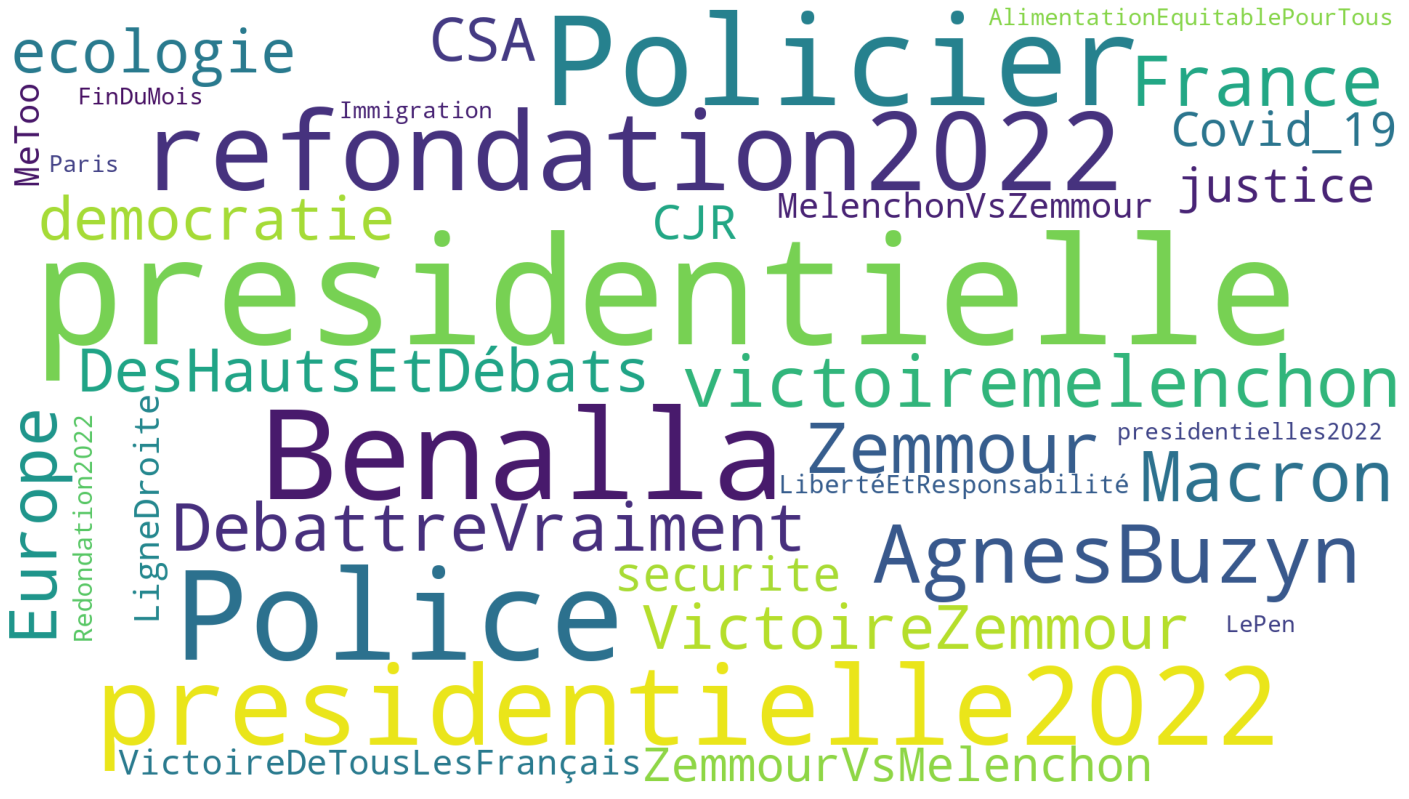

In [262]:
hashtags_visualization(name = "Alex Langlois")

In [263]:
df_ready_for_nlp[df_ready_for_nlp["name"]=="Alex Langlois"]["hashtags"]

0                                                       []
113                                                     []
186                                                     []
448                                      ['PassSanitaire']
1199                                     ['PassSanitaire']
1990                                                    []
2172                                 ['CJR', 'AgnesBuzyn']
3426                                 ['Benalla', 'Macron']
3480                                           ['Benalla']
3492                                           ['Benalla']
3996                         ['Benalla', 'Macron', 'LREM']
4063                                           ['Benalla']
4495     ['sondages', 'Presidentielle2022', 'presidenti...
13135                                 [Presidentielle2022]
13168                                                   []
13186                                            [Benalla]
5212                          ['PassSanitaire', 'COVID19

In [265]:
df_ready_for_nlp.head()

,user,id,source,text,created_date,created_hour,hashtags,retweet_count,url,name,political_party,political_orientation
0,AlexLanglois_,1425004528877899776,Twitter Web App,evanfourmizz contraire monsieur ministre jmbla...,2021-08-10,08:02:09,[],42007,https://twitter.com/AlexLanglois_/status/14250...,Alex Langlois,Refondation 2022,divers
1,JLMelenchon,1464542455538274306,Twitter Web App,mathildepanot raisons colere guadeloupe quand ...,2021-11-27,10:31:45,['Guadeloupe'],16552,https://twitter.com/JLMelenchon/status/1464542...,Jean-Luc Mélenchon,La France Insoumise,extrême_gauche
2,FabriceGrimal,1414722875404296200,Twitter for iPhone,frenchbabydog ah dommage pass sanitaire va dev...,2021-07-12,23:06:32,['macron20h'],9371,https://twitter.com/FabriceGrimal/status/14147...,Fabrice Grimal,La Concorde Citoyenne 2022,divers
3,ZemmourEric,1465644054042058752,Twitter for Android,chers compatriotes candidat a election preside...,2021-11-30,11:29:07,[],8993,https://twitter.com/ZemmourEric/status/1465644...,Eric Zemmour,Aucun,extrême_droite
4,EPhilippe_LH,1387107632759062529,Twitter for iPhone,thom astro trajectoire station va toujours oue...,2021-04-27,18:13:25,[],8857,https://twitter.com/EPhilippe_LH/status/138710...,Edouard Philippe,Horizons,droite


## Look for a word

In [184]:
def top_3_tweets_with_a_word(name):
    """
    Returns the top 3 tweets for a given word and candidate
    """
    word = input("Recherche par mot clé:")
    
    # List to store the indexes
    index_with_word = []

    # df sorted by retweet_count
    df_sorted = global_df[global_df["name"]==name].sort_values(by="retweet_count")
    
    # Rerieve Retweets
    df_sorted = df_sorted.loc[df_sorted["text"].isin([text for text in df_sorted["text"] if text[:2] != "RT"])]
    
    # Extract matching index
    for tweet in df_sorted["text"]:
        if text_cleaner(word) in word_tokenize(tweet):
            index = df_sorted[df_sorted["text"]==tweet].index[0]
            index_with_word.append(index)

    # List to store url with matching word
    url_with_word = []

    # Extract url
    for index in index_with_word[::-1]:
        url_with_word.append(df_sorted["url"].loc[index])

    # Only keep a top 3
    url_with_word = url_with_word[:3]
    
    if len(url_with_word)>0:
        return url_with_word
    else:
        return print(f"Aucun tweet écrit par {name} et contenant ce mot clé n'est archivé à ce jour. Patientez ou mieux, suggérez le lui.")

In [185]:
top_3_tweets_with_a_word(name="Alex Langlois")

Recherche par mot clé:jamais


['https://twitter.com/AlexLanglois_/status/1458101239997255681',
 'https://twitter.com/AlexLanglois_/status/1423753253595107334',
 'https://twitter.com/AlexLanglois_/status/1436956103179440136']